<a href="https://colab.research.google.com/github/SampadSikder/DP-Protocols/blob/main/AttackVBenign_ExploratoryDataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Parameter Loading

In [ ]:
import argparse
import math
import matplotlib.pyplot as plt

In [ ]:
import random
from multiprocessing import Pool
import numpy as np
import xxhash
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from dataclasses import dataclass
from typing import Literal, Dict, Any, List
from scipy.special import erfcinv

from tqdm import tqdm
import seaborn as sns

In [ ]:
domain = 0
epsilon = 0.0
n = 0
g = 0
X = []
Y = []
Y_Nattack = []
sample = []
REAL_DIST = []
ESTIMATE_DIST = []
User_Seed = []
User_Seed_Nattack = []
p = 0.0
q = 0.0
Gain = 0
splits = 0
h_ao = 0
global Gain, ESTIMATE_DIST, Y

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
global ESTIMATE_DIST, REAL_DIST, n, p, q, epsilon, domain, User_Seed, User_Seed_Nattack, target_set_size, vswhat, g, splits, h_ao

In [ ]:
epsilon = 0.7
splits = 6
h_ao = 1 # for adaptive attack
g = int(round(math.exp(epsilon))) + 1
dataset = 'emoji'
ratio = 0.4
target_set_size = 20

In [ ]:
if dataset == 'zipf':
        #n = 100000
        n = 30000
        domain = 1024
if dataset == 'emoji':
        #n = 218477
        n = 70000
        domain = 1496
if dataset == 'fire':
        #n = 723090
        n = 30000
        domain = 296

In [ ]:
p = math.exp(epsilon) / (math.exp(epsilon) + g - 1)
q = 1.0 / (math.exp(epsilon) + g - 1)

print('n: ', n)
print('ratio: ', ratio)
print('target_set_size: ', target_set_size)
print('e: ', epsilon)
print('split: ', splits)
print('h_ao: ', h_ao)

n:  70000
ratio:  0.4
target_set_size:  20
e:  0.7
split:  6
h_ao:  1


## Load Dataset

In [ ]:
def generate_zipf_dist():
  global REAL_DIST, domain, sample, X
  X = np.load('/content/drive/MyDrive/Purdue Work/Datasets/zipf.npy')
  for i in range(n):
    REAL_DIST[X[i]] += 1



In [ ]:
def generate_emoji_dist():
  global X
  data = np.load('/content/drive/MyDrive/Purdue Work/Datasets/emoji.npy')
  X = np.copy(data)
  for i in range(n):
      REAL_DIST[data[i]] += 1

In [ ]:
def generate_fire_dist():
  global X
  values = pd.read_csv("/content/drive/MyDrive/Purdue Work/Datasets/fire.csv")["Unit_ID"]
  #print(np.array(values))
  lf = LabelEncoder().fit(values)
  data = lf.transform(values)
  X = np.copy(data)
  for i in range(n):
      REAL_DIST[data[i]] += 1

In [ ]:
## Local Loading
def generate_zipf_dist():
  global REAL_DIST, domain, sample, X
  X = np.load('./zipf.npy')
  for i in range(n):
    REAL_DIST[X[i]] += 1

def generate_emoji_dist():
  global X
  data = np.load('./emoji.npy')
  X = np.copy(data)
  for i in range(n):
      REAL_DIST[data[i]] += 1

def generate_fire_dist():
  global X
  values = pd.read_csv(".fire.csv")["Unit_ID"]
  #print(np.array(values))
  lf = LabelEncoder().fit(values)
  data = lf.transform(values)
  X = np.copy(data)
  for i in range(n):
      REAL_DIST[data[i]] += 1


## Protocols

In [ ]:
from tqdm import tqdm
import random
# from mlxtend.preprocessing import TransactionEncoder
# from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd
from functools import partial
from multiprocessing import Pool
import math
import scipy.stats as stats
from scipy.stats import binom, chisquare


In [ ]:
# APA Attack
def construct_omega(e, d, perturb_method):
    p_binomial = None
    if perturb_method == 'OUE':
        p = 1 / 2
        q = 1 / (math.exp(e) + 1)
        expected_ones = p + (d - 1) * q
        p_binomial = (1 / d) * (p + (d - 1) * q)
    elif perturb_method in ('OLH_User', 'OLH_Server'):
        g = int(round(math.exp(e))) + 1
        p = math.exp(e) / (math.exp(e) + g - 1)
        q = 1 / g
        expected_ones = p + (d - 1) * q
        p_binomial = (1 / d) * (p + (d - 1) * q)
    elif perturb_method in ('HST_Server', 'HST_User'):
        p_binomial = 1 / 2
        p = q = 1 / 2
        expected_ones = d * p_binomial
    k_values = [i for i in range(d)]
    theoretical_pdf = binom.pmf(k_values, d, p_binomial)
    theoretical_pdf /= theoretical_pdf.sum()
    return theoretical_pdf

In [ ]:
def perturb_ideal(target_set = None, ratio = 0, e = 0):
    global Y, Gain, User_Seed
    Y = np.zeros(n)
    #random.shuffle(X)
    for i in range(n):
        if i < n * (1 - ratio):
            v = X[i]
            # intdigest -> get integer value from xxhash(Output of xxhash is a hash item)
            x = (xxhash.xxh3_64(str(v), seed=i).intdigest() % g)
            y = x
            p_sample = np.random.random_sample()

            if p_sample > p - q:
                # perturb
                y = np.random.randint(0, g)
            Y[i] = y
            User_Seed[i] = i
        else:
            projection_total = len(target_set)
            max_seed = i
            v = random.choice(target_set)
            x = (xxhash.xxh3_64(str(v), seed=i).intdigest() % g)
            y = x
            p_sample = np.random.random_sample()
            if p_sample > p - q:
                # perturb
                y = np.random.randint(0, g)
            Y[i] = y
            User_Seed[i] = i
    return User_Seed

# Estimates

## Default Estimates

In [ ]:
def z_bonferroni(delta_over_d: float) -> float:
    return float((2.0 ** 0.5) * erfcinv(2.0 * delta_over_d))

In [ ]:
Mechanism = Literal["OUE", "OLH", "HST_User", "HST_Server"]

def construct_omega(e: float, d: int, perturb_method: str) -> np.ndarray:
    if perturb_method == 'OUE':
        p = 1/2
        q = 1/(math.exp(e) + 1)
        p_bin = (1/d) * (p + (d - 1) * q)
    elif perturb_method in ('OLH_User', 'OLH_Server', 'OLH'):
        g = int(round(math.exp(e))) + 1
        p = math.exp(e) / (math.exp(e) + g - 1)
        q = 1 / (math.exp(e) + g - 1)
        p_bin = (1/d) * (p + (d - 1) * q)
        if p_bin is None:
            p_bin = 0.0 # Or handle appropriately based on expected behavior
    elif perturb_method in ('HST_Server', 'HST_User'):
        p_bin = 1/2
    else:
        raise ValueError("Unknown perturb_method")

    # Ensure p_bin is within the valid range [0, 1] for binom.pmf
    p_bin = np.clip(p_bin, 0.0, 1.0)

    k = np.arange(d)
    pdf = binom.pmf(k, d, p_bin)
    pdf /= pdf.sum()
    return pdf

def _oq_params_oue(epsilon: float):
    p = 0.5
    q = 1 / (math.exp(epsilon) + 1)
    return p, q

def _olh_params(epsilon: float, n: int):
    g = int(round(math.exp(epsilon))) + 1
    denom = math.exp(epsilon) + g - 1
    p = math.exp(epsilon) / denom
    q = 1.0 / denom
    denom_pg = (p * g - 1.0)
    if abs(denom_pg) < 1e-12:
        a = float('inf')
        b_n = float('inf')
    else:
        a = g / denom_pg
        b_n = n / denom_pg
    return g, p, q, a, b_n

In [ ]:
def build_normal_lists_from_mechanism_stochastic(
    epsilon: float, d: int, n: int, mechanism: str = "OUE", seed: int = 0
):
    rng = np.random.default_rng(seed)

    if mechanism == "OUE":
        omega = construct_omega(epsilon, d, 'OUE')
        p, q = 0.5, 1.0 / (math.exp(epsilon) + 1.0)

    elif mechanism == "OLH":
        omega = construct_omega(epsilon, d, 'OLH')
        g, p_olh, q_olh, a, b_n = _olh_params(epsilon, n)

    elif mechanism in ("HST_User", "HST_Server"):
        omega = construct_omega(epsilon, d, mechanism)

    else:
        raise ValueError("mechanism must be 'OUE', 'OLH', 'HST_User', or 'HST_Server'.")

    k_values = np.arange(d)
    K = rng.choice(k_values, size=n, p=omega)

    support = np.zeros((n, d), dtype=int)
    for i, k in enumerate(K):
        if k > 0:
            idx = rng.choice(d, size=min(k, d), replace=False)
            support[i, idx] = 1

    one_list = support.sum(axis=1)
    obs_counts = support.sum(axis=0).astype(float)

    if mechanism == "OUE":
        normal_ESTIMATE_DIST = (obs_counts - n * q) / max(p - q, 1e-12)
    elif mechanism == "OLH":
        normal_ESTIMATE_DIST = a * obs_counts - b_n
    else:
        normal_ESTIMATE_DIST = obs_counts

    normal_ESTIMATE_Input = None
    return support, one_list, normal_ESTIMATE_DIST, normal_ESTIMATE_Input

## OLH

### Attacked OLH

In [ ]:
num_samples = 1000000


In [ ]:
def uniform_sampling_best_vector(target_set, g, d, m, num_samples):
    best_vector = None
    closest_ones_diff = float('inf')
    max_target_count = 0
    best_score = -float('inf')
    current_target = None
    current_diff = None

    for _ in range(num_samples):
        vector = np.random.binomial(1, 1 / g, size=d)

        # Count the number of 1's in the vector
        ones_count = np.sum(vector)
        ones_diff = abs(ones_count - m)

        target_count = sum(1 for item in target_set if vector[item % d] == 1)

        # Calculate the score: target_count - ones_diff
        score = target_count - ones_diff

        if score > best_score:
            best_score = score
            best_vector = vector
            current_target = target_count
            current_diff = ones_diff

    return best_vector, current_target, current_diff

In [ ]:
def calculate_prob_according_sample_size(num_samples, d, g, h, target_set, splits):

    splits_list = random.sample(list(target_set), splits)
    target_set = splits_list
    user_vectors = []
    p = 1 / g

    mu = d * p
    sigma = np.sqrt(d * p * (1 - p))

    lower_bound = max(0, mu - h)
    upper_bound = min(d, mu + h)

    binom_dist = stats.binom(d, p)
    ratio = (binom_dist.cdf(upper_bound) - binom_dist.cdf(lower_bound - 1))
    ratio = ratio / (2 * h + 1)
    # ratio = 1

    N_effective = num_samples * ratio
    print('N_effective: ', N_effective)

    K_min = 1
    K_max = len(target_set)
    for K in range(K_max, K_min - 1, -1):
        prob = (p) ** K * N_effective
        if prob < 1:
            K_max = K
        else:
            break
    K_min = max(K_max, 1)

    K_values = np.arange(K_min, len(target_set) + 1)
    K_probs = []
    for K in K_values:
        prob = (p) ** K * N_effective
        K_probs.append(prob)
    K_probs = np.array(K_probs)

    K_probs = K_probs / np.sum(K_probs)

    return K_values, K_probs

In [ ]:
def process_attacker(i, n, ratio, target_set, g, domain, splits, h_ao, e, K_values, K_probs):
    k = np.random.choice(K_values, p=K_probs)
    random.seed()
    averge_project_hash = int(domain / g)
    if splits < averge_project_hash:
        # Split the target set for each user
        splits_list = random.sample(list(target_set), splits)
        # Gap between average mapping
        num_map = averge_project_hash
        # Remaining set (unused in this snippet but kept for completeness)
        remaining_set = set(range(domain)) - set(target_set)
        #h_ao = 0
        if h_ao == 0:
          num_map_AO = random.randint(num_map - int(h_ao), num_map + int(h_ao))
        # num_map_AO num_map_AO = np.random.choice([i for i in range(domain)], construct_omega(e, domain, 'OLH_User'))
        else:
          omega_probs = construct_omega(e, domain, 'OLH_User')
          num_map_AO = np.random.choice(range(domain), p=omega_probs)
        non_target_ones = num_map_AO - k
        # Each attacker finds their optimal hash function
        '''best_vector, target_map, diff  = uniform_sampling_best_vector(
            splits_list, g, domain, num_map_AO, num_samples)'''
        target_indices = np.random.choice(list(splits_list), size=k, replace=False)
        non_target_indices = list(set(range(domain)) - set(splits_list))
        non_target_selected = np.random.choice(non_target_indices, size=non_target_ones, replace=False)
        vector = np.zeros(domain, dtype=int)
        vector[target_indices] = 1
        vector[non_target_selected] = 1
    else:
        print('splits > averge_project_hash')
        exit(0)
    # Calculate the index in User_Seed to update
    index = int(n * (1 - ratio) + i)
    #print(f'attacker:{i}, target_map:{k}, diff:{num_map_AO - sum(vector)}, h_ao:{h_ao}, splits:{splits}')
    return index, vector

In [ ]:
def process_user_seeds(i, User_Seed_noattack, Y_Nattack, domain, g):
    print("Processing index" + str(i))
    local_estimate = np.zeros(domain)
    user_seed = User_Seed_noattack[i]
    for v in range(domain):
        if Y_Nattack[i] == (xxhash.xxh3_64(str(v), seed=int(user_seed)).intdigest() % g):
            local_estimate[v] += 1
    # Apply the correction factor
    local_estimate = local_estimate
    return local_estimate

In [ ]:
def find_hash_function(seed_list, target_set, domain_eliminate, g, num_map_AO):
    # log the max projection number
    best_score = -np.inf
    # log the best projection seed
    best_seed = -1
    # log the target mapped
    best_target_mapped = None
    # log the best hash value
    best_hash_value = None
    # log the min gap
    best_gap = None
    for seed in seed_list:
        hash_projection_list = np.zeros(g)
        hash_other_projection_list = np.zeros(g)
        hash_result = None
        for item in target_set:
            hash_result = xxhash.xxh3_64(str(item), seed=seed).intdigest() % g
            hash_projection_list[hash_result] += 1
        for item in domain_eliminate:
            hash_result = xxhash.xxh3_64(str(item), seed=seed).intdigest() % g
            hash_other_projection_list[hash_result] += 1
        score = hash_projection_list - np.abs(num_map_AO - hash_projection_list - hash_other_projection_list)
        current_best_score = np.max(score)
        max_indices = np.where(score == current_best_score)[0]
        current_max_target_mapped = hash_projection_list[max_indices]
        current_untarget_mapped = hash_other_projection_list[max_indices]
        current_hash_value = max_indices
        current_gap = np.abs(num_map_AO - current_max_target_mapped - current_untarget_mapped)
        if current_best_score > best_score:
            best_seed = seed
            best_score = current_best_score
            best_hash_value = current_hash_value
            best_gap = current_gap
            best_target_mapped = current_max_target_mapped
    if best_seed == -1:
        return -1, 0.0, None
    return best_seed, best_gap, best_target_mapped, best_hash_value


In [ ]:
def process_attacker_User(i, n, ratio, target_set, g, domain, splits, e, h_ao):
    average_project_hash = int(domain / g)
    vector = np.zeros(domain, dtype=int)
    if splits < average_project_hash:
        # Split the target set for each user
        splits_list = random.sample(list(target_set), splits)
        # Gap between average mapping
        num_map = average_project_hash
        # Remaining set (unused in this snippet but kept for completeness)
        remaining_set = set(range(domain)) - set(target_set)
        # Adaptive gap between average mapping
        num_map_AO = random.randint(num_map - h_ao, num_map + h_ao)
        # theoretical APA use the omega_list to replace the num_map_AO num_map_AO = np.random.choice([i for i in range(domain)], construct_omega(e, domain, 'OLH_User'))
        #num_map_AO = np.random.choice([i for i in range(domain)], construct_omega(e, domain, 'OLH_User'))
        seed_list = random.sample(range(1, 10000000), num_samples)
        best_seed, best_gap, current_max_target_mapped, best_hash_value = find_hash_function(seed_list, splits_list,
                                                                                             remaining_set, g,
                                                                                             num_map_AO)
    else:
        print('splits > averge_project_hash')
        exit(0)
    # Calculate the index in User_Seed to update
    index = int(n * (1 - ratio) + i)
    for v in range(domain):
        hashed_value = xxhash.xxh3_64(str(v), seed=int(best_seed)).intdigest() % g
        if hashed_value == best_hash_value:
            vector[v] = 1
   # print(f'attacker:{i}, target_map:{current_max_target_mapped}, diff:{best_gap}, h_ao:{h_ao}, splits:{splits}')
    return index, vector


In [ ]:

def build_support_list_1_OLH(domain, Y, n, User_Seed, ratio, g, target_set, p, splits, e, h_ao=0, processor=100):

    K_values, K_probs = calculate_prob_according_sample_size(num_samples, domain, g, h_ao, target_set, splits)

    # Prepare the partial function with fixed arguments for multiprocessing
    process_attacker_partial = partial(
        #process_attacker_User,
        # Simulate 1,000,000 hash samples, fast version
        process_attacker,
        n=n,
        ratio=ratio,
        target_set=target_set,
        g=g,
        domain=domain,
        splits=splits,
        h_ao= 10*h_ao,
        e=e,
        K_values = K_values,
        K_probs = K_probs
    )

    # Calculate the number of attackers
    num_attackers = int(round(n * ratio))

    # Parallel execution of process_attacker using multiprocessing
    with Pool(processes=processor) as pool:
        # Use imap to process in parallel and tqdm for progress bar
        results = list(tqdm(
            pool.imap(process_attacker_partial, range(num_attackers)),
            total=num_attackers,
            desc='Finding optimal seeds'
        ))

    vector_matrix = np.zeros((num_attackers, domain))
    # Update User_Seed with the results from all attackers
    for i, (index, best_vector) in enumerate(results):
        vector_matrix[i, :] = best_vector

    # Create a partial function with fixed arguments for processing user seeds
    process_partial = partial(
        process_user_seeds,
        User_Seed_noattack=User_Seed,
        Y_Nattack=Y,
        domain=domain,
        g=g
    )

    # Process user seeds across multiple processes
    with Pool(processes=processor) as pool:
        estimates = pool.map(process_partial, range(n - num_attackers))
    # input attack's estimate
    '''with Pool(processes=processor) as pool:
        estimates_input = pool.map(process_partial, range(int(n)))'''

    # Combine the results from all processes
    estimates = np.array(estimates)
    # estimates_input = np.array(estimates_input)
    # estimates_input = estimates_input.reshape(int(n), domain)
    estimates = np.vstack((estimates, vector_matrix))
    estimates = estimates.reshape(int(n), domain)
    Results_support = estimates
    Results_support_one_list = np.sum(Results_support, axis=1)
    Estimations = np.sum(Results_support, axis=0)
    # Estimations_input = np.sum(estimates_input, axis=0)
    a = 1.0 * g / (p * g - 1)
    b = 1.0 * n / (p * g - 1)
    Estimations = a * Estimations - b
    # Estimations_input = a * Estimations_input - b
    Estimations_input = None
    return Results_support, Results_support_one_list, Estimations, Estimations_input

### OLH Server

In [ ]:
def process_attacker_server(i, n, ratio, target_set, g, domain, User_Seed, splits):
    '''
    Function to process each attacker.
    Each attacker finds the best hash value and constructs a vector based on it.

    :param i: Index of the attacker.
    :param n: Total number of users.
    :param ratio: Ratio of attackers to total users.
    :param target_set: Set of target items.
    :param g: Range of hash function outputs (modulo value).
    :param domain: Total domain size.
    :param User_Seed: List of hash seeds for users.
    :return: Tuple of (index in User_Seed, attack_vector).
    '''
    # Calculate the index in User_Seed
    index = int(n * (1 - ratio) + i)
    user_seed = User_Seed[index]

    # Compute hash values for all target items
    target_hashes = {}
    splits_list = random.sample(list(target_set), splits)
    for t in splits_list:
        hashed_value = xxhash.xxh3_64(str(t), seed=int(user_seed)).intdigest() % g
        if hashed_value in target_hashes:
            target_hashes[hashed_value] += 1
        else:
            target_hashes[hashed_value] = 1

    # Find the hash value that maps the most target items
    best_hashed_value = max(target_hashes, key=target_hashes.get)
    max_target_count = target_hashes[best_hashed_value]

    # Construct the attack vector
    attack_vector = np.zeros(domain)
    for v in range(domain):
        hashed_value = xxhash.xxh3_64(str(v), seed=int(user_seed)).intdigest() % g
        if hashed_value == best_hashed_value:
            attack_vector[v] = 1

    print(f'attacker:{i}, best_hashed_value:{best_hashed_value}, max_targets_mapped:{max_target_count}')
    return index, attack_vector


In [ ]:
def build_support_list_1_OLH_Server(domain, Y, n, User_Seed, ratio, g, target_set, p, splits, h_ao=0, epsilon=1.0, processor=100):
    '''
    build the support list matrix
    :return:
    '''
    # Prepare the partial function with fixed arguments for multiprocessing
    process_attacker_partial = partial(
        process_attacker_server,
        n=n,
        ratio=ratio,
        target_set=target_set,
        g=g,
        domain=domain,
        User_Seed=User_Seed,
        splits=splits
    )

    # Calculate the number of attackers
    num_attackers = int(round(n * ratio))
    num_normal = int(n - num_attackers)

    # Parallel execution of process_attacker using multiprocessing
    with Pool(processes=processor) as pool:
        # Use imap to process in parallel and tqdm for progress bar
        results = list(tqdm(
            pool.imap(process_attacker_partial, range(num_attackers)),
            total=num_attackers,
            desc='Processing attackers'
        ))

    vector_matrix = np.zeros((num_attackers, domain))
    # Update User_Seed with the results from all attackers
    for i, (index, best_vector) in enumerate(results):
        vector_matrix[i, :] = best_vector

    # Create a partial function with fixed arguments for processing user seeds
    process_partial = partial(
        process_user_seeds,
        User_Seed_noattack=User_Seed,
        Y_Nattack=Y,
        domain=domain,
        g=g
    )

    # Process user seeds across multiple processes
    with Pool(processes=processor) as pool:
        estimates = pool.map(process_partial, range(int(num_normal)))
    # input attack's estimate
    '''with Pool(processes=processor) as pool:
        estimates_input = pool.map(process_partial, range(int(n)))'''

    # Combine the results from all processes
    estimates = np.array(estimates)
    # estimates_input = np.array(estimates_input)
    # estimates_input = estimates_input.reshape(int(n), domain)
    estimates = np.vstack((estimates, vector_matrix))
    estimates = estimates.reshape(int(n), domain)
    Results_support = estimates
    Results_support_one_list = np.sum(Results_support, axis=1)
    Estimations = np.sum(Results_support, axis=0)
    # Estimations_input = np.sum(estimates_input, axis=0)
    a = 1.0 * g / (p * g - 1)
    b = 1.0 * n / (p * g - 1)
    Estimations = a * Estimations - b
    # Estimations_input = a * Estimations_input - b
    Estimations_input = None
    return Results_support, Results_support_one_list, Estimations, Estimations_input



### Normal OLH

In [ ]:
def perturb_normal_olh(X, g, p, q):

    Y_normal = np.zeros(len(X))
    for i, v in enumerate(X):
        # Generate hash value
        x = (xxhash.xxh3_64(str(v), seed=i).intdigest() % g)
        y = x
        p_sample = np.random.random_sample()

        # Apply perturbation
        if p_sample <= p:

            # perturb
            y = np.random.randint(0, g)
        Y_normal[i] = y
    return Y_normal

In [ ]:
def build_support_list_normal_olh(Y_normal, n, domain, g, p):
    Results_support_normal = np.zeros((n, domain))
    Estimations_normal_raw = np.zeros(domain)

    for i in range(n):
        user_seed = i  # Use the same seed as in perturbation
        for v in range(domain):
            hashed_value = (xxhash.xxh3_64(str(v), seed=user_seed).intdigest() % g)
            if Y_normal[i] == hashed_value:
                Results_support_normal[i, v] += 1
                Estimations_normal_raw[v] += 1

    Results_support_one_list_normal = np.sum(Results_support_normal, axis=1)

    # Apply the OLH correction factor
    a = 1.0 * g / (p * g - 1)
    b = 1.0 * n / (p * g - 1)
    Estimations_normal = a * Estimations_normal_raw - b

    return Results_support_normal, Results_support_one_list_normal, Estimations_normal

## OUE

### Normal OUE

In [ ]:
def perturb_normal_oue_process(args):
    start, end, domain, q_OUE, X = args
    local_user_data = np.zeros((end - start, domain), dtype=int)

    for i in tqdm(range(start, end)):
        v = X[i]
        random_flip = np.random.rand(domain) < q_OUE
        local_user_data[i - start, :] = random_flip
        local_user_data[i - start, v] = 1 if np.random.rand() < 0.5 else 0
    return local_user_data

In [ ]:
def perturb_normal_OUE_multi(X, domain, epsilon, num_processes=1):
    q_OUE = 1 / (math.exp(epsilon) + 1)
    p = 0.5

    # Split the task into chunks for each process
    ranges = [(i * n // num_processes, (i + 1) * n // num_processes, domain, q_OUE, X) for i in range(num_processes)]
    with Pool(num_processes) as pool:
        results = pool.map(perturb_normal_oue_process, ranges)
    # Combine the results from each process
    user_data = np.vstack(results)
    return user_data

### Attacked OUE

In [ ]:
def build_support_list_1_OUE(estimates, n, epsilon):
    q_OUE = 1 / (math.exp(epsilon) + 1)
    p = 0.5
    q = q_OUE
    Results_support = np.array(estimates)
    Estimations = np.sum(Results_support, axis=0)
    Results_support_one_list = np.sum(Results_support, axis=1)
    Estimations = [(i - n * q_OUE) / (p - q_OUE) for i in Estimations]
    Estimations_input = None

    return Results_support, Results_support_one_list, Estimations, Estimations_input


In [ ]:
def perturb_oue_process(args):
    start, end, n, domain, q_OUE, ratio, target_set, X, h_ao, splits, average_1_num_list = args
    local_user_data = np.zeros((end - start, domain), dtype=int)
    h_ao *= 10

    for i in tqdm(range(start, end)):
        v = X[i]
        if i < n * (1 - ratio):
            # benign users
            random_flip = np.random.rand(domain) < q_OUE
            local_user_data[i - start, :] = random_flip
            local_user_data[i - start, v] = 1 if np.random.rand() < 0.5 else 0
        else:
            # fake users
            if splits < average_1_num_list[i]:
                splits_list = random.sample(list(target_set), splits)
                local_user_data[i - start, list(splits_list)] = 1
                remaining_set = list(set(range(domain)) - set(splits_list))
                diff = int(average_1_num_list[i] - len(splits_list))
                diff_AO = diff
                #diff_AO = random.randint(diff - h_ao, diff + h_ao)
                #print(f'attacker:{i}, exp1:{int(0.5 + (domain - 1) * q_OUE)}, h_ao:{h_ao}, splits:{splits}')
                if diff_AO > 0 and len(remaining_set) >= diff:
                    random_numbers = random.sample(remaining_set, diff_AO)
                    local_user_data[i - start, random_numbers] = 1
            else:
                splits_list = random.sample(list(target_set), average_1_num_list[i])
                local_user_data[i - start, list(splits_list)] = 1
                remaining_set = list(set(range(domain)) - set(splits_list))
                diff = int(average_1_num_list[i] - len(splits_list))
                diff_AO = diff
                #diff_AO = random.randint(diff - h_ao, diff + h_ao)
                #print(f'attacker:{i}, exp1:{int(0.5 + (domain - 1) * q_OUE)}, h_ao:{h_ao}, splits:{splits}')
                if diff_AO > 0 and len(remaining_set) >= diff:
                    random_numbers = random.sample(remaining_set, diff_AO)
                    local_user_data[i - start, random_numbers] = 1
    return local_user_data

In [ ]:
def perturb_OUE_multi(target_set = None, ratio = 0, h_ao = 0, split = 0, num_processes=1):
    global p, q # Removed global X here

    q_OUE = 1 / (math.exp(epsilon) + 1)
    p = 0.5
    q = q_OUE

    #theoretical_pdf = construct_omega(epsilon, domain, 'OUE')
    #average_1_num_list = [int(0.5 + (domain - 1) * q_OUE)] * n
    # theoretical APA use the below code to replace the average_1_num_list and set h_ao = 0
    omega_probs = construct_omega(epsilon, domain, 'OUE')
    if h_ao == 1:
        average_1_num_list = np.random.choice([i for i in range(domain)], size=n, p=omega_probs)
    else:
        # When h_ao is not 1, ensure average_1_num_list is an array of size n
        average_1_num_list = [int(0.5 + (domain - 1) * q_OUE)] * n

    # Split the task into chunks for each process
    # Pass X as part of the range arguments
    ranges = [(i * n // num_processes, (i + 1) * n // num_processes, n, domain, q_OUE, ratio, target_set, X, h_ao, split, average_1_num_list) for i in range(num_processes)]
    with Pool(num_processes) as pool:
        results = pool.map(perturb_oue_process, ranges)
    # Combine the results from each process
    user_data = np.vstack(results)
    #Estimations = np.sum(user_data, axis=0)
    return user_data

In [ ]:
import math
import numpy as np
import random
import multiprocessing as mp
from multiprocessing import Pool

In [ ]:
_worker_X = None
_worker_domain = None
_worker_q_OUE = None

def _init_worker(X, domain, q_OUE):
    global _worker_X, _worker_domain, _worker_q_OUE
    _worker_X = X
    _worker_domain = domain
    _worker_q_OUE = q_OUE

In [ ]:
def _perturb_oue_process_fix(args):

    start, end, ratio, target_set, h_ao, splits, average_1_num_list = args

    if _worker_X is None:
        raise RuntimeError("Worker: _worker_X is None. Did you use initializer?")
    n = _worker_X.shape[0]
    domain = _worker_domain
    q_OUE = _worker_q_OUE
    if n == 0:
        raise ValueError("Worker: received empty X (n == 0)")

    local_user_data = np.zeros((end - start, domain), dtype=int)
    h_ao_local = int(h_ao * 10)

    for idx, i in enumerate(range(start, end)):
        v = int(_worker_X[i])
        if v < 0 or v >= domain:
            raise IndexError(f"Worker: value v={v} at X[{i}] out of domain range [0, {domain})")

        if i < n * (1 - ratio):
            random_flip = (np.random.rand(domain) < q_OUE).astype(int)
            local_user_data[idx, :] = random_flip
            local_user_data[idx, v] = 1 if np.random.rand() < 0.5 else 0
            continue

        avg1 = int(average_1_num_list[i])
        if splits < avg1:
            # pick up to `splits` targets from target_set
            splits_k = min(int(splits), len(target_set))
            if splits_k > 0:
                splits_list = random.sample(list(target_set), splits_k)
                local_user_data[idx, splits_list] = 1
            remaining_set = list(set(range(domain)) - set(splits_list if splits_k>0 else []))
            diff = avg1 - len(splits_list if splits_k>0 else [])
            diff_AO = random.randint(max(0, diff - h_ao_local), diff + h_ao_local) if diff > 0 else 0
            if diff_AO > 0 and len(remaining_set) >= diff_AO:
                random_numbers = random.sample(remaining_set, diff_AO)
                local_user_data[idx, random_numbers] = 1
        else:
            k = min(avg1, len(target_set))
            if k > 0:
                splits_list = random.sample(list(target_set), k)
                local_user_data[idx, splits_list] = 1
            remaining_set = list(set(range(domain)) - set(splits_list if k>0 else []))
            diff = avg1 - len(splits_list if k>0 else [])
            diff_AO = random.randint(max(0, diff - h_ao_local), diff + h_ao_local) if diff > 0 else 0
            if diff_AO > 0 and len(remaining_set) >= diff_AO:
                random_numbers = random.sample(remaining_set, diff_AO)
                local_user_data[idx, random_numbers] = 1

    return local_user_data

In [ ]:
def perturb_OUE_multi_fix(target_set=None, ratio=0, h_ao=0, split=0, num_processes=1,
                      X=None, epsilon=None, domain=None, n=None):
    # validate inputs early (parent)
    assert X is not None, "X must be provided to perturb_OUE_multi"
    assert isinstance(X, np.ndarray), "X must be a numpy array"
    assert X.shape[0] == n, f"X.shape[0] ({X.shape[0]}) must equal n ({n})"
    assert domain is not None and epsilon is not None

    q_OUE = 1 / (math.exp(epsilon) + 1)
    p = 0.5
    q = q_OUE

    # prepare average_1_num_list
    omega_probs = construct_omega(epsilon, domain, 'OUE')
    if h_ao == 1:
        average_1_num_list = np.random.choice(np.arange(domain), size=n, p=omega_probs)
    else:
        average_1_num_list = np.full(n, int(0.5 + (domain - 1) * q_OUE), dtype=int)

    # prepare ranges (start, end, other args). ensure full coverage and correct indices
    ranges = []
    for i in range(num_processes):
        start = (i * n) // num_processes
        end = ((i + 1) * n) // num_processes if i < num_processes - 1 else n
        if end <= start:
            continue
        ranges.append((start, end, ratio, target_set, h_ao, split, average_1_num_list))

    # create pool with initializer so each worker gets a copy of X once
    ctx = mp.get_context()  # default context; on Linux this may be 'fork'
    with ctx.Pool(processes=len(ranges), initializer=_init_worker, initargs=(X, domain, q_OUE)) as pool:
        results = pool.map(_perturb_oue_process_fix, ranges)

    # combine results (vstack)
    user_data = np.vstack(results)
    return user_data

## Attacked List of 1s

In [ ]:
# Define the protocol (either 'OUE' or 'OLH')
protocol = 'OUE' # Change to 'OUE' to run OUE protocol

In [ ]:
target_set = random.sample(range(0, domain), target_set_size)


In [ ]:
f_T = sum(REAL_DIST[element] for element in target_set) / sum(REAL_DIST)

Gain = (Gain - n * ratio * (f_T * (p - 1/g) + target_set_size * 1/g)) / (n * (p - 1/g))
print('Gain: ', Gain)

IndexError: list index out of range

In [ ]:

User_Seed = perturb_ideal(target_set, ratio, epsilon)

In [ ]:
# one_list is per user support, EST_DIST is per domain support and support list is per user 1s list
if protocol == "OLH":
  support_list, one_list, ESTIMATE_DIST_Nattack, ESTIMATE_Input = build_support_list_1_OLH(domain, Y, n, User_Seed, ratio, g, target_set, p, splits, h_ao, epsilon, processor=2)
elif protocol == "OUE":
   ESTIMATE_DIST_Matrix = perturb_OUE_multi(target_set, ratio, h_ao, splits)
   perturb_method = 'OUE'
   support_list, one_list, ESTIMATE_DIST_Nattack, ESTIMATE_Input = build_support_list_1_OUE(
        ESTIMATE_DIST_Matrix, n, epsilon)

## Ideal List of 1s

In [ ]:
if protocol == "OUE":
    ideal_support_list, ideal_one_list, ideal_ESTIMATE_DIST, ideal_ESTIMATE_Input = \
        build_normal_lists_from_mechanism_stochastic(epsilon=epsilon, d=domain, n=n, mechanism="OUE", seed=42)

elif protocol == "OLH":
    ideal_support_list, ideal_one_list, ideal_ESTIMATE_DIST, ideal_ESTIMATE_Input = \
        build_normal_lists_from_mechanism_stochastic(epsilon=epsilon, d=domain, n=n, mechanism="OLH", seed=42)

else:
    raise ValueError("protocol must be 'OUE' or 'OLH'")

## Normal List

In [ ]:
# Define the protocol (either 'OUE' or 'OLH' # Change to 'OUE' to run OUE protocol

if protocol == 'OLH':
    print("Running OLH protocol...")
    # Normal OLH
    Y_normal = perturb_normal_olh(X, g, p, q)
    benign_support_list, benign_one_list, benign_ESTIMATE_DIST = build_support_list_normal_olh(Y_normal, n, domain, g, p)
    benign_ESTIMATE_Input = None


elif protocol == 'OUE':
    print("Running OUE protocol...")
    # Normal OUE
    Y_normal = perturb_normal_OUE_multi(X, domain, epsilon, num_processes=2)
    benign_support_list, benign_one_list, benign_ESTIMATE_DIST, _ = build_support_list_1_OUE(Y_normal, n, epsilon)

else:
    print("Invalid protocol specified. Please choose 'OLH' or 'OUE'.")

Running OUE protocol...


  0%|          | 0/35000 [00:00<?, ?it/s]



IndexError: list index out of range

In [ ]:
#Y_normal = perturb_normal_olh(X, g, p, q)
#no_attack_support_list, no_attack_one_list, no_attack_ESTIMATE_DIST = build_support_list_normal_olh(Y_normal, n, domain, g, p)
#no_attack_ESTIMATE_Input = None

## Comparison

In [ ]:
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance, ks_2samp

In [ ]:
def calculate_distribution_differences(attack_dist, normal_dist, attack_one_list, normal_one_list):
    """
    Calculate various statistical measures to quantify differences between
    attacked and normal distributions/one_lists
    """

    # Ensure arrays are numpy arrays
    attack_dist = np.array(attack_dist)
    normal_dist = np.array(normal_dist)
    attack_one_list = np.array(attack_one_list)
    normal_one_list = np.array(normal_one_list)

    differences = {}

    # 1. Jensen-Shannon Divergence (symmetric KL divergence)
    # Ensure non-negativity and normalize for probability distributions
    attack_prob = np.maximum(attack_dist, 0)
    normal_prob = np.maximum(normal_dist, 0)

    attack_prob = attack_prob / np.sum(attack_prob) if np.sum(attack_prob) > 0 else attack_prob
    normal_prob = normal_prob / np.sum(normal_prob) if np.sum(normal_prob) > 0 else normal_prob

    epsilon = 1e-10
    attack_prob = attack_prob + epsilon
    normal_prob = normal_prob + epsilon
    attack_prob = attack_prob / np.sum(attack_prob)
    normal_prob = normal_prob / np.sum(normal_prob)

    js_divergence = jensenshannon(attack_prob, normal_prob)
    differences['jensen_shannon_divergence'] = js_divergence

    # 2. Kullback-Leibler Divergence (directional)
    kl_divergence = stats.entropy(attack_prob, normal_prob)
    differences['kl_divergence'] = kl_divergence

    # 3. Wasserstein Distance (Earth Mover's Distance)
    # Use the non-negative probabilities for Wasserstein distance
    wasserstein_dist = wasserstein_distance(range(len(attack_dist)), range(len(normal_dist)),
                                          attack_prob, normal_prob)
    differences['wasserstein_distance'] = wasserstein_dist

    # 3b. Wasserstein Distance (Earth Mover's Distance)
    # Use the non-negative probabilities for Wasserstein distance
    wasserstein_one_list = wasserstein_distance(attack_one_list, normal_one_list)
    differences['wasserstein_one_list'] = wasserstein_one_list

    # 4. Kolmogorov-Smirnov Test
    # First convert distributions to samples
    # Need to handle potential non-integer counts due to estimation.
    # Rounding to nearest integer or sampling based on probability could be options.
    # For simplicity here, we'll skip KS test on distributions with negative estimates.
    # A more robust approach would involve a different test or distribution transformation.
    attack_samples = np.repeat(range(len(attack_dist)), np.maximum(attack_dist, 0).astype(int))
    normal_samples = np.repeat(range(len(normal_dist)), np.maximum(normal_dist, 0).astype(int))


    if len(attack_samples) > 0 and len(normal_samples) > 0:
        # KS test requires non-negative counts. Using rounded non-negative counts.
        ks_stat, ks_pvalue = ks_2samp(attack_samples, normal_samples)
        differences['ks_statistic'] = ks_stat
        differences['ks_pvalue'] = ks_pvalue
    else:
        differences['ks_statistic'] = np.nan
        differences['ks_pvalue'] = np.nan


    # 5. Chi-square test
    if len(attack_dist) == len(normal_dist):
        # Combine distributions for chi-square test
        # Chi-square test requires non-negative observed and expected frequencies
        observed = np.maximum(attack_dist, 0)
        expected = np.maximum(normal_dist, 0)
        # Avoid division by zero
        expected = np.where(expected == 0, 1e-10, expected) # Use a small epsilon for expected=0
        chi2_stat = np.sum((observed - expected)**2 / expected)
        differences['chi_square_statistic'] = chi2_stat
    else:
        differences['chi_square_statistic'] = np.nan

    # 6. Mean Squared Error between distributions
    if len(attack_dist) == len(normal_dist):
        mse_dist = mean_squared_error(normal_dist, attack_dist) # MSE can handle negative values
        differences['distribution_mse'] = mse_dist
    else:
        differences['distribution_mse'] = np.nan

    # 7. Total Variation Distance
    tv_distance = 0.5 * np.sum(np.abs(attack_prob - normal_prob))
    differences['total_variation_distance'] = tv_distance


    # 8. Statistical moments comparison
    differences['mean_difference'] = np.mean(attack_one_list) - np.mean(normal_one_list)
    differences['std_difference'] = np.std(attack_one_list) - np.std(normal_one_list)
    differences['skewness_difference'] = stats.skew(attack_one_list) - stats.skew(normal_one_list)
    differences['kurtosis_difference'] = stats.kurtosis(attack_one_list) - stats.kurtosis(normal_one_list)

    # 9. Two-sample t-test
    t_stat, t_pvalue = stats.ttest_ind(attack_one_list, normal_one_list)
    differences['t_test_statistic'] = t_stat
    differences['t_test_pvalue'] = t_pvalue

    # 10. Mann-Whitney U test (non-parametric)
    u_stat, u_pvalue = stats.mannwhitneyu(attack_one_list, normal_one_list, alternative='two-sided')
    differences['mannwhitney_statistic'] = u_stat
    differences['mannwhitney_pvalue'] = u_pvalue

    # 11. Kolmogorov-Smirnov test for one_lists
    ks_one_stat, ks_one_pvalue = ks_2samp(attack_one_list, normal_one_list)
    differences['ks_one_list_statistic'] = ks_one_stat
    differences['ks_one_list_pvalue'] = ks_one_pvalue

    # 15. Range and IQR differences
    attack_range = np.ptp(attack_one_list)  # peak-to-peak (range)
    normal_range = np.ptp(normal_one_list)
    differences['range_difference'] = attack_range - normal_range

    attack_iqr = np.percentile(attack_one_list, 75) - np.percentile(attack_one_list, 25)
    normal_iqr = np.percentile(normal_one_list, 75) - np.percentile(normal_one_list, 25)
    differences['iqr_difference'] = attack_iqr - normal_iqr


    return differences

In [ ]:
def create_feature_vector(differences):
    """
    Create a feature vector for machine learning from the differences dictionary
    """
    features = []
    feature_names = []

    for key, value in differences.items():
        if not np.isnan(value) and not np.isinf(value):
            features.append(value)
            feature_names.append(key)

    return np.array(features), feature_names

In [ ]:
def plot_comparison_analysis(attack_dist, normal_dist, attack_one_list, normal_one_list, differences):
    """
    Create comprehensive visualization of the differences
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Plot 1: Distribution comparison
    axes[0, 0].bar(range(len(normal_dist)), normal_dist, alpha=0.6, label='Normal', color='blue')
    axes[0, 0].bar(range(len(attack_dist)), attack_dist, alpha=0.6, label='Attack', color='red')
    axes[0, 0].set_title('Distribution Comparison')
    axes[0, 0].set_xlabel('Domain Values')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()

    # Plot 2: One_list histograms
    axes[0, 1].hist(normal_one_list, bins=50, alpha=0.6, label='Normal', color='blue', density=True)
    axes[0, 1].hist(attack_one_list, bins=50, alpha=0.6, label='Attack', color='red', density=True)
    axes[0, 1].set_title('One List Distribution')
    axes[0, 1].set_xlabel('Values')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].legend()

    # Plot 3: Box plots
    axes[0, 2].boxplot([normal_one_list, attack_one_list], labels=['Normal', 'Attack'])
    axes[0, 2].set_title('Box Plot Comparison')
    axes[0, 2].set_ylabel('Values')

    # Plot 4: Q-Q plot
    from scipy.stats import probplot
    probplot(attack_one_list, dist=stats.norm, plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot: Attack vs Normal Distribution')

    # Plot 5: Statistical measures bar chart - UPDATED with both Wasserstein distances highlighted
    key_measures = ['jensen_shannon_divergence', 'wasserstein_distance', 'wasserstein_one_list',
                   'mean_difference', 'std_difference', 'ks_one_list_statistic']
    key_values = [differences.get(k, 0) for k in key_measures]

    colors = ['red', 'orange', 'darkorange', 'yellow', 'green', 'blue']
    axes[1, 1].bar(range(len(key_measures)), key_values, color=colors)
    axes[1, 1].set_xticks(range(len(key_measures)))
    axes[1, 1].set_xticklabels(key_measures, rotation=45, ha='right')
    axes[1, 1].set_title('Key Statistical Measures')
    axes[1, 1].set_ylabel('Value')
    axes[1, 1].grid(axis='y', alpha=0.3)

    # Plot 6: Cumulative distribution
    sorted_normal = np.sort(normal_one_list)
    sorted_attack = np.sort(attack_one_list)
    y_normal = np.arange(1, len(sorted_normal) + 1) / len(sorted_normal)
    y_attack = np.arange(1, len(sorted_attack) + 1) / len(sorted_attack)

    axes[1, 2].plot(sorted_normal, y_normal, label='Normal', color='blue', linewidth=2)
    axes[1, 2].plot(sorted_attack, y_attack, label='Attack', color='red', linewidth=2)
    axes[1, 2].set_title('Cumulative Distribution Function')
    axes[1, 2].set_xlabel('Values')
    axes[1, 2].set_ylabel('Cumulative Probability')
    axes[1, 2].legend()

    plt.tight_layout()
    plt.show()


In [ ]:
def print_analysis_summary(differences):
    """
    Print a summary of the key differences
    """
    print("=" * 60)
    print("STATISTICAL DIFFERENCE ANALYSIS SUMMARY")
    print("=" * 60)

    print("\n DISTRIBUTION-BASED MEASURES:")
    print(f"  Jensen-Shannon Divergence: {differences['jensen_shannon_divergence']:.6f}")
    print(f"  Wasserstein Distance: {differences['wasserstein_one_list']:.6f}")
    print(f"  Total Variation Distance: {differences['total_variation_distance']:.6f}")
    print(f"  KL Divergence: {differences['kl_divergence']:.6f}")

    print("\nONE_LIST STATISTICAL MEASURES:")
    print(f"  Mean Difference: {differences['mean_difference']:.6f}")
    print(f"  Std Deviation Difference: {differences['std_difference']:.6f}")
    print(f"  Skewness Difference: {differences['skewness_difference']:.6f}")
    print(f"  Kurtosis Difference: {differences['kurtosis_difference']:.6f}")
    print(f"  Wasserstein Difference: {differences['kurtosis_difference']:.6f}")


    print("\nHYPOTHESIS TESTS:")
    print(f"  T-test p-value: {differences['t_test_pvalue']:.6f}")
    print(f"  Mann-Whitney p-value: {differences['mannwhitney_pvalue']:.6f}")
    print(f"  KS test p-value: {differences['ks_one_list_pvalue']:.6f}")

    print("\n🎯 FEATURE ENGINEERING INSIGHTS:")
    # Identify most discriminative features
    discriminative_features = []

    if differences['jensen_shannon_divergence'] > 0.1:
        discriminative_features.append("High JS divergence - distributions are quite different")

    if differences['t_test_pvalue'] < 0.05:
        discriminative_features.append("Significant t-test - means are different")

    if differences['ks_one_list_pvalue'] < 0.05:
        discriminative_features.append("Significant KS test - distributions are different")

    if abs(differences['mean_difference']) > abs(differences['std_difference']):
        discriminative_features.append("Mean shift is primary difference")
    else:
        discriminative_features.append("Variance change is primary difference")

    for feature in discriminative_features:
        print(f"  • {feature}")


# Load

In [ ]:
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance, ks_2samp

In [ ]:
import os
import gc

In [ ]:
def generate_zipf_dist(n, domain):
    """Load Zipf distribution data"""
    X = np.load('/content/drive/MyDrive/Purdue Work/Datasets/zipf.npy')
    X = X[:n]  # Take first n samples
    REAL_DIST = np.zeros(domain)
    for i in range(len(X)):
        if X[i] < domain:
            REAL_DIST[X[i]] += 1
    return X, REAL_DIST

def generate_emoji_dist(n, domain):
    """Load Emoji distribution data"""
    data = np.load('/content/drive/MyDrive/Purdue Work/Datasets/emoji.npy')
    X = np.copy(data[:n])
    REAL_DIST = np.zeros(domain)
    for i in range(len(X)):
        if X[i] < domain:
            REAL_DIST[X[i]] += 1
    return X, REAL_DIST

def generate_fire_dist(n, domain):
    """Load Fire distribution data"""
    values = pd.read_csv("/content/drive/MyDrive/Purdue Work/Datasets/fire.csv")["Unit_ID"]
    lf = LabelEncoder().fit(values)
    data = lf.transform(values)
    X = np.copy(data[:n])
    REAL_DIST = np.zeros(domain)
    for i in range(len(X)):
        if X[i] < domain:
            REAL_DIST[X[i]] += 1
    return X, REAL_DIST

# Training AutoEncoders and Dataset Preparation

In [ ]:
def compute_statistical_features(one_list, ESTIMATE_DIST, ideal_one_list, ideal_ESTIMATE_DIST, epsilon, protocol, n):
    """
    Compute comprehensive statistical features comparing incoming vs ideal distributions
    """
    features = []

    wass_one_list = wasserstein_distance(one_list, ideal_one_list)
    wass_estimate_dist = wasserstein_distance(ESTIMATE_DIST, ideal_ESTIMATE_DIST)
    features.extend([wass_one_list, wass_estimate_dist])

    #ks_stat_one, ks_pval_one = ks_2samp(one_list, ideal_one_list)
    #ks_stat_dist, ks_pval_dist = ks_2samp(ESTIMATE_DIST, ideal_ESTIMATE_DIST)
    #features.extend([ks_stat_one, ks_pval_one, ks_stat_dist, ks_pval_dist])


    one_list_norm = one_list / (one_list.sum() + 1e-10)
    ideal_one_list_norm = ideal_one_list / (ideal_one_list.sum() + 1e-10)
    ESTIMATE_DIST_norm = np.abs(ESTIMATE_DIST)
    ESTIMATE_DIST_norm = ESTIMATE_DIST_norm / (ESTIMATE_DIST_norm.sum() + 1e-10)
    ideal_ESTIMATE_DIST_norm = np.abs(ideal_ESTIMATE_DIST)
    ideal_ESTIMATE_DIST_norm = ideal_ESTIMATE_DIST_norm / (ideal_ESTIMATE_DIST_norm.sum() + 1e-10)

    js_one = jensenshannon(one_list_norm, ideal_one_list_norm)
    js_dist = jensenshannon(ESTIMATE_DIST_norm, ideal_ESTIMATE_DIST_norm)
    features.extend([js_one, js_dist])

    #mean_diff = np.mean(one_list) - np.mean(ideal_one_list)
    #std_diff = np.std(one_list) - np.std(ideal_one_list)

    from scipy.stats import skew, kurtosis
    #skew_diff = skew(one_list) - skew(ideal_one_list)
    #kurt_diff = kurtosis(one_list) - kurtosis(ideal_one_list)
    #features.extend([mean_diff, std_diff, skew_diff, kurt_diff])

    #concentration_ratio = np.max(np.abs(ESTIMATE_DIST)) / (np.mean(np.abs(ESTIMATE_DIST)) + 1e-10)
    #ideal_concentration_ratio = np.max(np.abs(ideal_ESTIMATE_DIST)) / (np.mean(np.abs(ideal_ESTIMATE_DIST)) + 1e-10)
    #concentration_diff = concentration_ratio - ideal_concentration_ratio
    #features.append(concentration_diff)

    #threshold_ideal = np.percentile(np.abs(ideal_ESTIMATE_DIST), 95)
    #outlier_count = np.sum(np.abs(ESTIMATE_DIST) > threshold_ideal)
    #features.append(outlier_count)

    #energy_dist = np.linalg.norm(one_list - ideal_one_list)
    #features.append(energy_dist)


    chi2_stat = np.sum((ESTIMATE_DIST - ideal_ESTIMATE_DIST)**2 / (np.abs(ideal_ESTIMATE_DIST) + 1e-10))
    features.append(chi2_stat)



    #for percentile in [25, 50, 75, 90]:
      #  p_diff = np.percentile(one_list, percentile) - np.percentile(ideal_one_list, percentile)
       # features.append(p_diff)

    protocol_encoded = 1 if protocol == "OLH" else 0
    features.extend([epsilon, protocol_encoded, n])

    return np.array(features)

In [ ]:
def generate_single_experiment_real(epsilon, domain, n, protocol, ratio, target_set_size, splits,
                                     dataset_type='zipf', h_ao=1, seed=None):
  if seed is not None:
        np.random.seed(seed)

  if dataset_type == 'zipf':
      X, REAL_DIST = generate_zipf_dist(n, domain)
  elif dataset_type == 'emoji':
      X, REAL_DIST = generate_emoji_dist(n, domain)
  elif dataset_type == 'fire':
      X, REAL_DIST = generate_fire_dist(n, domain)

  target_set = set(np.random.choice(domain, size=min(target_set_size, domain), replace=False))

  if protocol == "OLH":
      g = int(round(math.exp(epsilon))) + 1
      p = math.exp(epsilon) / (math.exp(epsilon) + g - 1)
      q = 1.0 / (math.exp(epsilon) + g - 1)
  elif protocol == "OUE":
      q = 1 / (math.exp(epsilon) + 1)
      p = 0.5
  else:
      raise ValueError("protocol must be 'OUE' or 'OLH'")

  ideal_support_list, ideal_one_list, ideal_ESTIMATE_DIST, ideal_ESTIMATE_Input = \
        build_normal_lists_from_mechanism_stochastic(epsilon=epsilon, d=domain, n=n, mechanism=protocol, seed=seed if seed else 42)

  target_set = set(np.random.choice(domain, size=target_set_size, replace=False))

  if protocol == "OLH":
      # Initialize User_Seed for OLH
      User_Seed = np.arange(n)
      Y = np.zeros(n)

      support_list_attack, one_list_attack, ESTIMATE_DIST_attack, ESTIMATE_Input_attack = \
          build_support_list_1_OLH_Server(domain, Y, n, User_Seed, ratio, g, target_set, p, splits, h_ao, epsilon, processor=2)

  elif protocol == "OUE":
      Y_data = perturb_OUE_multi_fix(
                target_set,
                ratio,
                h_ao,
                splits,
                num_processes=2,
                X=X,
                epsilon=epsilon,
                domain=domain,
                n=n
            )

      support_list_attack, one_list_attack, ESTIMATE_DIST_attack, ESTIMATE_Input_attack = \
          build_support_list_1_OUE(Y_data, n, epsilon)

  attack_features = compute_statistical_features(
        one_list_attack, ESTIMATE_DIST_attack,
        ideal_one_list, ideal_ESTIMATE_DIST, epsilon, protocol, n
  )

  if protocol == 'OLH':
      Y_benign = perturb_normal_olh(X, g, p, q)
      benign_support_list, benign_one_list, benign_ESTIMATE_DIST = \
          build_support_list_normal_olh(Y_benign, n, domain, g, p)

  elif protocol == 'OUE':
      # Generate BENIGN data (no attacks)
      Y_benign = perturb_OUE_multi_fix(
          target_set=None,
          ratio=0,
          h_ao=0,
          split=0,
          num_processes=2,
          X=X,
          epsilon=epsilon,
          domain=domain,
          n=n
      )
      benign_support_list, benign_one_list, benign_ESTIMATE_DIST, _ = \
          build_support_list_1_OUE(Y_benign, n, epsilon)

    # Compute features for NORMAL sample
  benign_features = compute_statistical_features(
        benign_one_list, benign_ESTIMATE_DIST,
        ideal_one_list, ideal_ESTIMATE_DIST, epsilon, protocol, n
    )

  return [(attack_features, 1), (benign_features, 0)]

In [ ]:

import pickle
import pandas as pd

def generate_comprehensive_dataset(num_experiments_per_config=5, save_path='./ldp_dataset/'):
    """
    Generate comprehensive dataset varying multiple parameters
    Uses YOUR actual protocol implementations
    """
    print("=" * 80)
    print("GENERATING COMPREHENSIVE LDP ATTACK DETECTION DATASET")
    print("Using REAL protocol implementations (OUE/OLH)")
    print("=" * 80)

    import os
    os.makedirs(save_path, exist_ok=True)

    all_features = []
    all_labels = []
    all_configs = []

    # Parameter ranges (adjust based on your computational resources)
    epsilons = [0.5, 0.7, 1.0, 1.5]
    datasets_configs = [
        {'type': 'zipf', 'domain': 1024, 'n': 30000},
        {'type': 'emoji', 'domain': 1496, 'n': 30000},
        {'type': 'fire', 'domain': 296, 'n': 30000}
    ]
    protocols = ["OLH", "OUE"]
    ratios = [0.01, 0.05, 0.10, 0.15, 0.20]
    target_set_sizes = [2, 4, 6, 8, 10]
    splits_values = [6, 8, 10]

    total_configs = (len(epsilons) * len(datasets_configs) * len(protocols) *
                     len(ratios) * len(target_set_sizes) * len(splits_values))

    print(f"Total configurations: {total_configs}")
    print(f"Experiments per config: {num_experiments_per_config}")
    print(f"Total samples (attack + normal): {total_configs * num_experiments_per_config * 2}")
    print()

    config_count = 0

    for epsilon in epsilons:
        for dataset_config in datasets_configs:
            dataset_type = dataset_config['type']
            domain = dataset_config['domain']
            n = dataset_config['n']

            for protocol in protocols:
                for ratio in ratios:
                    for target_set_size in target_set_sizes:
                        for splits in splits_values:
                            config_count += 1

                            # Skip invalid configurations
                            if target_set_size > domain:
                                continue
                            if splits > target_set_size:
                                continue
                            #if config_count > 5:
                              #  break
                            config_str = (f"Config {config_count}/{total_configs}: "
                                        f"ε={epsilon}, d={domain}, n={n}, data={dataset_type}, "
                                        f"proto={protocol}, r={ratio}, targets={target_set_size}, splits={splits}")

                            print(f"\n{config_str}")

                            for exp_i in tqdm(range(num_experiments_per_config), desc="Experiments", leave=False):
                                try:
                                    experiments = generate_single_experiment_real(
                                        epsilon=epsilon,
                                        domain=domain,
                                        n=n,
                                        protocol=protocol,
                                        ratio=ratio,
                                        target_set_size=target_set_size,
                                        splits=splits,
                                        dataset_type=dataset_type,
                                        h_ao=1,
                                        seed=config_count * 1000 + exp_i
                                    )

                                    for features, label in experiments:
                                        all_features.append(features)
                                        all_labels.append(label)
                                        all_configs.append({
                                            'epsilon': epsilon,
                                            'domain': domain,
                                            'n': n,
                                            'dataset': dataset_type,
                                            'protocol': protocol,
                                            'ratio': ratio,
                                            'target_set_size': target_set_size,
                                            'splits': splits,
                                            'experiment': exp_i
                                        })
                                except Exception as e:
                                    print(f"\nError in {config_str}, exp {exp_i}: {e}")
                                    import traceback
                                    traceback.print_exc()
                                    continue

    print(f"\n{'='*80}")
    print(f"Dataset generation complete!")
    print(f"Total samples: {len(all_labels)}")
    print(f"Attack samples: {sum(all_labels)}")
    print(f"Normal samples: {len(all_labels) - sum(all_labels)}")
    print(f"{'='*80}\n")

    # Save dataset
    X = np.array(all_features)
    y = np.array(all_labels)

    np.save(os.path.join(save_path, 'ldp_attack_features.npy'), X)
    np.save(os.path.join(save_path, 'ldp_attack_labels.npy'), y)

    # Save features and labels as CSV
    feature_names = [
    'wasserstein_one_list',
    'wasserstein_estimate_dist',
    # 'ks_stat_one_list',
    # 'ks_pval_one_list',
    # 'ks_stat_estimate_dist',
    # 'ks_pval_estimate_dist',
    'js_divergence_one_list',
    'js_divergence_estimate_dist',
    # 'mean_diff_one_list',
    # 'std_diff_one_list',
    # 'skew_diff_one_list',
    # 'kurtosis_diff_one_list',
    # 'concentration_ratio_diff',
    # 'outlier_count_estimate_dist',
    # 'energy_distance_one_list',
    'chi2_stat_estimate_dist',
    # 'percentile_25_diff',
    # 'percentile_50_diff',
    # 'percentile_75_diff',
    # 'percentile_90_diff',
    'epsilon',
    'protocol',  # 0 for OUE, 1 for OLH
    'n'
]
    df_features = pd.DataFrame(X, columns=feature_names)
    df_labels = pd.DataFrame(y, columns=['label'])
    df_combined = pd.concat([df_features, df_labels], axis=1)

    df_combined.to_csv(os.path.join(save_path, 'ldp_attack_dataset.csv'), index=False)


    with open(os.path.join(save_path, 'ldp_attack_configs.pkl'), 'wb') as f:
        pickle.dump(all_configs, f)

    print(f"Dataset saved to {save_path}")
    print(f"Features shape: {X.shape}")


    return X, y, all_configs

In [ ]:
def generate_dataset_in_batches(num_experiments_per_config=1, save_path='./ldp_dataset/', configs_per_batch=30, start_batch=0):

    print("=" * 80)
    print("BATCH-WISE DATASET GENERATION")
    print("=" * 80)

    os.makedirs(save_path, exist_ok=True)
    batch_dir = os.path.join(save_path, 'batches')
    os.makedirs(batch_dir, exist_ok=True)

    epsilons = [0.5, 0.7, 1.0, 1.5]
    datasets_configs = [
        {'type': 'zipf', 'domain': 1024, 'n': 30000},
        {'type': 'emoji', 'domain': 1496, 'n': 30000},
        {'type': 'fire', 'domain': 296, 'n': 30000}
    ]
    protocols = ["OLH", "OUE"]
    ratios = [0.3, 0.4, 0.5, 0.7]
    target_set_sizes = [2, 4]
    splits_values = [2, 4]

    total_configs = (len(epsilons) * len(datasets_configs) * len(protocols) *
                     len(ratios) * len(target_set_sizes) * len(splits_values))

    total_batches = (total_configs + configs_per_batch - 1) // configs_per_batch

    print(f"Total configurations: {total_configs}")
    print(f"Configs per batch: {configs_per_batch}")
    print(f"Total batches: {total_batches}")
    print(f"Experiments per config: {num_experiments_per_config}\n")

    batch_files = []
    config_offset = 0
    current_batch = 0
    configs_in_current_batch = 0

    all_features = []
    all_labels = []
    all_configs = []

    configs_to_skip = start_batch * configs_per_batch

    for epsilon in epsilons:
        for dataset_config in datasets_configs:
            dataset_type = dataset_config['type']
            domain = dataset_config['domain']
            n = dataset_config['n']

            for protocol in protocols:
                for ratio in ratios:
                    for target_set_size in target_set_sizes:
                        for splits in splits_values:
                            config_offset += 1

                            # Skip invalid configurations
                            if target_set_size > domain or splits > target_set_size:
                                continue

                            if config_offset <= configs_to_skip:
                                print(f"Skipping config {config_offset} (already processed)")
                                continue

                            if current_batch < start_batch:
                                current_batch = start_batch

                            config_str = (f"Config {config_offset}: "
                                        f"ε={epsilon}, d={domain}, n={n}, data={dataset_type}, "
                                        f"proto={protocol}, r={ratio}, targets={target_set_size}, splits={splits}")

                            print(f"\n{config_str}")

                            for exp_i in range(num_experiments_per_config):
                                try:
                                    experiments = generate_single_experiment_real(
                                        epsilon=epsilon,
                                        domain=domain,
                                        n=n,
                                        protocol=protocol,
                                        ratio=ratio,
                                        target_set_size=target_set_size,
                                        splits=splits,
                                        dataset_type=dataset_type,
                                        h_ao=1,
                                        seed=config_offset * 1000 + exp_i
                                    )

                                    for features, label in experiments:
                                        all_features.append(features)
                                        all_labels.append(label)
                                        all_configs.append({
                                            'epsilon': epsilon,
                                            'domain': domain,
                                            'n': n,
                                            'dataset': dataset_type,
                                            'protocol': protocol,
                                            'ratio': ratio,
                                            'target_set_size': target_set_size,
                                            'splits': splits,
                                            'experiment': exp_i
                                        })
                                except Exception as e:
                                    print(f"\nError in {config_str}, exp {exp_i}: {e}")
                                    import traceback
                                    traceback.print_exc()
                                    continue

                            configs_in_current_batch += 1

                            if configs_in_current_batch >= configs_per_batch:
                                batch_file = save_batch(
                                    all_features, all_labels, all_configs,
                                    current_batch, batch_dir
                                )
                                batch_files.append(batch_file)

                                # Clear memory
                                all_features = []
                                all_labels = []
                                all_configs = []
                                gc.collect()

                                current_batch += 1
                                configs_in_current_batch = 0

                                print(f"\n{'='*80}")
                                print(f"Batch {current_batch} saved! Memory cleared.")
                                print(f"{'='*80}\n")

    # Save any remaining data as final batch
    if len(all_features) > 0:
        batch_file = save_batch(
            all_features, all_labels, all_configs,
            current_batch, batch_dir
        )
        batch_files.append(batch_file)
        print(f"\n{'='*80}")
        print(f"Final batch {current_batch + 1} saved!")
        print(f"{'='*80}\n")

    return batch_files

In [ ]:
def save_batch(features, labels, configs, batch_num, batch_dir):
    """Save a single batch to CSV and pickle files"""
    feature_names = [
        'wasserstein_one_list',
        'wasserstein_estimate_dist',
        'js_divergence_one_list',
        'js_divergence_estimate_dist',
        'chi2_stat_estimate_dist',
        'epsilon',
        'protocol',
        'n'
    ]

    X = np.array(features)
    y = np.array(labels)

    df_features = pd.DataFrame(X, columns=feature_names)
    df_labels = pd.DataFrame(y, columns=['label'])
    df_combined = pd.concat([df_features, df_labels], axis=1)

    # Define drive path
    drive_path = '/content/drive/MyDrive/Purdue Work/Datasets/batches'
    os.makedirs(drive_path, exist_ok=True)
    os.makedirs(batch_dir, exist_ok=True)


    batch_csv_drive = os.path.join(drive_path, f'batch_{batch_num:03d}.csv')
    batch_pkl_drive = os.path.join(drive_path, f'batch_{batch_num:03d}_configs.pkl')

    df_combined.to_csv(batch_csv_drive, index=False)
    with open(batch_pkl_drive, 'wb') as f:
        pickle.dump(configs, f)

    print(f"Batch {batch_num} saved to Google Drive: {len(labels)} samples")
    print(f"  CSV: {batch_csv_drive}")
    print(f"  PKL: {batch_pkl_drive}")

    return batch_csv_drive


In [ ]:
def aggregate_batches(save_path='./ldp_dataset/'):
    """Aggregate all batch CSV files into single files"""
    print("\n" + "=" * 80)
    print("AGGREGATING BATCH FILES")
    print("=" * 80)

    batch_dir = os.path.join(save_path, 'batches')

    # Find all batch files
    batch_csvs = sorted([f for f in os.listdir(batch_dir) if f.startswith('batch_') and f.endswith('.csv')])
    batch_pkls = sorted([f for f in os.listdir(batch_dir) if f.startswith('batch_') and f.endswith('_configs.pkl')])

    print(f"Found {len(batch_csvs)} batch CSV files")
    print(f"Found {len(batch_pkls)} batch config files\n")

    # Aggregate CSV files
    print("Aggregating CSV files...")
    all_dfs = []
    for csv_file in batch_csvs:
        df = pd.read_csv(os.path.join(batch_dir, csv_file))
        all_dfs.append(df)
        print(f"  Loaded {csv_file}: {len(df)} samples")

    df_combined = pd.concat(all_dfs, ignore_index=True)

    # Save combined CSV
    combined_csv = os.path.join(save_path, 'ldp_attack_dataset.csv')
    df_combined.to_csv(combined_csv, index=False)
    print(f"\nCombined CSV saved: {combined_csv}")
    print(f"Total samples: {len(df_combined)}")

    # Extract features and labels as numpy arrays
    X = df_combined.drop('label', axis=1).values
    y = df_combined['label'].values

    np.save(os.path.join(save_path, 'ldp_attack_features.npy'), X)
    np.save(os.path.join(save_path, 'ldp_attack_labels.npy'), y)
    print(f"Numpy arrays saved")

    # Aggregate config files
    print("\nAggregating config files...")
    all_configs = []
    for pkl_file in batch_pkls:
        with open(os.path.join(batch_dir, pkl_file), 'rb') as f:
            configs = pickle.load(f)
            all_configs.extend(configs)

    with open(os.path.join(save_path, 'ldp_attack_configs.pkl'), 'wb') as f:
        pickle.dump(all_configs, f)
    print(f"Combined configs saved: {len(all_configs)} entries")

    # Print summary statistics
    print("\n" + "=" * 80)
    print("DATASET SUMMARY")
    print("=" * 80)
    print(f"Total samples: {len(df_combined)}")
    print(f"Attack samples: {df_combined['label'].sum()}")
    print(f"Normal samples: {len(df_combined) - df_combined['label'].sum()}")
    print(f"Features shape: {X.shape}")
    print(f"Attack ratio: {df_combined['label'].mean():.2%}")
    print("=" * 80)

    return X, y, all_configs


In [ ]:
# import os
# import glob

# save_path = '/content/drive/MyDrive/Purdue Work/Datasets'

# # Check if the path exists
# if not os.path.exists(save_path):
#     print(f"Path does not exist: {save_path}")
# else:
#     print(f"Path exists: {save_path}")
#     print(f"\nContents of {save_path}:")
#     print(os.listdir(save_path))

#     # Search for batch files in the main directory
#     csv_files = glob.glob(os.path.join(save_path, 'batch_*.csv'))
#     pkl_files = glob.glob(os.path.join(save_path, 'batch_*_configs.pkl'))

#     print(f"\nCSV files in main directory: {len(csv_files)}")
#     print(f"PKL files in main directory: {len(pkl_files)}")

#     # Check batches subdirectory
#     batch_dir = os.path.join(save_path, 'batches')
#     if os.path.exists(batch_dir):
#         print(f"\nContents of {batch_dir}:")
#         print(os.listdir(batch_dir))

#         csv_files_batch = glob.glob(os.path.join(batch_dir, 'batch_*.csv'))
#         pkl_files_batch = glob.glob(os.path.join(batch_dir, 'batch_*_configs.pkl'))

#         print(f"\nCSV files in batches subdirectory: {len(csv_files_batch)}")
#         print(f"PKL files in batches subdirectory: {len(pkl_files_batch)}")
#     else:
#         print(f"\n{batch_dir} does not exist")

#     # Now remove files from wherever they are
#     all_csv = csv_files + (csv_files_batch if os.path.exists(batch_dir) else [])
#     all_pkl = pkl_files + (pkl_files_batch if os.path.exists(batch_dir) else [])

#     print(f"\n{'='*50}")
#     print(f"Total files to remove: {len(all_csv)} CSVs, {len(all_pkl)} PKLs")

#     for file in all_csv:
#         try:
#             os.remove(file)
#             print(f"Removed CSV: {os.path.basename(file)}")
#         except OSError as e:
#             print(f"Error removing {file}: {e}")

#     for file in all_pkl:
#         try:
#             os.remove(file)
#             print(f"Removed PKL: {os.path.basename(file)}")
#         except OSError as e:
#             print(f"Error removing {file}: {e}")

#     print("\nCleanup complete!")

In [ ]:
print("Starting batch-wise dataset generation...")
experiments = 2
save_path = './ldp_dataset/'

# Step 1: Generate dataset in batches
# batch_files = generate_dataset_in_batches(
#     num_experiments_per_config=experiments,
#     save_path=save_path,
#     configs_per_batch=2,
#     start_batch=100
# )

# Step 2: Aggregate all batches into final dataset
# X, y, configs = aggregate_batches(save_path=save_path)

# print("\nDataset generation complete!")

Starting batch-wise dataset generation...
BATCH-WISE DATASET GENERATION
Total configurations: 384
Configs per batch: 2
Total batches: 192
Experiments per config: 2

Skipping config 1 (already processed)
Skipping config 3 (already processed)
Skipping config 4 (already processed)
Skipping config 5 (already processed)
Skipping config 7 (already processed)
Skipping config 8 (already processed)
Skipping config 9 (already processed)
Skipping config 11 (already processed)
Skipping config 12 (already processed)
Skipping config 13 (already processed)
Skipping config 15 (already processed)
Skipping config 16 (already processed)
Skipping config 17 (already processed)
Skipping config 19 (already processed)
Skipping config 20 (already processed)
Skipping config 21 (already processed)
Skipping config 23 (already processed)
Skipping config 24 (already processed)
Skipping config 25 (already processed)
Skipping config 27 (already processed)
Skipping config 28 (already processed)
Skipping config 29 (alr

Processing attackers:   0%|          | 0/15000 [00:00<?, ?it/s]

attacker:0, best_hashed_value:0, max_targets_mapped:2
attacker:1, best_hashed_value:1, max_targets_mapped:1attacker:2, best_hashed_value:1, max_targets_mapped:2

attacker:3, best_hashed_value:1, max_targets_mapped:2attacker:4, best_hashed_value:1, max_targets_mapped:2

attacker:5, best_hashed_value:1, max_targets_mapped:1attacker:6, best_hashed_value:2, max_targets_mapped:1

attacker:7, best_hashed_value:3, max_targets_mapped:1
attacker:8, best_hashed_value:0, max_targets_mapped:1
attacker:9, best_hashed_value:1, max_targets_mapped:1attacker:10, best_hashed_value:3, max_targets_mapped:1



Processing attackers:   0%|          | 10/15000 [00:00<02:39, 93.96it/s]

attacker:11, best_hashed_value:2, max_targets_mapped:1
attacker:12, best_hashed_value:2, max_targets_mapped:1
attacker:13, best_hashed_value:2, max_targets_mapped:1
attacker:14, best_hashed_value:0, max_targets_mapped:1
attacker:15, best_hashed_value:2, max_targets_mapped:1attacker:16, best_hashed_value:3, max_targets_mapped:1

attacker:17, best_hashed_value:0, max_targets_mapped:1attacker:18, best_hashed_value:2, max_targets_mapped:1

attacker:19, best_hashed_value:2, max_targets_mapped:1
attacker:20, best_hashed_value:0, max_targets_mapped:1


Processing attackers:   0%|          | 21/15000 [00:00<02:28, 100.77it/s]

attacker:21, best_hashed_value:2, max_targets_mapped:2
attacker:22, best_hashed_value:1, max_targets_mapped:1
attacker:23, best_hashed_value:1, max_targets_mapped:1
attacker:24, best_hashed_value:0, max_targets_mapped:1
attacker:25, best_hashed_value:1, max_targets_mapped:1
attacker:26, best_hashed_value:1, max_targets_mapped:1
attacker:27, best_hashed_value:1, max_targets_mapped:1
attacker:28, best_hashed_value:2, max_targets_mapped:2
attacker:29, best_hashed_value:1, max_targets_mapped:1
attacker:30, best_hashed_value:2, max_targets_mapped:1
attacker:31, best_hashed_value:0, max_targets_mapped:2


Processing attackers:   0%|          | 32/15000 [00:00<02:31, 99.09it/s] 

attacker:32, best_hashed_value:0, max_targets_mapped:1
attacker:33, best_hashed_value:1, max_targets_mapped:1
attacker:34, best_hashed_value:3, max_targets_mapped:1
attacker:35, best_hashed_value:3, max_targets_mapped:2
attacker:36, best_hashed_value:2, max_targets_mapped:1
attacker:37, best_hashed_value:0, max_targets_mapped:2attacker:38, best_hashed_value:2, max_targets_mapped:1

attacker:39, best_hashed_value:3, max_targets_mapped:1attacker:40, best_hashed_value:1, max_targets_mapped:1

attacker:41, best_hashed_value:0, max_targets_mapped:1attacker:42, best_hashed_value:3, max_targets_mapped:2

attacker:43, best_hashed_value:0, max_targets_mapped:1attacker:44, best_hashed_value:0, max_targets_mapped:1

attacker:45, best_hashed_value:1, max_targets_mapped:2

Processing attackers:   0%|          | 45/15000 [00:00<02:21, 105.88it/s]


attacker:46, best_hashed_value:2, max_targets_mapped:2
attacker:47, best_hashed_value:1, max_targets_mapped:2
attacker:48, best_hashed_value:2, max_targets_mapped:2
attacker:49, best_hashed_value:3, max_targets_mapped:2
attacker:50, best_hashed_value:2, max_targets_mapped:1
attacker:51, best_hashed_value:0, max_targets_mapped:1
attacker:52, best_hashed_value:3, max_targets_mapped:1
attacker:54, best_hashed_value:3, max_targets_mapped:1attacker:53, best_hashed_value:3, max_targets_mapped:1

attacker:55, best_hashed_value:2, max_targets_mapped:2attacker:56, best_hashed_value:0, max_targets_mapped:2



Processing attackers:   0%|          | 56/15000 [00:00<02:25, 102.72it/s]

attacker:57, best_hashed_value:0, max_targets_mapped:2attacker:58, best_hashed_value:3, max_targets_mapped:1

attacker:60, best_hashed_value:2, max_targets_mapped:1attacker:59, best_hashed_value:0, max_targets_mapped:1

attacker:61, best_hashed_value:2, max_targets_mapped:1attacker:62, best_hashed_value:0, max_targets_mapped:1

attacker:63, best_hashed_value:1, max_targets_mapped:1attacker:64, best_hashed_value:0, max_targets_mapped:1

attacker:65, best_hashed_value:3, max_targets_mapped:2attacker:66, best_hashed_value:0, max_targets_mapped:1



Processing attackers:   0%|          | 67/15000 [00:00<02:41, 92.52it/s] 

attacker:67, best_hashed_value:1, max_targets_mapped:1attacker:68, best_hashed_value:0, max_targets_mapped:2

attacker:69, best_hashed_value:0, max_targets_mapped:1attacker:70, best_hashed_value:3, max_targets_mapped:2

attacker:72, best_hashed_value:3, max_targets_mapped:1attacker:71, best_hashed_value:0, max_targets_mapped:1

attacker:74, best_hashed_value:0, max_targets_mapped:1attacker:73, best_hashed_value:2, max_targets_mapped:1

attacker:75, best_hashed_value:2, max_targets_mapped:1attacker:76, best_hashed_value:2, max_targets_mapped:1



Processing attackers:   1%|          | 77/15000 [00:00<02:46, 89.47it/s]

attacker:77, best_hashed_value:2, max_targets_mapped:1
attacker:78, best_hashed_value:0, max_targets_mapped:1
attacker:79, best_hashed_value:2, max_targets_mapped:1
attacker:80, best_hashed_value:3, max_targets_mapped:1
attacker:81, best_hashed_value:0, max_targets_mapped:1
attacker:82, best_hashed_value:1, max_targets_mapped:2
attacker:83, best_hashed_value:0, max_targets_mapped:1
attacker:85, best_hashed_value:1, max_targets_mapped:1attacker:84, best_hashed_value:3, max_targets_mapped:1

attacker:86, best_hashed_value:2, max_targets_mapped:1
attacker:87, best_hashed_value:1, max_targets_mapped:1

Processing attackers:   1%|          | 87/15000 [00:00<02:51, 86.74it/s]


attacker:88, best_hashed_value:2, max_targets_mapped:1
attacker:89, best_hashed_value:2, max_targets_mapped:1attacker:90, best_hashed_value:1, max_targets_mapped:2

attacker:91, best_hashed_value:1, max_targets_mapped:1
attacker:92, best_hashed_value:1, max_targets_mapped:1
attacker:93, best_hashed_value:0, max_targets_mapped:1
attacker:94, best_hashed_value:1, max_targets_mapped:1
attacker:95, best_hashed_value:1, max_targets_mapped:2
attacker:96, best_hashed_value:0, max_targets_mapped:1attacker:97, best_hashed_value:3, max_targets_mapped:1


Processing attackers:   1%|          | 97/15000 [00:01<02:45, 89.90it/s]


attacker:98, best_hashed_value:3, max_targets_mapped:1
attacker:99, best_hashed_value:2, max_targets_mapped:1
attacker:100, best_hashed_value:2, max_targets_mapped:1
attacker:101, best_hashed_value:1, max_targets_mapped:1attacker:102, best_hashed_value:1, max_targets_mapped:2

attacker:104, best_hashed_value:1, max_targets_mapped:1attacker:103, best_hashed_value:0, max_targets_mapped:1

attacker:105, best_hashed_value:0, max_targets_mapped:1
attacker:106, best_hashed_value:3, max_targets_mapped:1
attacker:107, best_hashed_value:2, max_targets_mapped:1attacker:108, best_hashed_value:3, max_targets_mapped:1


Processing attackers:   1%|          | 108/15000 [00:01<02:42, 91.73it/s]


attacker:109, best_hashed_value:0, max_targets_mapped:1
attacker:110, best_hashed_value:2, max_targets_mapped:2
attacker:111, best_hashed_value:3, max_targets_mapped:1
attacker:112, best_hashed_value:2, max_targets_mapped:2attacker:113, best_hashed_value:0, max_targets_mapped:1

attacker:114, best_hashed_value:2, max_targets_mapped:2attacker:115, best_hashed_value:0, max_targets_mapped:2

attacker:117, best_hashed_value:1, max_targets_mapped:2
attacker:116, best_hashed_value:0, max_targets_mapped:1
attacker:118, best_hashed_value:3, max_targets_mapped:1

Processing attackers:   1%|          | 118/15000 [00:01<02:44, 90.47it/s]


attacker:119, best_hashed_value:1, max_targets_mapped:1attacker:120, best_hashed_value:0, max_targets_mapped:1

attacker:121, best_hashed_value:0, max_targets_mapped:1attacker:122, best_hashed_value:3, max_targets_mapped:1

attacker:123, best_hashed_value:3, max_targets_mapped:1
attacker:125, best_hashed_value:1, max_targets_mapped:1
attacker:124, best_hashed_value:3, max_targets_mapped:1
attacker:126, best_hashed_value:2, max_targets_mapped:1
attacker:127, best_hashed_value:3, max_targets_mapped:1
attacker:128, best_hashed_value:3, max_targets_mapped:1

Processing attackers:   1%|          | 128/15000 [00:01<02:42, 91.60it/s]


attacker:129, best_hashed_value:1, max_targets_mapped:1
attacker:130, best_hashed_value:3, max_targets_mapped:1
attacker:131, best_hashed_value:1, max_targets_mapped:1
attacker:132, best_hashed_value:2, max_targets_mapped:1
attacker:134, best_hashed_value:0, max_targets_mapped:1attacker:133, best_hashed_value:3, max_targets_mapped:2

attacker:135, best_hashed_value:3, max_targets_mapped:1attacker:136, best_hashed_value:1, max_targets_mapped:2

attacker:137, best_hashed_value:0, max_targets_mapped:2attacker:138, best_hashed_value:3, max_targets_mapped:1



Processing attackers:   1%|          | 139/15000 [00:01<02:33, 96.68it/s]

attacker:140, best_hashed_value:3, max_targets_mapped:1attacker:139, best_hashed_value:1, max_targets_mapped:1

attacker:141, best_hashed_value:2, max_targets_mapped:1
attacker:142, best_hashed_value:1, max_targets_mapped:1
attacker:143, best_hashed_value:0, max_targets_mapped:1
attacker:144, best_hashed_value:3, max_targets_mapped:1
attacker:145, best_hashed_value:2, max_targets_mapped:1
attacker:146, best_hashed_value:0, max_targets_mapped:1attacker:147, best_hashed_value:0, max_targets_mapped:1

attacker:148, best_hashed_value:0, max_targets_mapped:1attacker:149, best_hashed_value:1, max_targets_mapped:1



Processing attackers:   1%|          | 149/15000 [00:01<02:38, 93.95it/s]

attacker:150, best_hashed_value:3, max_targets_mapped:1
attacker:152, best_hashed_value:1, max_targets_mapped:1
attacker:151, best_hashed_value:1, max_targets_mapped:1
attacker:153, best_hashed_value:3, max_targets_mapped:1
attacker:154, best_hashed_value:1, max_targets_mapped:1
attacker:155, best_hashed_value:0, max_targets_mapped:2
attacker:156, best_hashed_value:1, max_targets_mapped:1
attacker:158, best_hashed_value:1, max_targets_mapped:2attacker:157, best_hashed_value:3, max_targets_mapped:1

attacker:159, best_hashed_value:1, max_targets_mapped:1attacker:160, best_hashed_value:2, max_targets_mapped:1


Processing attackers:   1%|          | 160/15000 [00:01<02:32, 97.47it/s]


attacker:162, best_hashed_value:1, max_targets_mapped:1
attacker:161, best_hashed_value:1, max_targets_mapped:1
attacker:163, best_hashed_value:0, max_targets_mapped:1
attacker:164, best_hashed_value:0, max_targets_mapped:2attacker:165, best_hashed_value:2, max_targets_mapped:1

attacker:166, best_hashed_value:3, max_targets_mapped:1attacker:167, best_hashed_value:0, max_targets_mapped:2

attacker:168, best_hashed_value:0, max_targets_mapped:1attacker:169, best_hashed_value:2, max_targets_mapped:1



Processing attackers:   1%|          | 170/15000 [00:01<02:32, 97.25it/s]

attacker:170, best_hashed_value:3, max_targets_mapped:1
attacker:171, best_hashed_value:2, max_targets_mapped:2
attacker:172, best_hashed_value:2, max_targets_mapped:2
attacker:173, best_hashed_value:3, max_targets_mapped:1attacker:174, best_hashed_value:3, max_targets_mapped:1

attacker:175, best_hashed_value:2, max_targets_mapped:1attacker:176, best_hashed_value:2, max_targets_mapped:1

attacker:178, best_hashed_value:3, max_targets_mapped:1attacker:177, best_hashed_value:1, max_targets_mapped:2

attacker:179, best_hashed_value:3, max_targets_mapped:1attacker:180, best_hashed_value:3, max_targets_mapped:1


Processing attackers:   1%|          | 180/15000 [00:01<02:35, 95.05it/s]


attacker:182, best_hashed_value:1, max_targets_mapped:2attacker:181, best_hashed_value:1, max_targets_mapped:1

attacker:183, best_hashed_value:0, max_targets_mapped:2
attacker:184, best_hashed_value:0, max_targets_mapped:1attacker:185, best_hashed_value:3, max_targets_mapped:2

attacker:186, best_hashed_value:1, max_targets_mapped:1attacker:187, best_hashed_value:1, max_targets_mapped:1

attacker:188, best_hashed_value:1, max_targets_mapped:2
attacker:189, best_hashed_value:0, max_targets_mapped:2attacker:190, best_hashed_value:3, max_targets_mapped:1


Processing attackers:   1%|▏         | 190/15000 [00:02<02:34, 95.98it/s]


attacker:191, best_hashed_value:1, max_targets_mapped:2attacker:192, best_hashed_value:2, max_targets_mapped:2

attacker:193, best_hashed_value:2, max_targets_mapped:1attacker:194, best_hashed_value:1, max_targets_mapped:1

attacker:195, best_hashed_value:2, max_targets_mapped:1
attacker:196, best_hashed_value:3, max_targets_mapped:1
attacker:197, best_hashed_value:1, max_targets_mapped:1
attacker:198, best_hashed_value:3, max_targets_mapped:1
attacker:199, best_hashed_value:0, max_targets_mapped:1attacker:200, best_hashed_value:2, max_targets_mapped:2



Processing attackers:   1%|▏         | 200/15000 [00:02<02:39, 92.56it/s]

attacker:201, best_hashed_value:1, max_targets_mapped:1attacker:202, best_hashed_value:1, max_targets_mapped:1

attacker:203, best_hashed_value:3, max_targets_mapped:1attacker:204, best_hashed_value:1, max_targets_mapped:1

attacker:205, best_hashed_value:0, max_targets_mapped:1attacker:206, best_hashed_value:3, max_targets_mapped:1

attacker:207, best_hashed_value:3, max_targets_mapped:1
attacker:208, best_hashed_value:2, max_targets_mapped:1
attacker:209, best_hashed_value:0, max_targets_mapped:1
attacker:210, best_hashed_value:0, max_targets_mapped:2

Processing attackers:   1%|▏         | 210/15000 [00:02<02:44, 89.72it/s]


attacker:211, best_hashed_value:3, max_targets_mapped:2
attacker:212, best_hashed_value:3, max_targets_mapped:1
attacker:213, best_hashed_value:2, max_targets_mapped:1
attacker:214, best_hashed_value:2, max_targets_mapped:2
attacker:215, best_hashed_value:2, max_targets_mapped:1attacker:216, best_hashed_value:1, max_targets_mapped:1

attacker:218, best_hashed_value:1, max_targets_mapped:1attacker:217, best_hashed_value:2, max_targets_mapped:1

attacker:219, best_hashed_value:2, max_targets_mapped:2attacker:220, best_hashed_value:2, max_targets_mapped:1



Processing attackers:   1%|▏         | 220/15000 [00:02<02:47, 88.24it/s]

attacker:221, best_hashed_value:2, max_targets_mapped:2attacker:222, best_hashed_value:1, max_targets_mapped:2

attacker:224, best_hashed_value:1, max_targets_mapped:1attacker:223, best_hashed_value:1, max_targets_mapped:1

attacker:225, best_hashed_value:1, max_targets_mapped:1
attacker:226, best_hashed_value:2, max_targets_mapped:1
attacker:227, best_hashed_value:0, max_targets_mapped:2
attacker:228, best_hashed_value:0, max_targets_mapped:1
attacker:229, best_hashed_value:3, max_targets_mapped:1
attacker:230, best_hashed_value:3, max_targets_mapped:2
attacker:231, best_hashed_value:2, max_targets_mapped:1
attacker:232, best_hashed_value:1, max_targets_mapped:1

Processing attackers:   2%|▏         | 232/15000 [00:02<02:37, 93.89it/s]


attacker:233, best_hashed_value:0, max_targets_mapped:1
attacker:234, best_hashed_value:2, max_targets_mapped:1
attacker:235, best_hashed_value:0, max_targets_mapped:1
attacker:236, best_hashed_value:2, max_targets_mapped:1attacker:237, best_hashed_value:0, max_targets_mapped:1

attacker:238, best_hashed_value:0, max_targets_mapped:2attacker:239, best_hashed_value:0, max_targets_mapped:1

attacker:240, best_hashed_value:1, max_targets_mapped:2attacker:241, best_hashed_value:2, max_targets_mapped:1



Processing attackers:   2%|▏         | 242/15000 [00:02<02:40, 91.92it/s]

attacker:242, best_hashed_value:2, max_targets_mapped:1attacker:243, best_hashed_value:1, max_targets_mapped:2

attacker:244, best_hashed_value:2, max_targets_mapped:2attacker:245, best_hashed_value:2, max_targets_mapped:1

attacker:246, best_hashed_value:1, max_targets_mapped:2attacker:247, best_hashed_value:3, max_targets_mapped:1

attacker:248, best_hashed_value:0, max_targets_mapped:2attacker:249, best_hashed_value:2, max_targets_mapped:2

attacker:250, best_hashed_value:0, max_targets_mapped:1
attacker:251, best_hashed_value:3, max_targets_mapped:1


Processing attackers:   2%|▏         | 252/15000 [00:02<02:44, 89.90it/s]

attacker:252, best_hashed_value:2, max_targets_mapped:1attacker:253, best_hashed_value:2, max_targets_mapped:2

attacker:254, best_hashed_value:1, max_targets_mapped:2attacker:255, best_hashed_value:3, max_targets_mapped:2

attacker:256, best_hashed_value:2, max_targets_mapped:1attacker:257, best_hashed_value:3, max_targets_mapped:1

attacker:258, best_hashed_value:3, max_targets_mapped:1attacker:259, best_hashed_value:0, max_targets_mapped:1

attacker:260, best_hashed_value:0, max_targets_mapped:1attacker:261, best_hashed_value:0, max_targets_mapped:2



Processing attackers:   2%|▏         | 262/15000 [00:02<02:46, 88.74it/s]

attacker:262, best_hashed_value:1, max_targets_mapped:1attacker:263, best_hashed_value:3, max_targets_mapped:2

attacker:264, best_hashed_value:1, max_targets_mapped:2
attacker:265, best_hashed_value:0, max_targets_mapped:1
attacker:266, best_hashed_value:3, max_targets_mapped:1
attacker:268, best_hashed_value:1, max_targets_mapped:2
attacker:267, best_hashed_value:3, max_targets_mapped:1attacker:269, best_hashed_value:3, max_targets_mapped:1

attacker:271, best_hashed_value:1, max_targets_mapped:1attacker:270, best_hashed_value:0, max_targets_mapped:1


Processing attackers:   2%|▏         | 271/15000 [00:02<02:47, 88.04it/s]


attacker:273, best_hashed_value:2, max_targets_mapped:1attacker:272, best_hashed_value:3, max_targets_mapped:1

attacker:274, best_hashed_value:0, max_targets_mapped:1
attacker:275, best_hashed_value:1, max_targets_mapped:1
attacker:276, best_hashed_value:2, max_targets_mapped:1
attacker:277, best_hashed_value:3, max_targets_mapped:1
attacker:278, best_hashed_value:0, max_targets_mapped:2attacker:279, best_hashed_value:1, max_targets_mapped:1

attacker:280, best_hashed_value:1, max_targets_mapped:2
attacker:281, best_hashed_value:1, max_targets_mapped:2

Processing attackers:   2%|▏         | 281/15000 [00:03<02:45, 89.02it/s]


attacker:282, best_hashed_value:2, max_targets_mapped:1
attacker:283, best_hashed_value:0, max_targets_mapped:1attacker:284, best_hashed_value:0, max_targets_mapped:1

attacker:285, best_hashed_value:0, max_targets_mapped:1attacker:286, best_hashed_value:2, max_targets_mapped:1

attacker:287, best_hashed_value:3, max_targets_mapped:2attacker:288, best_hashed_value:0, max_targets_mapped:1

attacker:289, best_hashed_value:1, max_targets_mapped:1attacker:290, best_hashed_value:2, max_targets_mapped:1


Processing attackers:   2%|▏         | 290/15000 [00:03<02:50, 86.13it/s]


attacker:291, best_hashed_value:1, max_targets_mapped:1attacker:292, best_hashed_value:2, max_targets_mapped:2

attacker:293, best_hashed_value:3, max_targets_mapped:1attacker:294, best_hashed_value:1, max_targets_mapped:2

attacker:295, best_hashed_value:3, max_targets_mapped:1attacker:296, best_hashed_value:1, max_targets_mapped:1

attacker:297, best_hashed_value:3, max_targets_mapped:1
attacker:299, best_hashed_value:3, max_targets_mapped:1attacker:298, best_hashed_value:2, max_targets_mapped:1

attacker:300, best_hashed_value:2, max_targets_mapped:1
attacker:301, best_hashed_value:0, max_targets_mapped:1

Processing attackers:   2%|▏         | 301/15000 [00:03<02:43, 90.00it/s]


attacker:302, best_hashed_value:2, max_targets_mapped:1
attacker:303, best_hashed_value:2, max_targets_mapped:1
attacker:304, best_hashed_value:0, max_targets_mapped:1attacker:305, best_hashed_value:2, max_targets_mapped:1

attacker:307, best_hashed_value:1, max_targets_mapped:1attacker:306, best_hashed_value:3, max_targets_mapped:1

attacker:308, best_hashed_value:0, max_targets_mapped:1
attacker:309, best_hashed_value:1, max_targets_mapped:1
attacker:310, best_hashed_value:3, max_targets_mapped:2


Processing attackers:   2%|▏         | 311/15000 [00:03<02:45, 88.57it/s]

attacker:311, best_hashed_value:0, max_targets_mapped:2attacker:312, best_hashed_value:0, max_targets_mapped:1

attacker:313, best_hashed_value:1, max_targets_mapped:1attacker:314, best_hashed_value:2, max_targets_mapped:2

attacker:315, best_hashed_value:1, max_targets_mapped:1attacker:316, best_hashed_value:1, max_targets_mapped:2

attacker:317, best_hashed_value:3, max_targets_mapped:2attacker:318, best_hashed_value:2, max_targets_mapped:2

attacker:319, best_hashed_value:0, max_targets_mapped:1attacker:320, best_hashed_value:1, max_targets_mapped:2

attacker:321, best_hashed_value:1, max_targets_mapped:1
attacker:322, best_hashed_value:3, max_targets_mapped:2


Processing attackers:   2%|▏         | 322/15000 [00:03<02:37, 93.19it/s]

attacker:323, best_hashed_value:0, max_targets_mapped:2
attacker:324, best_hashed_value:3, max_targets_mapped:1
attacker:325, best_hashed_value:1, max_targets_mapped:1attacker:326, best_hashed_value:3, max_targets_mapped:1

attacker:327, best_hashed_value:1, max_targets_mapped:1attacker:328, best_hashed_value:3, max_targets_mapped:1

attacker:329, best_hashed_value:0, max_targets_mapped:1
attacker:330, best_hashed_value:1, max_targets_mapped:2
attacker:331, best_hashed_value:0, max_targets_mapped:1
attacker:332, best_hashed_value:1, max_targets_mapped:1


Processing attackers:   2%|▏         | 332/15000 [00:03<02:39, 91.77it/s]

attacker:333, best_hashed_value:0, max_targets_mapped:1attacker:334, best_hashed_value:0, max_targets_mapped:1

attacker:335, best_hashed_value:1, max_targets_mapped:1
attacker:336, best_hashed_value:3, max_targets_mapped:1
attacker:337, best_hashed_value:2, max_targets_mapped:1attacker:338, best_hashed_value:3, max_targets_mapped:1

attacker:339, best_hashed_value:1, max_targets_mapped:1attacker:340, best_hashed_value:0, max_targets_mapped:2

attacker:341, best_hashed_value:1, max_targets_mapped:1attacker:342, best_hashed_value:0, max_targets_mapped:2



Processing attackers:   2%|▏         | 342/15000 [00:03<02:41, 90.93it/s]

attacker:343, best_hashed_value:0, max_targets_mapped:1attacker:344, best_hashed_value:0, max_targets_mapped:1

attacker:345, best_hashed_value:1, max_targets_mapped:1attacker:346, best_hashed_value:1, max_targets_mapped:1

attacker:347, best_hashed_value:3, max_targets_mapped:1attacker:348, best_hashed_value:1, max_targets_mapped:2

attacker:350, best_hashed_value:0, max_targets_mapped:1attacker:349, best_hashed_value:2, max_targets_mapped:2

attacker:351, best_hashed_value:2, max_targets_mapped:1attacker:352, best_hashed_value:2, max_targets_mapped:1

attacker:353, best_hashed_value:3, max_targets_mapped:1


Processing attackers:   2%|▏         | 354/15000 [00:03<02:31, 96.69it/s]

attacker:354, best_hashed_value:2, max_targets_mapped:1
attacker:355, best_hashed_value:0, max_targets_mapped:1
attacker:356, best_hashed_value:2, max_targets_mapped:1attacker:357, best_hashed_value:1, max_targets_mapped:2

attacker:358, best_hashed_value:2, max_targets_mapped:1
attacker:359, best_hashed_value:3, max_targets_mapped:2attacker:360, best_hashed_value:0, max_targets_mapped:2

attacker:361, best_hashed_value:0, max_targets_mapped:1
attacker:362, best_hashed_value:3, max_targets_mapped:1
attacker:363, best_hashed_value:3, max_targets_mapped:1attacker:364, best_hashed_value:2, max_targets_mapped:1


Processing attackers:   2%|▏         | 364/15000 [00:03<02:38, 92.20it/s]


attacker:365, best_hashed_value:0, max_targets_mapped:1
attacker:366, best_hashed_value:0, max_targets_mapped:2
attacker:367, best_hashed_value:1, max_targets_mapped:1
attacker:368, best_hashed_value:1, max_targets_mapped:2attacker:369, best_hashed_value:1, max_targets_mapped:1


attacker:370, best_hashed_value:0, max_targets_mapped:1attacker:371, best_hashed_value:0, max_targets_mapped:1
attacker:372, best_hashed_value:1, max_targets_mapped:1attacker:373, best_hashed_value:1, max_targets_mapped:1



Processing attackers:   2%|▏         | 374/15000 [00:04<02:40, 91.26it/s]

attacker:374, best_hashed_value:3, max_targets_mapped:2
attacker:375, best_hashed_value:1, max_targets_mapped:1
attacker:376, best_hashed_value:0, max_targets_mapped:1
attacker:377, best_hashed_value:3, max_targets_mapped:1attacker:378, best_hashed_value:0, max_targets_mapped:1

attacker:379, best_hashed_value:3, max_targets_mapped:1

attacker:380, best_hashed_value:2, max_targets_mapped:1attacker:381, best_hashed_value:0, max_targets_mapped:1attacker:382, best_hashed_value:1, max_targets_mapped:1

attacker:383, best_hashed_value:2, max_targets_mapped:1attacker:384, best_hashed_value:3, max_targets_mapped:1


Processing attackers:   3%|▎         | 384/15000 [00:04<02:50, 85.81it/s]


attacker:385, best_hashed_value:3, max_targets_mapped:1
attacker:386, best_hashed_value:0, max_targets_mapped:1
attacker:387, best_hashed_value:1, max_targets_mapped:1
attacker:388, best_hashed_value:0, max_targets_mapped:2
attacker:389, best_hashed_value:3, max_targets_mapped:1
attacker:390, best_hashed_value:2, max_targets_mapped:1
attacker:392, best_hashed_value:1, max_targets_mapped:1attacker:391, best_hashed_value:3, max_targets_mapped:2

attacker:393, best_hashed_value:0, max_targets_mapped:1attacker:394, best_hashed_value:3, max_targets_mapped:2



Processing attackers:   3%|▎         | 394/15000 [00:04<02:43, 89.17it/s]

attacker:395, best_hashed_value:1, max_targets_mapped:1attacker:396, best_hashed_value:2, max_targets_mapped:1

attacker:397, best_hashed_value:0, max_targets_mapped:2attacker:398, best_hashed_value:0, max_targets_mapped:1

attacker:399, best_hashed_value:0, max_targets_mapped:2attacker:400, best_hashed_value:0, max_targets_mapped:1

attacker:401, best_hashed_value:1, max_targets_mapped:2attacker:402, best_hashed_value:0, max_targets_mapped:1

attacker:403, best_hashed_value:3, max_targets_mapped:1
attacker:404, best_hashed_value:1, max_targets_mapped:1

Processing attackers:   3%|▎         | 404/15000 [00:04<02:39, 91.74it/s]


attacker:406, best_hashed_value:3, max_targets_mapped:2attacker:405, best_hashed_value:2, max_targets_mapped:1

attacker:408, best_hashed_value:2, max_targets_mapped:2attacker:407, best_hashed_value:2, max_targets_mapped:2

attacker:409, best_hashed_value:1, max_targets_mapped:1
attacker:411, best_hashed_value:3, max_targets_mapped:1attacker:410, best_hashed_value:3, max_targets_mapped:1

attacker:412, best_hashed_value:2, max_targets_mapped:1
attacker:413, best_hashed_value:0, max_targets_mapped:2
attacker:414, best_hashed_value:0, max_targets_mapped:1


Processing attackers:   3%|▎         | 415/15000 [00:04<02:33, 95.16it/s]

attacker:415, best_hashed_value:1, max_targets_mapped:1
attacker:416, best_hashed_value:0, max_targets_mapped:2
attacker:417, best_hashed_value:1, max_targets_mapped:2
attacker:418, best_hashed_value:3, max_targets_mapped:1
attacker:419, best_hashed_value:3, max_targets_mapped:1attacker:420, best_hashed_value:0, max_targets_mapped:2

attacker:421, best_hashed_value:3, max_targets_mapped:1attacker:422, best_hashed_value:1, max_targets_mapped:1

attacker:423, best_hashed_value:2, max_targets_mapped:1attacker:424, best_hashed_value:1, max_targets_mapped:1

attacker:425, best_hashed_value:1, max_targets_mapped:1attacker:426, best_hashed_value:2, max_targets_mapped:2



Processing attackers:   3%|▎         | 426/15000 [00:04<02:32, 95.33it/s]

attacker:427, best_hashed_value:2, max_targets_mapped:1attacker:428, best_hashed_value:1, max_targets_mapped:1

attacker:430, best_hashed_value:3, max_targets_mapped:2attacker:429, best_hashed_value:1, max_targets_mapped:1

attacker:432, best_hashed_value:3, max_targets_mapped:1attacker:431, best_hashed_value:2, max_targets_mapped:1

attacker:433, best_hashed_value:3, max_targets_mapped:1
attacker:434, best_hashed_value:0, max_targets_mapped:1
attacker:435, best_hashed_value:0, max_targets_mapped:1
attacker:437, best_hashed_value:1, max_targets_mapped:2attacker:436, best_hashed_value:0, max_targets_mapped:1

attacker:438, best_hashed_value:3, max_targets_mapped:2

Processing attackers:   3%|▎         | 437/15000 [00:04<02:29, 97.13it/s]


attacker:439, best_hashed_value:1, max_targets_mapped:1attacker:440, best_hashed_value:0, max_targets_mapped:1

attacker:441, best_hashed_value:1, max_targets_mapped:1
attacker:442, best_hashed_value:3, max_targets_mapped:1
attacker:443, best_hashed_value:0, max_targets_mapped:2
attacker:444, best_hashed_value:2, max_targets_mapped:2
attacker:445, best_hashed_value:3, max_targets_mapped:2
attacker:446, best_hashed_value:1, max_targets_mapped:1
attacker:447, best_hashed_value:0, max_targets_mapped:1
attacker:448, best_hashed_value:0, max_targets_mapped:1
attacker:449, best_hashed_value:3, max_targets_mapped:1attacker:450, best_hashed_value:2, max_targets_mapped:1



Processing attackers:   3%|▎         | 450/15000 [00:04<02:22, 102.35it/s]

attacker:452, best_hashed_value:1, max_targets_mapped:1attacker:451, best_hashed_value:1, max_targets_mapped:1

attacker:453, best_hashed_value:2, max_targets_mapped:1attacker:454, best_hashed_value:1, max_targets_mapped:2

attacker:455, best_hashed_value:3, max_targets_mapped:1
attacker:456, best_hashed_value:0, max_targets_mapped:1
attacker:457, best_hashed_value:3, max_targets_mapped:1
attacker:458, best_hashed_value:0, max_targets_mapped:1
attacker:459, best_hashed_value:1, max_targets_mapped:1
attacker:460, best_hashed_value:2, max_targets_mapped:1
attacker:461, best_hashed_value:2, max_targets_mapped:1
attacker:462, best_hashed_value:2, max_targets_mapped:2

Processing attackers:   3%|▎         | 462/15000 [00:04<02:18, 104.95it/s]


attacker:463, best_hashed_value:3, max_targets_mapped:1
attacker:464, best_hashed_value:1, max_targets_mapped:1
attacker:465, best_hashed_value:3, max_targets_mapped:1
attacker:466, best_hashed_value:3, max_targets_mapped:1
attacker:467, best_hashed_value:2, max_targets_mapped:1
attacker:468, best_hashed_value:2, max_targets_mapped:2
attacker:470, best_hashed_value:0, max_targets_mapped:2attacker:469, best_hashed_value:1, max_targets_mapped:1

attacker:471, best_hashed_value:1, max_targets_mapped:1
attacker:472, best_hashed_value:1, max_targets_mapped:2


Processing attackers:   3%|▎         | 473/15000 [00:05<02:16, 106.26it/s]

attacker:473, best_hashed_value:3, max_targets_mapped:1attacker:474, best_hashed_value:0, max_targets_mapped:1

attacker:475, best_hashed_value:2, max_targets_mapped:2attacker:476, best_hashed_value:0, max_targets_mapped:1

attacker:477, best_hashed_value:1, max_targets_mapped:1
attacker:478, best_hashed_value:2, max_targets_mapped:1attacker:479, best_hashed_value:3, max_targets_mapped:2

attacker:481, best_hashed_value:1, max_targets_mapped:1attacker:480, best_hashed_value:3, max_targets_mapped:1

attacker:482, best_hashed_value:0, max_targets_mapped:1
attacker:484, best_hashed_value:1, max_targets_mapped:1
attacker:483, best_hashed_value:1, max_targets_mapped:2


Processing attackers:   3%|▎         | 484/15000 [00:05<02:21, 102.42it/s]

attacker:485, best_hashed_value:3, max_targets_mapped:1attacker:486, best_hashed_value:1, max_targets_mapped:1

attacker:488, best_hashed_value:2, max_targets_mapped:1attacker:487, best_hashed_value:2, max_targets_mapped:1

attacker:489, best_hashed_value:3, max_targets_mapped:1attacker:490, best_hashed_value:0, max_targets_mapped:1

attacker:491, best_hashed_value:0, max_targets_mapped:1attacker:492, best_hashed_value:3, max_targets_mapped:1

attacker:493, best_hashed_value:2, max_targets_mapped:1attacker:494, best_hashed_value:3, max_targets_mapped:1



Processing attackers:   3%|▎         | 495/15000 [00:05<02:28, 97.41it/s] 

attacker:495, best_hashed_value:3, max_targets_mapped:1
attacker:496, best_hashed_value:2, max_targets_mapped:1
attacker:497, best_hashed_value:1, max_targets_mapped:2
attacker:498, best_hashed_value:0, max_targets_mapped:1
attacker:499, best_hashed_value:1, max_targets_mapped:1
attacker:500, best_hashed_value:3, max_targets_mapped:1
attacker:501, best_hashed_value:2, max_targets_mapped:1
attacker:502, best_hashed_value:1, max_targets_mapped:2
attacker:503, best_hashed_value:0, max_targets_mapped:1
attacker:504, best_hashed_value:0, max_targets_mapped:1
attacker:505, best_hashed_value:1, max_targets_mapped:1


Processing attackers:   3%|▎         | 506/15000 [00:05<02:24, 100.42it/s]

attacker:506, best_hashed_value:2, max_targets_mapped:1
attacker:507, best_hashed_value:0, max_targets_mapped:1
attacker:508, best_hashed_value:1, max_targets_mapped:1
attacker:509, best_hashed_value:2, max_targets_mapped:1
attacker:510, best_hashed_value:3, max_targets_mapped:2
attacker:511, best_hashed_value:1, max_targets_mapped:1
attacker:512, best_hashed_value:3, max_targets_mapped:2attacker:513, best_hashed_value:3, max_targets_mapped:2

attacker:514, best_hashed_value:2, max_targets_mapped:1
attacker:515, best_hashed_value:2, max_targets_mapped:1attacker:516, best_hashed_value:2, max_targets_mapped:1

attacker:517, best_hashed_value:1, max_targets_mapped:1attacker:518, best_hashed_value:2, max_targets_mapped:2


Processing attackers:   3%|▎         | 518/15000 [00:05<02:21, 102.35it/s]


attacker:519, best_hashed_value:1, max_targets_mapped:1
attacker:520, best_hashed_value:0, max_targets_mapped:1
attacker:521, best_hashed_value:3, max_targets_mapped:1attacker:522, best_hashed_value:1, max_targets_mapped:1

attacker:523, best_hashed_value:1, max_targets_mapped:2
attacker:524, best_hashed_value:1, max_targets_mapped:1
attacker:525, best_hashed_value:2, max_targets_mapped:1
attacker:527, best_hashed_value:0, max_targets_mapped:2attacker:526, best_hashed_value:2, max_targets_mapped:2

attacker:528, best_hashed_value:0, max_targets_mapped:1attacker:529, best_hashed_value:0, max_targets_mapped:1



Processing attackers:   4%|▎         | 529/15000 [00:05<02:20, 103.22it/s]

attacker:530, best_hashed_value:1, max_targets_mapped:2attacker:531, best_hashed_value:1, max_targets_mapped:1

attacker:533, best_hashed_value:0, max_targets_mapped:2attacker:532, best_hashed_value:2, max_targets_mapped:1

attacker:534, best_hashed_value:1, max_targets_mapped:2attacker:535, best_hashed_value:0, max_targets_mapped:1

attacker:536, best_hashed_value:2, max_targets_mapped:1
attacker:537, best_hashed_value:1, max_targets_mapped:1
attacker:538, best_hashed_value:3, max_targets_mapped:1
attacker:539, best_hashed_value:3, max_targets_mapped:1
attacker:540, best_hashed_value:1, max_targets_mapped:2


Processing attackers:   4%|▎         | 541/15000 [00:05<02:15, 106.75it/s]

attacker:541, best_hashed_value:1, max_targets_mapped:1attacker:542, best_hashed_value:0, max_targets_mapped:1

attacker:543, best_hashed_value:1, max_targets_mapped:1
attacker:545, best_hashed_value:1, max_targets_mapped:1attacker:544, best_hashed_value:1, max_targets_mapped:1

attacker:546, best_hashed_value:2, max_targets_mapped:1attacker:547, best_hashed_value:1, max_targets_mapped:2

attacker:548, best_hashed_value:0, max_targets_mapped:2attacker:549, best_hashed_value:1, max_targets_mapped:1

attacker:550, best_hashed_value:0, max_targets_mapped:1attacker:551, best_hashed_value:2, max_targets_mapped:1



Processing attackers:   4%|▎         | 552/15000 [00:05<02:14, 107.15it/s]

attacker:552, best_hashed_value:1, max_targets_mapped:2
attacker:553, best_hashed_value:0, max_targets_mapped:1
attacker:554, best_hashed_value:2, max_targets_mapped:1attacker:555, best_hashed_value:2, max_targets_mapped:1

attacker:556, best_hashed_value:0, max_targets_mapped:2attacker:557, best_hashed_value:0, max_targets_mapped:1

attacker:558, best_hashed_value:1, max_targets_mapped:1
attacker:559, best_hashed_value:3, max_targets_mapped:2
attacker:560, best_hashed_value:0, max_targets_mapped:1
attacker:561, best_hashed_value:3, max_targets_mapped:2
attacker:562, best_hashed_value:2, max_targets_mapped:2attacker:563, best_hashed_value:1, max_targets_mapped:2



Processing attackers:   4%|▍         | 563/15000 [00:05<02:18, 104.09it/s]

attacker:564, best_hashed_value:0, max_targets_mapped:1attacker:565, best_hashed_value:1, max_targets_mapped:1

attacker:566, best_hashed_value:2, max_targets_mapped:2attacker:567, best_hashed_value:1, max_targets_mapped:2

attacker:568, best_hashed_value:1, max_targets_mapped:2
attacker:569, best_hashed_value:1, max_targets_mapped:2
attacker:570, best_hashed_value:1, max_targets_mapped:1
attacker:571, best_hashed_value:0, max_targets_mapped:2
attacker:572, best_hashed_value:0, max_targets_mapped:1attacker:573, best_hashed_value:2, max_targets_mapped:1

attacker:574, best_hashed_value:3, max_targets_mapped:1

Processing attackers:   4%|▍         | 574/15000 [00:06<02:23, 100.75it/s]


attacker:575, best_hashed_value:3, max_targets_mapped:1
attacker:576, best_hashed_value:2, max_targets_mapped:1
attacker:577, best_hashed_value:0, max_targets_mapped:1
attacker:578, best_hashed_value:2, max_targets_mapped:1
attacker:579, best_hashed_value:0, max_targets_mapped:2attacker:580, best_hashed_value:3, max_targets_mapped:1

attacker:581, best_hashed_value:1, max_targets_mapped:1attacker:582, best_hashed_value:2, max_targets_mapped:1

attacker:584, best_hashed_value:2, max_targets_mapped:1attacker:583, best_hashed_value:0, max_targets_mapped:2

attacker:585, best_hashed_value:0, max_targets_mapped:1attacker:586, best_hashed_value:0, max_targets_mapped:1



Processing attackers:   4%|▍         | 586/15000 [00:06<02:24, 99.46it/s] 

attacker:587, best_hashed_value:3, max_targets_mapped:2attacker:588, best_hashed_value:2, max_targets_mapped:1

attacker:589, best_hashed_value:0, max_targets_mapped:1
attacker:590, best_hashed_value:2, max_targets_mapped:2
attacker:591, best_hashed_value:3, max_targets_mapped:1
attacker:592, best_hashed_value:1, max_targets_mapped:1
attacker:593, best_hashed_value:3, max_targets_mapped:1attacker:594, best_hashed_value:1, max_targets_mapped:1

attacker:595, best_hashed_value:0, max_targets_mapped:1attacker:596, best_hashed_value:3, max_targets_mapped:1


Processing attackers:   4%|▍         | 596/15000 [00:06<02:27, 97.76it/s]


attacker:598, best_hashed_value:3, max_targets_mapped:1attacker:597, best_hashed_value:2, max_targets_mapped:1

attacker:599, best_hashed_value:3, max_targets_mapped:1
attacker:600, best_hashed_value:0, max_targets_mapped:1
attacker:601, best_hashed_value:0, max_targets_mapped:1
attacker:602, best_hashed_value:2, max_targets_mapped:2attacker:603, best_hashed_value:2, max_targets_mapped:1

attacker:604, best_hashed_value:1, max_targets_mapped:2
attacker:605, best_hashed_value:0, max_targets_mapped:1
attacker:606, best_hashed_value:0, max_targets_mapped:1



Processing attackers:   4%|▍         | 607/15000 [00:06<02:27, 97.39it/s]

attacker:607, best_hashed_value:2, max_targets_mapped:1attacker:608, best_hashed_value:1, max_targets_mapped:2
attacker:609, best_hashed_value:1, max_targets_mapped:1
attacker:610, best_hashed_value:2, max_targets_mapped:1
attacker:611, best_hashed_value:0, max_targets_mapped:1
attacker:612, best_hashed_value:1, max_targets_mapped:2attacker:613, best_hashed_value:2, max_targets_mapped:2

attacker:614, best_hashed_value:3, max_targets_mapped:1
attacker:615, best_hashed_value:1, max_targets_mapped:1
attacker:616, best_hashed_value:1, max_targets_mapped:2


Processing attackers:   4%|▍         | 617/15000 [00:06<02:26, 97.94it/s]

attacker:617, best_hashed_value:3, max_targets_mapped:2attacker:618, best_hashed_value:0, max_targets_mapped:1

attacker:620, best_hashed_value:0, max_targets_mapped:1attacker:619, best_hashed_value:3, max_targets_mapped:2

attacker:621, best_hashed_value:2, max_targets_mapped:1attacker:622, best_hashed_value:2, max_targets_mapped:2

attacker:623, best_hashed_value:2, max_targets_mapped:2attacker:624, best_hashed_value:0, max_targets_mapped:1

attacker:625, best_hashed_value:2, max_targets_mapped:1attacker:626, best_hashed_value:3, max_targets_mapped:1

attacker:627, best_hashed_value:3, max_targets_mapped:2
attacker:628, best_hashed_value:0, max_targets_mapped:1


Processing attackers:   4%|▍         | 629/15000 [00:06<02:18, 103.80it/s]

attacker:629, best_hashed_value:2, max_targets_mapped:1
attacker:630, best_hashed_value:1, max_targets_mapped:1
attacker:632, best_hashed_value:3, max_targets_mapped:2attacker:631, best_hashed_value:2, max_targets_mapped:1

attacker:633, best_hashed_value:3, max_targets_mapped:1attacker:634, best_hashed_value:3, max_targets_mapped:1

attacker:635, best_hashed_value:0, max_targets_mapped:1attacker:636, best_hashed_value:2, max_targets_mapped:1

attacker:637, best_hashed_value:1, max_targets_mapped:1
attacker:638, best_hashed_value:2, max_targets_mapped:1
attacker:639, best_hashed_value:0, max_targets_mapped:1
attacker:640, best_hashed_value:0, max_targets_mapped:1

Processing attackers:   4%|▍         | 640/15000 [00:06<02:23, 100.19it/s]


attacker:641, best_hashed_value:0, max_targets_mapped:2
attacker:643, best_hashed_value:2, max_targets_mapped:1attacker:642, best_hashed_value:1, max_targets_mapped:2

attacker:644, best_hashed_value:2, max_targets_mapped:1attacker:645, best_hashed_value:0, max_targets_mapped:1

attacker:646, best_hashed_value:1, max_targets_mapped:1attacker:647, best_hashed_value:1, max_targets_mapped:2

attacker:648, best_hashed_value:2, max_targets_mapped:1
attacker:649, best_hashed_value:0, max_targets_mapped:2
attacker:650, best_hashed_value:3, max_targets_mapped:2attacker:651, best_hashed_value:0, max_targets_mapped:1


Processing attackers:   4%|▍         | 651/15000 [00:06<02:21, 101.44it/s]


attacker:652, best_hashed_value:1, max_targets_mapped:1attacker:653, best_hashed_value:1, max_targets_mapped:1

attacker:654, best_hashed_value:1, max_targets_mapped:1attacker:655, best_hashed_value:0, max_targets_mapped:1

attacker:656, best_hashed_value:3, max_targets_mapped:1
attacker:657, best_hashed_value:0, max_targets_mapped:1
attacker:658, best_hashed_value:0, max_targets_mapped:2
attacker:659, best_hashed_value:0, max_targets_mapped:2attacker:660, best_hashed_value:1, max_targets_mapped:2

attacker:661, best_hashed_value:1, max_targets_mapped:2
attacker:662, best_hashed_value:0, max_targets_mapped:1
attacker:663, best_hashed_value:0, max_targets_mapped:1

Processing attackers:   4%|▍         | 662/15000 [00:06<02:21, 101.13it/s]


attacker:664, best_hashed_value:3, max_targets_mapped:2
attacker:665, best_hashed_value:3, max_targets_mapped:2
attacker:666, best_hashed_value:1, max_targets_mapped:1
attacker:667, best_hashed_value:3, max_targets_mapped:1
attacker:668, best_hashed_value:3, max_targets_mapped:1
attacker:669, best_hashed_value:2, max_targets_mapped:1
attacker:670, best_hashed_value:3, max_targets_mapped:1
attacker:671, best_hashed_value:1, max_targets_mapped:1
attacker:672, best_hashed_value:3, max_targets_mapped:2attacker:673, best_hashed_value:2, max_targets_mapped:1


Processing attackers:   4%|▍         | 673/15000 [00:07<02:20, 102.21it/s]


attacker:674, best_hashed_value:0, max_targets_mapped:1
attacker:675, best_hashed_value:1, max_targets_mapped:2
attacker:676, best_hashed_value:2, max_targets_mapped:1
attacker:677, best_hashed_value:0, max_targets_mapped:1
attacker:678, best_hashed_value:3, max_targets_mapped:1attacker:679, best_hashed_value:1, max_targets_mapped:1

attacker:681, best_hashed_value:1, max_targets_mapped:1attacker:680, best_hashed_value:2, max_targets_mapped:1

attacker:683, best_hashed_value:2, max_targets_mapped:1
attacker:682, best_hashed_value:1, max_targets_mapped:1


Processing attackers:   5%|▍         | 684/15000 [00:07<02:21, 101.47it/s]

attacker:684, best_hashed_value:3, max_targets_mapped:1attacker:685, best_hashed_value:2, max_targets_mapped:1

attacker:686, best_hashed_value:3, max_targets_mapped:1attacker:687, best_hashed_value:3, max_targets_mapped:1

attacker:688, best_hashed_value:3, max_targets_mapped:1attacker:689, best_hashed_value:2, max_targets_mapped:2

attacker:690, best_hashed_value:0, max_targets_mapped:1
attacker:691, best_hashed_value:2, max_targets_mapped:1
attacker:692, best_hashed_value:2, max_targets_mapped:1attacker:693, best_hashed_value:2, max_targets_mapped:1

attacker:694, best_hashed_value:3, max_targets_mapped:2


Processing attackers:   5%|▍         | 695/15000 [00:07<02:28, 96.05it/s] 

attacker:695, best_hashed_value:1, max_targets_mapped:1
attacker:696, best_hashed_value:2, max_targets_mapped:2
attacker:697, best_hashed_value:2, max_targets_mapped:1
attacker:698, best_hashed_value:2, max_targets_mapped:1
attacker:699, best_hashed_value:3, max_targets_mapped:1
attacker:700, best_hashed_value:2, max_targets_mapped:1
attacker:701, best_hashed_value:0, max_targets_mapped:1attacker:702, best_hashed_value:1, max_targets_mapped:1

attacker:703, best_hashed_value:2, max_targets_mapped:1attacker:704, best_hashed_value:1, max_targets_mapped:1

attacker:705, best_hashed_value:1, max_targets_mapped:2attacker:706, best_hashed_value:0, max_targets_mapped:1



Processing attackers:   5%|▍         | 706/15000 [00:07<02:33, 93.32it/s]

attacker:707, best_hashed_value:1, max_targets_mapped:1attacker:708, best_hashed_value:3, max_targets_mapped:1

attacker:709, best_hashed_value:0, max_targets_mapped:2attacker:710, best_hashed_value:0, max_targets_mapped:1

attacker:711, best_hashed_value:2, max_targets_mapped:1attacker:712, best_hashed_value:1, max_targets_mapped:1

attacker:714, best_hashed_value:1, max_targets_mapped:1attacker:713, best_hashed_value:0, max_targets_mapped:1

attacker:715, best_hashed_value:3, max_targets_mapped:1attacker:716, best_hashed_value:2, max_targets_mapped:1



Processing attackers:   5%|▍         | 716/15000 [00:07<02:36, 91.30it/s]

attacker:717, best_hashed_value:2, max_targets_mapped:1attacker:718, best_hashed_value:3, max_targets_mapped:1

attacker:719, best_hashed_value:2, max_targets_mapped:1attacker:720, best_hashed_value:2, max_targets_mapped:1

attacker:721, best_hashed_value:1, max_targets_mapped:1
attacker:722, best_hashed_value:3, max_targets_mapped:1
attacker:723, best_hashed_value:0, max_targets_mapped:1
attacker:724, best_hashed_value:2, max_targets_mapped:1
attacker:725, best_hashed_value:2, max_targets_mapped:2
attacker:726, best_hashed_value:3, max_targets_mapped:1
attacker:727, best_hashed_value:3, max_targets_mapped:2


Processing attackers:   5%|▍         | 727/15000 [00:07<02:31, 94.21it/s]

attacker:728, best_hashed_value:3, max_targets_mapped:2
attacker:729, best_hashed_value:0, max_targets_mapped:2attacker:730, best_hashed_value:3, max_targets_mapped:1

attacker:731, best_hashed_value:1, max_targets_mapped:1
attacker:732, best_hashed_value:3, max_targets_mapped:1
attacker:733, best_hashed_value:3, max_targets_mapped:1
attacker:734, best_hashed_value:0, max_targets_mapped:1
attacker:735, best_hashed_value:0, max_targets_mapped:1
attacker:736, best_hashed_value:1, max_targets_mapped:1
attacker:737, best_hashed_value:1, max_targets_mapped:1

Processing attackers:   5%|▍         | 737/15000 [00:07<02:30, 94.81it/s]


attacker:738, best_hashed_value:0, max_targets_mapped:1attacker:739, best_hashed_value:2, max_targets_mapped:1

attacker:741, best_hashed_value:2, max_targets_mapped:2attacker:740, best_hashed_value:2, max_targets_mapped:1

attacker:742, best_hashed_value:2, max_targets_mapped:1attacker:743, best_hashed_value:3, max_targets_mapped:1

attacker:744, best_hashed_value:0, max_targets_mapped:1attacker:745, best_hashed_value:2, max_targets_mapped:1

attacker:746, best_hashed_value:3, max_targets_mapped:2
attacker:747, best_hashed_value:0, max_targets_mapped:1

Processing attackers:   5%|▍         | 747/15000 [00:07<02:31, 94.22it/s]


attacker:748, best_hashed_value:3, max_targets_mapped:2
attacker:749, best_hashed_value:3, max_targets_mapped:1
attacker:750, best_hashed_value:3, max_targets_mapped:1
attacker:751, best_hashed_value:3, max_targets_mapped:1
attacker:752, best_hashed_value:0, max_targets_mapped:2attacker:753, best_hashed_value:2, max_targets_mapped:2

attacker:755, best_hashed_value:0, max_targets_mapped:1attacker:754, best_hashed_value:3, max_targets_mapped:1

attacker:757, best_hashed_value:2, max_targets_mapped:1attacker:756, best_hashed_value:2, max_targets_mapped:1


Processing attackers:   5%|▌         | 757/15000 [00:07<02:33, 92.60it/s]


attacker:759, best_hashed_value:0, max_targets_mapped:1attacker:758, best_hashed_value:3, max_targets_mapped:2

attacker:760, best_hashed_value:3, max_targets_mapped:2
attacker:761, best_hashed_value:3, max_targets_mapped:2
attacker:762, best_hashed_value:3, max_targets_mapped:1
attacker:763, best_hashed_value:0, max_targets_mapped:1
attacker:764, best_hashed_value:1, max_targets_mapped:2
attacker:765, best_hashed_value:2, max_targets_mapped:1
attacker:766, best_hashed_value:1, max_targets_mapped:2
attacker:767, best_hashed_value:3, max_targets_mapped:2


Processing attackers:   5%|▌         | 768/15000 [00:08<02:28, 95.96it/s]

attacker:768, best_hashed_value:2, max_targets_mapped:1
attacker:769, best_hashed_value:0, max_targets_mapped:2
attacker:770, best_hashed_value:3, max_targets_mapped:1
attacker:771, best_hashed_value:2, max_targets_mapped:1
attacker:772, best_hashed_value:1, max_targets_mapped:1
attacker:773, best_hashed_value:2, max_targets_mapped:2
attacker:774, best_hashed_value:2, max_targets_mapped:1
attacker:775, best_hashed_value:3, max_targets_mapped:2
attacker:776, best_hashed_value:2, max_targets_mapped:1
attacker:777, best_hashed_value:3, max_targets_mapped:1


Processing attackers:   5%|▌         | 778/15000 [00:08<02:30, 94.65it/s]

attacker:778, best_hashed_value:3, max_targets_mapped:1
attacker:779, best_hashed_value:0, max_targets_mapped:1
attacker:780, best_hashed_value:1, max_targets_mapped:1
attacker:781, best_hashed_value:0, max_targets_mapped:2
attacker:782, best_hashed_value:0, max_targets_mapped:2
attacker:783, best_hashed_value:0, max_targets_mapped:1
attacker:784, best_hashed_value:2, max_targets_mapped:1
attacker:785, best_hashed_value:0, max_targets_mapped:2attacker:786, best_hashed_value:2, max_targets_mapped:1

attacker:787, best_hashed_value:1, max_targets_mapped:1
attacker:788, best_hashed_value:1, max_targets_mapped:1

Processing attackers:   5%|▌         | 788/15000 [00:08<02:39, 88.95it/s]


attacker:789, best_hashed_value:0, max_targets_mapped:1
attacker:790, best_hashed_value:3, max_targets_mapped:1
attacker:791, best_hashed_value:2, max_targets_mapped:1attacker:792, best_hashed_value:2, max_targets_mapped:2

attacker:793, best_hashed_value:2, max_targets_mapped:1attacker:794, best_hashed_value:2, max_targets_mapped:1

attacker:795, best_hashed_value:3, max_targets_mapped:2attacker:796, best_hashed_value:3, max_targets_mapped:2

attacker:798, best_hashed_value:0, max_targets_mapped:1attacker:797, best_hashed_value:2, max_targets_mapped:1



Processing attackers:   5%|▌         | 798/15000 [00:08<02:40, 88.25it/s]

attacker:799, best_hashed_value:2, max_targets_mapped:1
attacker:800, best_hashed_value:1, max_targets_mapped:1
attacker:801, best_hashed_value:2, max_targets_mapped:1
attacker:802, best_hashed_value:0, max_targets_mapped:1
attacker:803, best_hashed_value:2, max_targets_mapped:1
attacker:804, best_hashed_value:3, max_targets_mapped:2
attacker:805, best_hashed_value:1, max_targets_mapped:2
attacker:806, best_hashed_value:2, max_targets_mapped:1
attacker:807, best_hashed_value:2, max_targets_mapped:1attacker:808, best_hashed_value:2, max_targets_mapped:1



Processing attackers:   5%|▌         | 808/15000 [00:08<02:36, 90.73it/s]

attacker:809, best_hashed_value:1, max_targets_mapped:1
attacker:810, best_hashed_value:1, max_targets_mapped:1
attacker:811, best_hashed_value:3, max_targets_mapped:1
attacker:812, best_hashed_value:3, max_targets_mapped:1attacker:813, best_hashed_value:3, max_targets_mapped:1

attacker:815, best_hashed_value:1, max_targets_mapped:2attacker:814, best_hashed_value:3, max_targets_mapped:2

attacker:816, best_hashed_value:1, max_targets_mapped:1attacker:817, best_hashed_value:0, max_targets_mapped:1

attacker:818, best_hashed_value:0, max_targets_mapped:1attacker:819, best_hashed_value:3, max_targets_mapped:1



Processing attackers:   5%|▌         | 819/15000 [00:08<02:34, 91.52it/s]

attacker:820, best_hashed_value:0, max_targets_mapped:1attacker:821, best_hashed_value:3, max_targets_mapped:1

attacker:822, best_hashed_value:1, max_targets_mapped:1
attacker:823, best_hashed_value:0, max_targets_mapped:1
attacker:824, best_hashed_value:0, max_targets_mapped:1attacker:825, best_hashed_value:3, max_targets_mapped:1

attacker:826, best_hashed_value:1, max_targets_mapped:1attacker:827, best_hashed_value:3, max_targets_mapped:1

attacker:828, best_hashed_value:2, max_targets_mapped:1
attacker:829, best_hashed_value:2, max_targets_mapped:1
attacker:830, best_hashed_value:2, max_targets_mapped:1

Processing attackers:   6%|▌         | 830/15000 [00:08<02:30, 94.00it/s]


attacker:832, best_hashed_value:0, max_targets_mapped:1attacker:831, best_hashed_value:1, max_targets_mapped:1

attacker:834, best_hashed_value:3, max_targets_mapped:2
attacker:833, best_hashed_value:2, max_targets_mapped:2
attacker:835, best_hashed_value:2, max_targets_mapped:1attacker:836, best_hashed_value:1, max_targets_mapped:1

attacker:838, best_hashed_value:1, max_targets_mapped:2attacker:837, best_hashed_value:1, max_targets_mapped:1

attacker:840, best_hashed_value:0, max_targets_mapped:2attacker:839, best_hashed_value:0, max_targets_mapped:1



Processing attackers:   6%|▌         | 840/15000 [00:08<02:28, 95.33it/s]

attacker:841, best_hashed_value:1, max_targets_mapped:1attacker:842, best_hashed_value:0, max_targets_mapped:2

attacker:843, best_hashed_value:2, max_targets_mapped:1attacker:844, best_hashed_value:2, max_targets_mapped:1

attacker:845, best_hashed_value:0, max_targets_mapped:2attacker:846, best_hashed_value:1, max_targets_mapped:2

attacker:847, best_hashed_value:0, max_targets_mapped:1attacker:848, best_hashed_value:3, max_targets_mapped:2

attacker:850, best_hashed_value:1, max_targets_mapped:2
attacker:849, best_hashed_value:3, max_targets_mapped:2attacker:851, best_hashed_value:3, max_targets_mapped:1



Processing attackers:   6%|▌         | 852/15000 [00:08<02:20, 100.89it/s]

attacker:852, best_hashed_value:1, max_targets_mapped:1attacker:853, best_hashed_value:2, max_targets_mapped:1

attacker:855, best_hashed_value:0, max_targets_mapped:2attacker:854, best_hashed_value:2, max_targets_mapped:1

attacker:856, best_hashed_value:1, max_targets_mapped:2
attacker:857, best_hashed_value:2, max_targets_mapped:1
attacker:858, best_hashed_value:3, max_targets_mapped:1
attacker:859, best_hashed_value:1, max_targets_mapped:1
attacker:860, best_hashed_value:3, max_targets_mapped:1attacker:861, best_hashed_value:0, max_targets_mapped:1

attacker:863, best_hashed_value:2, max_targets_mapped:2attacker:862, best_hashed_value:1, max_targets_mapped:2

attacker:864, best_hashed_value:3, max_targets_mapped:2

Processing attackers:   6%|▌         | 863/15000 [00:09<02:23, 98.69it/s] 


attacker:865, best_hashed_value:2, max_targets_mapped:1attacker:866, best_hashed_value:1, max_targets_mapped:1

attacker:867, best_hashed_value:2, max_targets_mapped:1
attacker:868, best_hashed_value:1, max_targets_mapped:2
attacker:869, best_hashed_value:2, max_targets_mapped:1attacker:870, best_hashed_value:2, max_targets_mapped:1

attacker:872, best_hashed_value:3, max_targets_mapped:1attacker:871, best_hashed_value:2, max_targets_mapped:1

attacker:873, best_hashed_value:1, max_targets_mapped:1attacker:874, best_hashed_value:2, max_targets_mapped:1



Processing attackers:   6%|▌         | 875/15000 [00:09<02:16, 103.21it/s]

attacker:875, best_hashed_value:0, max_targets_mapped:2
attacker:876, best_hashed_value:0, max_targets_mapped:1
attacker:877, best_hashed_value:2, max_targets_mapped:1
attacker:878, best_hashed_value:1, max_targets_mapped:1
attacker:879, best_hashed_value:0, max_targets_mapped:1attacker:880, best_hashed_value:3, max_targets_mapped:1

attacker:881, best_hashed_value:2, max_targets_mapped:2
attacker:882, best_hashed_value:2, max_targets_mapped:1
attacker:883, best_hashed_value:0, max_targets_mapped:1attacker:884, best_hashed_value:2, max_targets_mapped:1

attacker:885, best_hashed_value:2, max_targets_mapped:2

Processing attackers:   6%|▌         | 886/15000 [00:09<02:15, 103.83it/s]


attacker:886, best_hashed_value:2, max_targets_mapped:1
attacker:887, best_hashed_value:1, max_targets_mapped:2attacker:888, best_hashed_value:0, max_targets_mapped:1

attacker:889, best_hashed_value:2, max_targets_mapped:1attacker:890, best_hashed_value:3, max_targets_mapped:2

attacker:891, best_hashed_value:0, max_targets_mapped:1
attacker:892, best_hashed_value:0, max_targets_mapped:1
attacker:893, best_hashed_value:1, max_targets_mapped:1attacker:894, best_hashed_value:2, max_targets_mapped:1

attacker:895, best_hashed_value:0, max_targets_mapped:1attacker:896, best_hashed_value:1, max_targets_mapped:2



Processing attackers:   6%|▌         | 897/15000 [00:09<02:14, 104.67it/s]

attacker:898, best_hashed_value:0, max_targets_mapped:1
attacker:897, best_hashed_value:1, max_targets_mapped:1
attacker:900, best_hashed_value:3, max_targets_mapped:1attacker:899, best_hashed_value:2, max_targets_mapped:2

attacker:901, best_hashed_value:1, max_targets_mapped:1attacker:902, best_hashed_value:3, max_targets_mapped:2

attacker:903, best_hashed_value:3, max_targets_mapped:1
attacker:904, best_hashed_value:0, max_targets_mapped:1
attacker:905, best_hashed_value:2, max_targets_mapped:1
attacker:906, best_hashed_value:1, max_targets_mapped:2attacker:907, best_hashed_value:0, max_targets_mapped:1



Processing attackers:   6%|▌         | 908/15000 [00:09<02:15, 103.69it/s]

attacker:908, best_hashed_value:1, max_targets_mapped:1attacker:909, best_hashed_value:3, max_targets_mapped:1

attacker:910, best_hashed_value:1, max_targets_mapped:1attacker:911, best_hashed_value:3, max_targets_mapped:1

attacker:912, best_hashed_value:3, max_targets_mapped:2attacker:913, best_hashed_value:0, max_targets_mapped:1

attacker:914, best_hashed_value:2, max_targets_mapped:1
attacker:915, best_hashed_value:2, max_targets_mapped:1
attacker:916, best_hashed_value:1, max_targets_mapped:1
attacker:917, best_hashed_value:0, max_targets_mapped:1
attacker:918, best_hashed_value:2, max_targets_mapped:1
attacker:919, best_hashed_value:0, max_targets_mapped:1

Processing attackers:   6%|▌         | 919/15000 [00:09<02:16, 103.52it/s]


attacker:920, best_hashed_value:1, max_targets_mapped:2attacker:921, best_hashed_value:2, max_targets_mapped:2

attacker:922, best_hashed_value:3, max_targets_mapped:1
attacker:923, best_hashed_value:2, max_targets_mapped:1
attacker:924, best_hashed_value:0, max_targets_mapped:2attacker:925, best_hashed_value:3, max_targets_mapped:1

attacker:926, best_hashed_value:0, max_targets_mapped:1attacker:927, best_hashed_value:2, max_targets_mapped:1

attacker:928, best_hashed_value:1, max_targets_mapped:1
attacker:929, best_hashed_value:2, max_targets_mapped:1
attacker:930, best_hashed_value:3, max_targets_mapped:1

Processing attackers:   6%|▌         | 930/15000 [00:09<02:17, 102.36it/s]


attacker:931, best_hashed_value:3, max_targets_mapped:2attacker:932, best_hashed_value:3, max_targets_mapped:2

attacker:933, best_hashed_value:1, max_targets_mapped:1attacker:934, best_hashed_value:0, max_targets_mapped:1

attacker:935, best_hashed_value:0, max_targets_mapped:2
attacker:936, best_hashed_value:0, max_targets_mapped:1
attacker:937, best_hashed_value:1, max_targets_mapped:1
attacker:938, best_hashed_value:2, max_targets_mapped:1
attacker:939, best_hashed_value:0, max_targets_mapped:1
attacker:940, best_hashed_value:2, max_targets_mapped:1attacker:941, best_hashed_value:3, max_targets_mapped:1



Processing attackers:   6%|▋         | 941/15000 [00:09<02:20, 100.39it/s]

attacker:942, best_hashed_value:0, max_targets_mapped:1
attacker:943, best_hashed_value:1, max_targets_mapped:1attacker:944, best_hashed_value:3, max_targets_mapped:1

attacker:945, best_hashed_value:3, max_targets_mapped:2
attacker:946, best_hashed_value:3, max_targets_mapped:1
attacker:947, best_hashed_value:0, max_targets_mapped:2attacker:948, best_hashed_value:0, max_targets_mapped:2

attacker:949, best_hashed_value:3, max_targets_mapped:1
attacker:950, best_hashed_value:2, max_targets_mapped:2
attacker:951, best_hashed_value:0, max_targets_mapped:1
attacker:952, best_hashed_value:3, max_targets_mapped:1attacker:953, best_hashed_value:3, max_targets_mapped:1

attacker:955, best_hashed_value:2, max_targets_mapped:1

Processing attackers:   6%|▋         | 953/15000 [00:09<02:15, 103.62it/s]

attacker:954, best_hashed_value:2, max_targets_mapped:1

attacker:956, best_hashed_value:3, max_targets_mapped:1
attacker:957, best_hashed_value:2, max_targets_mapped:1
attacker:958, best_hashed_value:1, max_targets_mapped:2
attacker:959, best_hashed_value:0, max_targets_mapped:1attacker:960, best_hashed_value:2, max_targets_mapped:1

attacker:961, best_hashed_value:1, max_targets_mapped:1
attacker:962, best_hashed_value:0, max_targets_mapped:1
attacker:963, best_hashed_value:0, max_targets_mapped:1
attacker:964, best_hashed_value:1, max_targets_mapped:1

Processing attackers:   6%|▋         | 964/15000 [00:10<02:22, 98.67it/s] 


attacker:965, best_hashed_value:2, max_targets_mapped:1attacker:966, best_hashed_value:1, max_targets_mapped:1

attacker:967, best_hashed_value:0, max_targets_mapped:1
attacker:968, best_hashed_value:1, max_targets_mapped:1
attacker:969, best_hashed_value:2, max_targets_mapped:1
attacker:970, best_hashed_value:1, max_targets_mapped:1attacker:971, best_hashed_value:0, max_targets_mapped:1

attacker:972, best_hashed_value:0, max_targets_mapped:1
attacker:973, best_hashed_value:3, max_targets_mapped:1
attacker:974, best_hashed_value:0, max_targets_mapped:1


Processing attackers:   6%|▋         | 975/15000 [00:10<02:21, 99.45it/s]

attacker:975, best_hashed_value:2, max_targets_mapped:1attacker:976, best_hashed_value:3, max_targets_mapped:2

attacker:977, best_hashed_value:2, max_targets_mapped:1
attacker:978, best_hashed_value:0, max_targets_mapped:1
attacker:979, best_hashed_value:0, max_targets_mapped:1
attacker:980, best_hashed_value:1, max_targets_mapped:1
attacker:981, best_hashed_value:1, max_targets_mapped:2attacker:982, best_hashed_value:3, max_targets_mapped:2

attacker:983, best_hashed_value:3, max_targets_mapped:1attacker:984, best_hashed_value:1, max_targets_mapped:1

attacker:985, best_hashed_value:1, max_targets_mapped:2attacker:986, best_hashed_value:2, max_targets_mapped:2


Processing attackers:   7%|▋         | 986/15000 [00:10<02:17, 101.73it/s]


attacker:987, best_hashed_value:0, max_targets_mapped:1
attacker:988, best_hashed_value:1, max_targets_mapped:2
attacker:989, best_hashed_value:0, max_targets_mapped:1
attacker:990, best_hashed_value:3, max_targets_mapped:1
attacker:991, best_hashed_value:1, max_targets_mapped:1
attacker:992, best_hashed_value:3, max_targets_mapped:1
attacker:993, best_hashed_value:3, max_targets_mapped:1
attacker:994, best_hashed_value:2, max_targets_mapped:2
attacker:995, best_hashed_value:3, max_targets_mapped:1
attacker:996, best_hashed_value:0, max_targets_mapped:1
attacker:997, best_hashed_value:2, max_targets_mapped:1

Processing attackers:   7%|▋         | 997/15000 [00:10<02:15, 103.39it/s]


attacker:998, best_hashed_value:0, max_targets_mapped:1
attacker:999, best_hashed_value:1, max_targets_mapped:2
attacker:1000, best_hashed_value:3, max_targets_mapped:1attacker:1001, best_hashed_value:1, max_targets_mapped:2

attacker:1002, best_hashed_value:0, max_targets_mapped:1
attacker:1003, best_hashed_value:1, max_targets_mapped:1
attacker:1005, best_hashed_value:2, max_targets_mapped:1attacker:1004, best_hashed_value:3, max_targets_mapped:1attacker:1006, best_hashed_value:2, max_targets_mapped:1


attacker:1007, best_hashed_value:3, max_targets_mapped:1


Processing attackers:   7%|▋         | 1008/15000 [00:10<02:16, 102.52it/s]

attacker:1008, best_hashed_value:1, max_targets_mapped:2
attacker:1009, best_hashed_value:2, max_targets_mapped:1attacker:1010, best_hashed_value:2, max_targets_mapped:1

attacker:1011, best_hashed_value:2, max_targets_mapped:1attacker:1012, best_hashed_value:3, max_targets_mapped:1

attacker:1014, best_hashed_value:1, max_targets_mapped:1attacker:1013, best_hashed_value:3, max_targets_mapped:1

attacker:1016, best_hashed_value:3, max_targets_mapped:2attacker:1015, best_hashed_value:1, max_targets_mapped:2

attacker:1018, best_hashed_value:3, max_targets_mapped:1attacker:1017, best_hashed_value:2, max_targets_mapped:1

attacker:1019, best_hashed_value:0, max_targets_mapped:1

Processing attackers:   7%|▋         | 1019/15000 [00:10<02:18, 100.76it/s]


attacker:1021, best_hashed_value:1, max_targets_mapped:2attacker:1020, best_hashed_value:3, max_targets_mapped:2

attacker:1022, best_hashed_value:2, max_targets_mapped:2attacker:1023, best_hashed_value:2, max_targets_mapped:2

attacker:1025, best_hashed_value:0, max_targets_mapped:1attacker:1024, best_hashed_value:0, max_targets_mapped:1

attacker:1026, best_hashed_value:2, max_targets_mapped:2
attacker:1027, best_hashed_value:0, max_targets_mapped:1
attacker:1028, best_hashed_value:1, max_targets_mapped:1
attacker:1029, best_hashed_value:1, max_targets_mapped:1attacker:1030, best_hashed_value:2, max_targets_mapped:1



Processing attackers:   7%|▋         | 1030/15000 [00:10<02:16, 102.55it/s]

attacker:1031, best_hashed_value:0, max_targets_mapped:1
attacker:1032, best_hashed_value:2, max_targets_mapped:1
attacker:1033, best_hashed_value:1, max_targets_mapped:1
attacker:1034, best_hashed_value:2, max_targets_mapped:1attacker:1035, best_hashed_value:3, max_targets_mapped:2

attacker:1036, best_hashed_value:3, max_targets_mapped:1attacker:1037, best_hashed_value:1, max_targets_mapped:2

attacker:1038, best_hashed_value:2, max_targets_mapped:1
attacker:1039, best_hashed_value:2, max_targets_mapped:2
attacker:1040, best_hashed_value:1, max_targets_mapped:1


Processing attackers:   7%|▋         | 1041/15000 [00:10<02:14, 103.51it/s]

attacker:1041, best_hashed_value:0, max_targets_mapped:1
attacker:1042, best_hashed_value:3, max_targets_mapped:2
attacker:1043, best_hashed_value:2, max_targets_mapped:1
attacker:1044, best_hashed_value:3, max_targets_mapped:1
attacker:1045, best_hashed_value:1, max_targets_mapped:1
attacker:1046, best_hashed_value:1, max_targets_mapped:1attacker:1047, best_hashed_value:3, max_targets_mapped:1

attacker:1048, best_hashed_value:2, max_targets_mapped:1attacker:1049, best_hashed_value:3, max_targets_mapped:1

attacker:1050, best_hashed_value:1, max_targets_mapped:1
attacker:1051, best_hashed_value:3, max_targets_mapped:1


Processing attackers:   7%|▋         | 1052/15000 [00:10<02:15, 103.18it/s]

attacker:1053, best_hashed_value:0, max_targets_mapped:1attacker:1052, best_hashed_value:3, max_targets_mapped:1

attacker:1055, best_hashed_value:0, max_targets_mapped:1
attacker:1054, best_hashed_value:1, max_targets_mapped:1
attacker:1057, best_hashed_value:3, max_targets_mapped:1attacker:1056, best_hashed_value:1, max_targets_mapped:2

attacker:1059, best_hashed_value:0, max_targets_mapped:1attacker:1058, best_hashed_value:3, max_targets_mapped:1

attacker:1060, best_hashed_value:3, max_targets_mapped:2
attacker:1061, best_hashed_value:2, max_targets_mapped:1attacker:1062, best_hashed_value:2, max_targets_mapped:1



Processing attackers:   7%|▋         | 1063/15000 [00:10<02:16, 102.43it/s]

attacker:1063, best_hashed_value:3, max_targets_mapped:1attacker:1064, best_hashed_value:2, max_targets_mapped:1

attacker:1065, best_hashed_value:3, max_targets_mapped:2
attacker:1066, best_hashed_value:3, max_targets_mapped:2attacker:1067, best_hashed_value:2, max_targets_mapped:1

attacker:1068, best_hashed_value:0, max_targets_mapped:1
attacker:1069, best_hashed_value:0, max_targets_mapped:2
attacker:1070, best_hashed_value:2, max_targets_mapped:1attacker:1071, best_hashed_value:3, max_targets_mapped:2

attacker:1072, best_hashed_value:2, max_targets_mapped:1
attacker:1073, best_hashed_value:2, max_targets_mapped:1


Processing attackers:   7%|▋         | 1074/15000 [00:11<02:22, 97.89it/s] 

attacker:1074, best_hashed_value:2, max_targets_mapped:1attacker:1075, best_hashed_value:0, max_targets_mapped:1

attacker:1076, best_hashed_value:1, max_targets_mapped:1attacker:1077, best_hashed_value:0, max_targets_mapped:1

attacker:1078, best_hashed_value:2, max_targets_mapped:1attacker:1079, best_hashed_value:2, max_targets_mapped:1

attacker:1080, best_hashed_value:0, max_targets_mapped:1
attacker:1081, best_hashed_value:1, max_targets_mapped:2
attacker:1082, best_hashed_value:1, max_targets_mapped:2
attacker:1083, best_hashed_value:0, max_targets_mapped:1
attacker:1084, best_hashed_value:1, max_targets_mapped:1


Processing attackers:   7%|▋         | 1085/15000 [00:11<02:18, 100.39it/s]

attacker:1085, best_hashed_value:1, max_targets_mapped:2
attacker:1086, best_hashed_value:1, max_targets_mapped:2
attacker:1087, best_hashed_value:3, max_targets_mapped:2
attacker:1089, best_hashed_value:2, max_targets_mapped:1attacker:1088, best_hashed_value:3, max_targets_mapped:1

attacker:1091, best_hashed_value:1, max_targets_mapped:1attacker:1090, best_hashed_value:2, max_targets_mapped:1

attacker:1093, best_hashed_value:3, max_targets_mapped:1attacker:1092, best_hashed_value:0, max_targets_mapped:2

attacker:1094, best_hashed_value:0, max_targets_mapped:1attacker:1095, best_hashed_value:1, max_targets_mapped:2

attacker:1096, best_hashed_value:0, max_targets_mapped:1

Processing attackers:   7%|▋         | 1096/15000 [00:11<02:19, 99.50it/s] 


attacker:1097, best_hashed_value:3, max_targets_mapped:1
attacker:1098, best_hashed_value:3, max_targets_mapped:1
attacker:1099, best_hashed_value:0, max_targets_mapped:1
attacker:1100, best_hashed_value:3, max_targets_mapped:2
attacker:1101, best_hashed_value:3, max_targets_mapped:1
attacker:1102, best_hashed_value:0, max_targets_mapped:1
attacker:1103, best_hashed_value:2, max_targets_mapped:2
attacker:1104, best_hashed_value:1, max_targets_mapped:1
attacker:1105, best_hashed_value:1, max_targets_mapped:1
attacker:1106, best_hashed_value:0, max_targets_mapped:1
attacker:1107, best_hashed_value:0, max_targets_mapped:2attacker:1108, best_hashed_value:0, max_targets_mapped:1


attacker:1109, best_hashed_value:3, max_targets_mapped:2

Processing attackers:   7%|▋         | 1108/15000 [00:11<02:23, 97.02it/s]

attacker:1110, best_hashed_value:0, max_targets_mapped:1
attacker:1111, best_hashed_value:0, max_targets_mapped:1
attacker:1112, best_hashed_value:2, max_targets_mapped:2
attacker:1113, best_hashed_value:2, max_targets_mapped:2
attacker:1114, best_hashed_value:0, max_targets_mapped:1
attacker:1115, best_hashed_value:1, max_targets_mapped:1attacker:1116, best_hashed_value:0, max_targets_mapped:1

attacker:1117, best_hashed_value:2, max_targets_mapped:1attacker:1118, best_hashed_value:1, max_targets_mapped:1

attacker:1119, best_hashed_value:1, max_targets_mapped:1attacker:1120, best_hashed_value:2, max_targets_mapped:1



Processing attackers:   7%|▋         | 1120/15000 [00:11<02:16, 101.33it/s]

attacker:1121, best_hashed_value:2, max_targets_mapped:1attacker:1122, best_hashed_value:0, max_targets_mapped:1

attacker:1123, best_hashed_value:2, max_targets_mapped:1attacker:1124, best_hashed_value:1, max_targets_mapped:1

attacker:1125, best_hashed_value:0, max_targets_mapped:1attacker:1126, best_hashed_value:1, max_targets_mapped:1

attacker:1127, best_hashed_value:2, max_targets_mapped:1
attacker:1128, best_hashed_value:0, max_targets_mapped:2
attacker:1129, best_hashed_value:2, max_targets_mapped:1attacker:1130, best_hashed_value:2, max_targets_mapped:1

attacker:1131, best_hashed_value:2, max_targets_mapped:1attacker:1132, best_hashed_value:0, max_targets_mapped:1



Processing attackers:   8%|▊         | 1132/15000 [00:11<02:15, 102.69it/s]

attacker:1133, best_hashed_value:0, max_targets_mapped:1attacker:1134, best_hashed_value:0, max_targets_mapped:1

attacker:1136, best_hashed_value:3, max_targets_mapped:2attacker:1135, best_hashed_value:2, max_targets_mapped:2

attacker:1137, best_hashed_value:3, max_targets_mapped:2attacker:1138, best_hashed_value:3, max_targets_mapped:2

attacker:1139, best_hashed_value:3, max_targets_mapped:1
attacker:1140, best_hashed_value:0, max_targets_mapped:1
attacker:1141, best_hashed_value:0, max_targets_mapped:1attacker:1142, best_hashed_value:2, max_targets_mapped:1



Processing attackers:   8%|▊         | 1143/15000 [00:11<02:15, 102.61it/s]

attacker:1143, best_hashed_value:3, max_targets_mapped:2attacker:1144, best_hashed_value:0, max_targets_mapped:1

attacker:1145, best_hashed_value:2, max_targets_mapped:2attacker:1146, best_hashed_value:3, max_targets_mapped:2

attacker:1147, best_hashed_value:0, max_targets_mapped:2attacker:1148, best_hashed_value:3, max_targets_mapped:1

attacker:1150, best_hashed_value:0, max_targets_mapped:1attacker:1149, best_hashed_value:3, max_targets_mapped:1

attacker:1151, best_hashed_value:1, max_targets_mapped:2
attacker:1152, best_hashed_value:3, max_targets_mapped:1attacker:1153, best_hashed_value:0, max_targets_mapped:2



Processing attackers:   8%|▊         | 1154/15000 [00:11<02:14, 103.22it/s]

attacker:1154, best_hashed_value:3, max_targets_mapped:1
attacker:1155, best_hashed_value:0, max_targets_mapped:1
attacker:1156, best_hashed_value:1, max_targets_mapped:1
attacker:1157, best_hashed_value:3, max_targets_mapped:1
attacker:1158, best_hashed_value:0, max_targets_mapped:1attacker:1159, best_hashed_value:1, max_targets_mapped:2

attacker:1160, best_hashed_value:1, max_targets_mapped:1
attacker:1161, best_hashed_value:2, max_targets_mapped:1
attacker:1162, best_hashed_value:3, max_targets_mapped:1attacker:1163, best_hashed_value:1, max_targets_mapped:2

attacker:1164, best_hashed_value:2, max_targets_mapped:2
attacker:1165, best_hashed_value:0, max_targets_mapped:1

Processing attackers:   8%|▊         | 1165/15000 [00:12<02:16, 101.40it/s]


attacker:1166, best_hashed_value:3, max_targets_mapped:1
attacker:1167, best_hashed_value:3, max_targets_mapped:1attacker:1168, best_hashed_value:2, max_targets_mapped:1

attacker:1169, best_hashed_value:1, max_targets_mapped:1attacker:1170, best_hashed_value:3, max_targets_mapped:1

attacker:1171, best_hashed_value:2, max_targets_mapped:1
attacker:1172, best_hashed_value:1, max_targets_mapped:1
attacker:1173, best_hashed_value:1, max_targets_mapped:1attacker:1174, best_hashed_value:2, max_targets_mapped:1

attacker:1175, best_hashed_value:1, max_targets_mapped:1
attacker:1176, best_hashed_value:0, max_targets_mapped:1

Processing attackers:   8%|▊         | 1176/15000 [00:12<02:26, 94.64it/s] 


attacker:1177, best_hashed_value:0, max_targets_mapped:2attacker:1178, best_hashed_value:1, max_targets_mapped:1

attacker:1179, best_hashed_value:0, max_targets_mapped:1
attacker:1180, best_hashed_value:0, max_targets_mapped:2
attacker:1181, best_hashed_value:2, max_targets_mapped:2
attacker:1182, best_hashed_value:0, max_targets_mapped:1
attacker:1183, best_hashed_value:0, max_targets_mapped:1attacker:1184, best_hashed_value:2, max_targets_mapped:1

attacker:1185, best_hashed_value:2, max_targets_mapped:1attacker:1186, best_hashed_value:2, max_targets_mapped:1



Processing attackers:   8%|▊         | 1186/15000 [00:12<02:30, 91.77it/s]

attacker:1187, best_hashed_value:2, max_targets_mapped:2attacker:1188, best_hashed_value:0, max_targets_mapped:1

attacker:1189, best_hashed_value:2, max_targets_mapped:1
attacker:1190, best_hashed_value:1, max_targets_mapped:1attacker:1191, best_hashed_value:2, max_targets_mapped:1

attacker:1192, best_hashed_value:1, max_targets_mapped:1attacker:1193, best_hashed_value:1, max_targets_mapped:2

attacker:1194, best_hashed_value:1, max_targets_mapped:1attacker:1195, best_hashed_value:1, max_targets_mapped:1

attacker:1196, best_hashed_value:3, max_targets_mapped:1attacker:1197, best_hashed_value:3, max_targets_mapped:2



Processing attackers:   8%|▊         | 1197/15000 [00:12<02:25, 94.70it/s]

attacker:1198, best_hashed_value:3, max_targets_mapped:1attacker:1199, best_hashed_value:2, max_targets_mapped:1

attacker:1200, best_hashed_value:1, max_targets_mapped:1
attacker:1201, best_hashed_value:0, max_targets_mapped:1attacker:1202, best_hashed_value:3, max_targets_mapped:2

attacker:1203, best_hashed_value:1, max_targets_mapped:1attacker:1204, best_hashed_value:3, max_targets_mapped:2

attacker:1205, best_hashed_value:1, max_targets_mapped:1
attacker:1206, best_hashed_value:1, max_targets_mapped:1
attacker:1207, best_hashed_value:0, max_targets_mapped:1
attacker:1208, best_hashed_value:0, max_targets_mapped:1


Processing attackers:   8%|▊         | 1209/15000 [00:12<02:15, 101.57it/s]

attacker:1209, best_hashed_value:3, max_targets_mapped:1attacker:1210, best_hashed_value:2, max_targets_mapped:2

attacker:1211, best_hashed_value:2, max_targets_mapped:1attacker:1212, best_hashed_value:3, max_targets_mapped:2

attacker:1213, best_hashed_value:0, max_targets_mapped:1
attacker:1215, best_hashed_value:1, max_targets_mapped:1attacker:1214, best_hashed_value:1, max_targets_mapped:2

attacker:1216, best_hashed_value:1, max_targets_mapped:1
attacker:1217, best_hashed_value:0, max_targets_mapped:2
attacker:1218, best_hashed_value:2, max_targets_mapped:1
attacker:1219, best_hashed_value:2, max_targets_mapped:2
attacker:1220, best_hashed_value:1, max_targets_mapped:1

Processing attackers:   8%|▊         | 1220/15000 [00:12<02:13, 103.43it/s]


attacker:1221, best_hashed_value:3, max_targets_mapped:1
attacker:1222, best_hashed_value:0, max_targets_mapped:1
attacker:1223, best_hashed_value:3, max_targets_mapped:1attacker:1224, best_hashed_value:1, max_targets_mapped:1

attacker:1225, best_hashed_value:3, max_targets_mapped:1
attacker:1226, best_hashed_value:1, max_targets_mapped:1attacker:1227, best_hashed_value:0, max_targets_mapped:2

attacker:1228, best_hashed_value:2, max_targets_mapped:2
attacker:1229, best_hashed_value:1, max_targets_mapped:1
attacker:1230, best_hashed_value:3, max_targets_mapped:1attacker:1231, best_hashed_value:2, max_targets_mapped:1


Processing attackers:   8%|▊         | 1231/15000 [00:12<02:14, 102.67it/s]

attacker:1232, best_hashed_value:3, max_targets_mapped:1

attacker:1233, best_hashed_value:2, max_targets_mapped:2attacker:1234, best_hashed_value:2, max_targets_mapped:1

attacker:1235, best_hashed_value:1, max_targets_mapped:1attacker:1236, best_hashed_value:3, max_targets_mapped:2

attacker:1237, best_hashed_value:0, max_targets_mapped:1attacker:1238, best_hashed_value:0, max_targets_mapped:1

attacker:1239, best_hashed_value:0, max_targets_mapped:1attacker:1240, best_hashed_value:2, max_targets_mapped:1

attacker:1241, best_hashed_value:1, max_targets_mapped:1

attacker:1242, best_hashed_value:3, max_targets_mapped:1

Processing attackers:   8%|▊         | 1242/15000 [00:12<02:12, 103.87it/s]

attacker:1243, best_hashed_value:0, max_targets_mapped:1attacker:1244, best_hashed_value:0, max_targets_mapped:1

attacker:1245, best_hashed_value:1, max_targets_mapped:1
attacker:1246, best_hashed_value:2, max_targets_mapped:1
attacker:1247, best_hashed_value:2, max_targets_mapped:2attacker:1248, best_hashed_value:2, max_targets_mapped:1

attacker:1250, best_hashed_value:2, max_targets_mapped:1
attacker:1249, best_hashed_value:1, max_targets_mapped:1
attacker:1251, best_hashed_value:2, max_targets_mapped:1attacker:1252, best_hashed_value:0, max_targets_mapped:1

attacker:1253, best_hashed_value:2, max_targets_mapped:1attacker:1254, best_hashed_value:3, max_targets_mapped:1



Processing attackers:   8%|▊         | 1254/15000 [00:12<02:09, 106.25it/s]

attacker:1255, best_hashed_value:0, max_targets_mapped:2attacker:1256, best_hashed_value:2, max_targets_mapped:1

attacker:1258, best_hashed_value:1, max_targets_mapped:1attacker:1257, best_hashed_value:2, max_targets_mapped:2

attacker:1259, best_hashed_value:2, max_targets_mapped:1
attacker:1260, best_hashed_value:1, max_targets_mapped:2
attacker:1261, best_hashed_value:2, max_targets_mapped:1attacker:1262, best_hashed_value:2, max_targets_mapped:1

attacker:1263, best_hashed_value:2, max_targets_mapped:1
attacker:1264, best_hashed_value:3, max_targets_mapped:1


Processing attackers:   8%|▊         | 1265/15000 [00:12<02:08, 106.70it/s]

attacker:1265, best_hashed_value:2, max_targets_mapped:1
attacker:1266, best_hashed_value:0, max_targets_mapped:1
attacker:1267, best_hashed_value:0, max_targets_mapped:2
attacker:1268, best_hashed_value:1, max_targets_mapped:1
attacker:1269, best_hashed_value:0, max_targets_mapped:2
attacker:1270, best_hashed_value:3, max_targets_mapped:1
attacker:1271, best_hashed_value:1, max_targets_mapped:2
attacker:1272, best_hashed_value:2, max_targets_mapped:1
attacker:1273, best_hashed_value:2, max_targets_mapped:1
attacker:1274, best_hashed_value:0, max_targets_mapped:2
attacker:1275, best_hashed_value:1, max_targets_mapped:1attacker:1276, best_hashed_value:1, max_targets_mapped:2


Processing attackers:   9%|▊         | 1276/15000 [00:13<02:16, 100.87it/s]


attacker:1277, best_hashed_value:1, max_targets_mapped:1
attacker:1278, best_hashed_value:3, max_targets_mapped:2attacker:1279, best_hashed_value:3, max_targets_mapped:1

attacker:1280, best_hashed_value:0, max_targets_mapped:2
attacker:1281, best_hashed_value:3, max_targets_mapped:1
attacker:1282, best_hashed_value:0, max_targets_mapped:2
attacker:1283, best_hashed_value:1, max_targets_mapped:1
attacker:1284, best_hashed_value:1, max_targets_mapped:1
attacker:1285, best_hashed_value:2, max_targets_mapped:1
attacker:1286, best_hashed_value:1, max_targets_mapped:1


Processing attackers:   9%|▊         | 1287/15000 [00:13<02:22, 96.47it/s] 

attacker:1287, best_hashed_value:3, max_targets_mapped:1
attacker:1288, best_hashed_value:2, max_targets_mapped:1
attacker:1289, best_hashed_value:0, max_targets_mapped:2
attacker:1290, best_hashed_value:1, max_targets_mapped:1
attacker:1291, best_hashed_value:1, max_targets_mapped:1
attacker:1292, best_hashed_value:2, max_targets_mapped:1
attacker:1293, best_hashed_value:3, max_targets_mapped:1
attacker:1294, best_hashed_value:1, max_targets_mapped:1
attacker:1295, best_hashed_value:2, max_targets_mapped:1
attacker:1296, best_hashed_value:3, max_targets_mapped:1
attacker:1297, best_hashed_value:1, max_targets_mapped:2

Processing attackers:   9%|▊         | 1297/15000 [00:13<02:24, 95.10it/s]


attacker:1298, best_hashed_value:3, max_targets_mapped:1
attacker:1299, best_hashed_value:3, max_targets_mapped:1
attacker:1300, best_hashed_value:3, max_targets_mapped:1
attacker:1301, best_hashed_value:0, max_targets_mapped:2
attacker:1302, best_hashed_value:3, max_targets_mapped:1
attacker:1303, best_hashed_value:3, max_targets_mapped:1
attacker:1304, best_hashed_value:2, max_targets_mapped:2
attacker:1305, best_hashed_value:1, max_targets_mapped:1
attacker:1306, best_hashed_value:1, max_targets_mapped:1
attacker:1307, best_hashed_value:2, max_targets_mapped:1

Processing attackers:   9%|▊         | 1307/15000 [00:13<02:24, 94.85it/s]


attacker:1308, best_hashed_value:1, max_targets_mapped:1attacker:1309, best_hashed_value:3, max_targets_mapped:2

attacker:1310, best_hashed_value:3, max_targets_mapped:1
attacker:1311, best_hashed_value:3, max_targets_mapped:1
attacker:1312, best_hashed_value:2, max_targets_mapped:1
attacker:1313, best_hashed_value:2, max_targets_mapped:2
attacker:1314, best_hashed_value:1, max_targets_mapped:1
attacker:1315, best_hashed_value:2, max_targets_mapped:1
attacker:1316, best_hashed_value:0, max_targets_mapped:1
attacker:1317, best_hashed_value:0, max_targets_mapped:1
attacker:1318, best_hashed_value:0, max_targets_mapped:1

Processing attackers:   9%|▉         | 1318/15000 [00:13<02:20, 97.27it/s]


attacker:1319, best_hashed_value:0, max_targets_mapped:1
attacker:1320, best_hashed_value:0, max_targets_mapped:1attacker:1321, best_hashed_value:2, max_targets_mapped:2

attacker:1322, best_hashed_value:2, max_targets_mapped:1attacker:1323, best_hashed_value:2, max_targets_mapped:1

attacker:1324, best_hashed_value:1, max_targets_mapped:1attacker:1325, best_hashed_value:0, max_targets_mapped:1

attacker:1326, best_hashed_value:2, max_targets_mapped:1
attacker:1327, best_hashed_value:3, max_targets_mapped:1
attacker:1328, best_hashed_value:1, max_targets_mapped:1
attacker:1329, best_hashed_value:0, max_targets_mapped:1attacker:1330, best_hashed_value:2, max_targets_mapped:1



Processing attackers:   9%|▉         | 1330/15000 [00:13<02:14, 101.37it/s]

attacker:1331, best_hashed_value:2, max_targets_mapped:1attacker:1332, best_hashed_value:0, max_targets_mapped:1

attacker:1333, best_hashed_value:0, max_targets_mapped:1
attacker:1334, best_hashed_value:1, max_targets_mapped:1
attacker:1335, best_hashed_value:0, max_targets_mapped:2attacker:1336, best_hashed_value:2, max_targets_mapped:1

attacker:1337, best_hashed_value:0, max_targets_mapped:1
attacker:1338, best_hashed_value:0, max_targets_mapped:1
attacker:1339, best_hashed_value:1, max_targets_mapped:2
attacker:1340, best_hashed_value:3, max_targets_mapped:1
attacker:1341, best_hashed_value:3, max_targets_mapped:2
attacker:1342, best_hashed_value:3, max_targets_mapped:1

Processing attackers:   9%|▉         | 1342/15000 [00:13<02:13, 102.54it/s]

attacker:1343, best_hashed_value:1, max_targets_mapped:1

attacker:1344, best_hashed_value:3, max_targets_mapped:1
attacker:1345, best_hashed_value:3, max_targets_mapped:1
attacker:1346, best_hashed_value:1, max_targets_mapped:1
attacker:1347, best_hashed_value:2, max_targets_mapped:1
attacker:1348, best_hashed_value:1, max_targets_mapped:1
attacker:1349, best_hashed_value:2, max_targets_mapped:2
attacker:1350, best_hashed_value:0, max_targets_mapped:1
attacker:1351, best_hashed_value:3, max_targets_mapped:1
attacker:1352, best_hashed_value:3, max_targets_mapped:1attacker:1353, best_hashed_value:3, max_targets_mapped:1



Processing attackers:   9%|▉         | 1353/15000 [00:13<02:14, 101.26it/s]

attacker:1354, best_hashed_value:3, max_targets_mapped:1
attacker:1355, best_hashed_value:2, max_targets_mapped:1attacker:1356, best_hashed_value:3, max_targets_mapped:1

attacker:1357, best_hashed_value:1, max_targets_mapped:2attacker:1358, best_hashed_value:3, max_targets_mapped:2

attacker:1359, best_hashed_value:2, max_targets_mapped:1
attacker:1360, best_hashed_value:3, max_targets_mapped:1
attacker:1361, best_hashed_value:2, max_targets_mapped:1
attacker:1362, best_hashed_value:1, max_targets_mapped:1
attacker:1363, best_hashed_value:1, max_targets_mapped:1
attacker:1364, best_hashed_value:0, max_targets_mapped:1
attacker:1365, best_hashed_value:0, max_targets_mapped:1
attacker:1366, best_hashed_value:1, max_targets_mapped:2

Processing attackers:   9%|▉         | 1366/15000 [00:14<02:08, 105.79it/s]


attacker:1367, best_hashed_value:1, max_targets_mapped:1
attacker:1368, best_hashed_value:1, max_targets_mapped:1
attacker:1369, best_hashed_value:0, max_targets_mapped:2attacker:1370, best_hashed_value:1, max_targets_mapped:1

attacker:1371, best_hashed_value:1, max_targets_mapped:2attacker:1372, best_hashed_value:1, max_targets_mapped:1

attacker:1373, best_hashed_value:3, max_targets_mapped:2attacker:1374, best_hashed_value:1, max_targets_mapped:2

attacker:1375, best_hashed_value:3, max_targets_mapped:1attacker:1376, best_hashed_value:3, max_targets_mapped:2



Processing attackers:   9%|▉         | 1377/15000 [00:14<02:19, 97.91it/s] 

attacker:1377, best_hashed_value:0, max_targets_mapped:1attacker:1378, best_hashed_value:0, max_targets_mapped:1

attacker:1380, best_hashed_value:1, max_targets_mapped:2attacker:1379, best_hashed_value:3, max_targets_mapped:1

attacker:1382, best_hashed_value:1, max_targets_mapped:1attacker:1381, best_hashed_value:2, max_targets_mapped:1

attacker:1383, best_hashed_value:2, max_targets_mapped:1attacker:1384, best_hashed_value:3, max_targets_mapped:2

attacker:1385, best_hashed_value:3, max_targets_mapped:1
attacker:1386, best_hashed_value:1, max_targets_mapped:1attacker:1387, best_hashed_value:3, max_targets_mapped:1


Processing attackers:   9%|▉         | 1387/15000 [00:14<02:26, 92.85it/s]


attacker:1388, best_hashed_value:1, max_targets_mapped:2
attacker:1389, best_hashed_value:2, max_targets_mapped:1
attacker:1390, best_hashed_value:1, max_targets_mapped:1
attacker:1391, best_hashed_value:3, max_targets_mapped:1
attacker:1392, best_hashed_value:2, max_targets_mapped:2
attacker:1393, best_hashed_value:3, max_targets_mapped:1
attacker:1394, best_hashed_value:1, max_targets_mapped:1
attacker:1395, best_hashed_value:3, max_targets_mapped:1attacker:1396, best_hashed_value:1, max_targets_mapped:1



Processing attackers:   9%|▉         | 1397/15000 [00:14<02:28, 91.72it/s]

attacker:1397, best_hashed_value:2, max_targets_mapped:1attacker:1398, best_hashed_value:0, max_targets_mapped:1

attacker:1399, best_hashed_value:3, max_targets_mapped:1
attacker:1400, best_hashed_value:1, max_targets_mapped:1
attacker:1401, best_hashed_value:2, max_targets_mapped:2attacker:1402, best_hashed_value:0, max_targets_mapped:1

attacker:1403, best_hashed_value:3, max_targets_mapped:1
attacker:1404, best_hashed_value:0, max_targets_mapped:1
attacker:1405, best_hashed_value:0, max_targets_mapped:1
attacker:1406, best_hashed_value:3, max_targets_mapped:2
attacker:1407, best_hashed_value:0, max_targets_mapped:1


Processing attackers:   9%|▉         | 1407/15000 [00:14<02:29, 90.81it/s]

attacker:1408, best_hashed_value:2, max_targets_mapped:1attacker:1409, best_hashed_value:3, max_targets_mapped:2

attacker:1411, best_hashed_value:0, max_targets_mapped:1
attacker:1410, best_hashed_value:3, max_targets_mapped:1
attacker:1413, best_hashed_value:2, max_targets_mapped:2attacker:1412, best_hashed_value:3, max_targets_mapped:1

attacker:1414, best_hashed_value:1, max_targets_mapped:1
attacker:1415, best_hashed_value:3, max_targets_mapped:2attacker:1416, best_hashed_value:1, max_targets_mapped:2

attacker:1417, best_hashed_value:3, max_targets_mapped:1attacker:1418, best_hashed_value:3, max_targets_mapped:1



Processing attackers:   9%|▉         | 1419/15000 [00:14<02:17, 98.52it/s]

attacker:1419, best_hashed_value:0, max_targets_mapped:2attacker:1420, best_hashed_value:3, max_targets_mapped:1

attacker:1421, best_hashed_value:3, max_targets_mapped:1
attacker:1422, best_hashed_value:2, max_targets_mapped:1
attacker:1423, best_hashed_value:0, max_targets_mapped:1
attacker:1424, best_hashed_value:0, max_targets_mapped:1attacker:1425, best_hashed_value:3, max_targets_mapped:1

attacker:1426, best_hashed_value:2, max_targets_mapped:1attacker:1427, best_hashed_value:0, max_targets_mapped:1

attacker:1428, best_hashed_value:3, max_targets_mapped:2attacker:1429, best_hashed_value:1, max_targets_mapped:1



Processing attackers:  10%|▉         | 1429/15000 [00:14<02:18, 97.91it/s]

attacker:1430, best_hashed_value:1, max_targets_mapped:1attacker:1431, best_hashed_value:3, max_targets_mapped:1

attacker:1432, best_hashed_value:1, max_targets_mapped:1
attacker:1433, best_hashed_value:0, max_targets_mapped:2
attacker:1434, best_hashed_value:0, max_targets_mapped:1attacker:1435, best_hashed_value:0, max_targets_mapped:2

attacker:1437, best_hashed_value:2, max_targets_mapped:2attacker:1436, best_hashed_value:0, max_targets_mapped:1

attacker:1438, best_hashed_value:0, max_targets_mapped:2attacker:1439, best_hashed_value:0, max_targets_mapped:1

attacker:1440, best_hashed_value:1, max_targets_mapped:1
attacker:1441, best_hashed_value:1, max_targets_mapped:2

Processing attackers:  10%|▉         | 1441/15000 [00:14<02:10, 104.03it/s]


attacker:1442, best_hashed_value:0, max_targets_mapped:1
attacker:1443, best_hashed_value:1, max_targets_mapped:2
attacker:1444, best_hashed_value:1, max_targets_mapped:1
attacker:1445, best_hashed_value:2, max_targets_mapped:1
attacker:1446, best_hashed_value:3, max_targets_mapped:1
attacker:1447, best_hashed_value:0, max_targets_mapped:1attacker:1448, best_hashed_value:3, max_targets_mapped:1

attacker:1450, best_hashed_value:1, max_targets_mapped:1attacker:1449, best_hashed_value:1, max_targets_mapped:1

attacker:1451, best_hashed_value:1, max_targets_mapped:1attacker:1452, best_hashed_value:0, max_targets_mapped:1



Processing attackers:  10%|▉         | 1452/15000 [00:14<02:11, 103.28it/s]

attacker:1453, best_hashed_value:0, max_targets_mapped:1
attacker:1454, best_hashed_value:0, max_targets_mapped:1
attacker:1455, best_hashed_value:1, max_targets_mapped:1
attacker:1456, best_hashed_value:2, max_targets_mapped:1
attacker:1457, best_hashed_value:0, max_targets_mapped:1attacker:1458, best_hashed_value:1, max_targets_mapped:1

attacker:1459, best_hashed_value:1, max_targets_mapped:1
attacker:1460, best_hashed_value:3, max_targets_mapped:1
attacker:1461, best_hashed_value:1, max_targets_mapped:1attacker:1462, best_hashed_value:1, max_targets_mapped:1

attacker:1463, best_hashed_value:0, max_targets_mapped:1

Processing attackers:  10%|▉         | 1463/15000 [00:15<02:10, 104.05it/s]


attacker:1464, best_hashed_value:3, max_targets_mapped:1attacker:1465, best_hashed_value:1, max_targets_mapped:1

attacker:1466, best_hashed_value:1, max_targets_mapped:1
attacker:1467, best_hashed_value:3, max_targets_mapped:1
attacker:1468, best_hashed_value:0, max_targets_mapped:1
attacker:1469, best_hashed_value:0, max_targets_mapped:1attacker:1470, best_hashed_value:1, max_targets_mapped:1

attacker:1472, best_hashed_value:3, max_targets_mapped:1attacker:1471, best_hashed_value:3, max_targets_mapped:1

attacker:1473, best_hashed_value:3, max_targets_mapped:1attacker:1474, best_hashed_value:0, max_targets_mapped:1


Processing attackers:  10%|▉         | 1474/15000 [00:15<02:18, 98.01it/s] 


attacker:1475, best_hashed_value:0, max_targets_mapped:1attacker:1476, best_hashed_value:0, max_targets_mapped:1

attacker:1478, best_hashed_value:1, max_targets_mapped:1attacker:1477, best_hashed_value:3, max_targets_mapped:2

attacker:1479, best_hashed_value:0, max_targets_mapped:1attacker:1480, best_hashed_value:2, max_targets_mapped:1

attacker:1481, best_hashed_value:2, max_targets_mapped:1
attacker:1482, best_hashed_value:1, max_targets_mapped:1
attacker:1483, best_hashed_value:1, max_targets_mapped:2attacker:1484, best_hashed_value:0, max_targets_mapped:1

attacker:1485, best_hashed_value:2, max_targets_mapped:1attacker:1486, best_hashed_value:2, max_targets_mapped:1

attacker:1487, best_hashed_value:1, max_targets_mapped:2attacker:1488, best_hashed_value:2, max_targets_mapped:1



Processing attackers:  10%|▉         | 1488/15000 [00:15<02:05, 107.30it/s]

attacker:1489, best_hashed_value:3, max_targets_mapped:1
attacker:1490, best_hashed_value:3, max_targets_mapped:1
attacker:1491, best_hashed_value:2, max_targets_mapped:1
attacker:1492, best_hashed_value:1, max_targets_mapped:1
attacker:1493, best_hashed_value:3, max_targets_mapped:1
attacker:1494, best_hashed_value:1, max_targets_mapped:1
attacker:1495, best_hashed_value:1, max_targets_mapped:1
attacker:1496, best_hashed_value:1, max_targets_mapped:1
attacker:1497, best_hashed_value:3, max_targets_mapped:2
attacker:1498, best_hashed_value:0, max_targets_mapped:1
attacker:1499, best_hashed_value:0, max_targets_mapped:2


Processing attackers:  10%|▉         | 1499/15000 [00:15<02:11, 102.33it/s]

attacker:1500, best_hashed_value:1, max_targets_mapped:2
attacker:1501, best_hashed_value:2, max_targets_mapped:2
attacker:1502, best_hashed_value:3, max_targets_mapped:2
attacker:1503, best_hashed_value:1, max_targets_mapped:2
attacker:1504, best_hashed_value:2, max_targets_mapped:2attacker:1505, best_hashed_value:3, max_targets_mapped:2

attacker:1506, best_hashed_value:1, max_targets_mapped:2attacker:1507, best_hashed_value:3, max_targets_mapped:2

attacker:1508, best_hashed_value:1, max_targets_mapped:1attacker:1509, best_hashed_value:3, max_targets_mapped:1



Processing attackers:  10%|█         | 1510/15000 [00:15<02:14, 100.14it/s]

attacker:1510, best_hashed_value:1, max_targets_mapped:1
attacker:1511, best_hashed_value:1, max_targets_mapped:2
attacker:1512, best_hashed_value:1, max_targets_mapped:1
attacker:1513, best_hashed_value:3, max_targets_mapped:1
attacker:1514, best_hashed_value:2, max_targets_mapped:1
attacker:1515, best_hashed_value:2, max_targets_mapped:1
attacker:1516, best_hashed_value:3, max_targets_mapped:1attacker:1517, best_hashed_value:2, max_targets_mapped:1

attacker:1518, best_hashed_value:0, max_targets_mapped:1attacker:1519, best_hashed_value:1, max_targets_mapped:1



Processing attackers:  10%|█         | 1520/15000 [00:15<02:18, 97.59it/s] Process ForkPoolWorker-1:
Process ForkPoolWorker-2:



KeyboardInterrupt: 

In [ ]:
# print("Starting dataset generation...")
# experiments = 1
# save_path = './ldp_dataset/'
# X, y, configs = generate_comprehensive_dataset(
#             num_experiments_per_config=experiments,
#             save_path=save_path
#         )

# Model Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

KeyboardInterrupt: 

In [ ]:
class LDPAttackDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [ ]:
class LDPAttackDetector(nn.Module):
    """
    Deep Neural Network for detecting LDP attacks
    """
    def __init__(self, input_dim, hidden_dims=[256, 128, 64, 32]):
        super(LDPAttackDetector, self).__init__()

        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [ ]:
def train_model(X_train, y_train, X_val, y_val, epochs=100, batch_size=256, lr=0.001):
    """Train the attack detection model"""
    print("\n" + "=" * 80)
    print("TRAINING DEEP LEARNING MODEL")
    print("=" * 80)

    # Handle NaN and Inf values
    X_train = np.nan_to_num(X_train, nan=0.0, posinf=1e10, neginf=-1e10)
    X_val = np.nan_to_num(X_val, nan=0.0, posinf=1e10, neginf=-1e10)

    # Normalize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    print(f"\nTraining configuration:")
    print(f"  Training samples: {len(X_train)} (Attack: {int(y_train.sum())}, Normal: {int(len(y_train)-y_train.sum())})")
    print(f"  Validation samples: {len(X_val)} (Attack: {int(y_val.sum())}, Normal: {int(len(y_val)-y_val.sum())})")
    print(f"  Feature dimension: {X_train.shape[1]}")
    print(f"  Epochs: {epochs}")
    print(f"  Batch size: {batch_size}")
    print(f"  Learning rate: {lr}\n")

    # Create datasets
    train_dataset = LDPAttackDataset(X_train_scaled, y_train)
    val_dataset = LDPAttackDataset(X_val_scaled, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize model
    input_dim = X_train.shape[1]
    model = LDPAttackDetector(input_dim)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    max_patience = 15

    print("Starting training...")
    print("-" * 80)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for features, labels in val_loader:
                outputs = model(features).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = (outputs > 0.5).float()
                all_preds.extend(preds.numpy())
                all_labels.extend(labels.numpy())

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1:3d}/{epochs}] - Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

        if patience_counter >= max_patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

    # Load best model
    model.load_state_dict(best_model_state)

    print("-" * 80)
    print("Training completed!")

    return model, scaler, train_losses, val_losses, val_accuracies

In [ ]:
def evaluate_model(model, scaler, X_test, y_test):
    """Evaluate the trained model"""
    print("\n" + "=" * 80)
    print("MODEL EVALUATION")
    print("=" * 80)

    # Handle NaN and Inf values
    X_test = np.nan_to_num(X_test, nan=0.0, posinf=1e10, neginf=-1e10)

    X_test_scaled = scaler.transform(X_test)
    test_dataset = LDPAttackDataset(X_test_scaled, y_test)
    test_loader = DataLoader(test_dataset, batch_size=256)

    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features).squeeze()
            preds = (outputs > 0.5).float()

            all_probs.extend(outputs.numpy())
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary', zero_division=0)

    try:
        auc = roc_auc_score(all_labels, all_probs)
    except:
        auc = 0.0
        print("Warning: Could not calculate AUC")

    cm = confusion_matrix(all_labels, all_preds)

    print(f"\n{'='*50}")
    print(f"TEST RESULTS:")
    print(f"{'='*50}")
    print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"AUC-ROC:   {auc:.4f}")
    print(f"\nConfusion Matrix:")
    print(f"                Predicted")
    print(f"              Normal  Attack")
    print(f"Actual Normal  {cm[0,0]:6d}  {cm[0,1]:6d}")
    print(f"       Attack  {cm[1,0]:6d}  {cm[1,1]:6d}")
    print(f"{'='*50}\n")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'probabilities': all_probs,
        'labels': all_labels
    }



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix

csv_path='./ldp_dataset/ldp_attack_dataset.csv'
# STEP 1: Load dataset
print(f"\nStep 1: Loading dataset from {csv_path}")
df = pd.read_csv(csv_path)



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Display the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of LDP Attack Dataset Features')
plt.show()

Good correlation found between label and wasserstein and also js_divergence

In [ ]:
print("\nStep 2: Preparing data...")

X = df.drop('label', axis=1).values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

model, scaler, train_losses, val_losses, val_accuracies = train_model(
    X_train=X_train,
    y_train=y_train,
    X_val=X_test,
    y_val=y_test,
    epochs=100,
    batch_size=256,
    lr=0.001
)

In [ ]:
results = evaluate_model(model, scaler, X_test, y_test)


# Per User Behaviour

## Non diffstats


In [ ]:
def extract_user_level_features(support_list, ideal_support_list, one_list, ideal_one_list, epsilon, protocol):
    """
    Extract features for EACH user to identify attackers vs benign users

    Args:
        support_list: (n, domain) - binary support vectors for each user
        ideal_support_list: (domain, n) - support for each domain values
        one_list: (n,) - number of 1s per user
        ideal_one_list: (n,) - expected number of 1s from ideal distribution
        epsilon: privacy parameter
        protocol: 'OUE' or 'OLH'

    Returns:
        features: (n, num_features) - features for each user
    """
    n, domain = support_list.shape

    ideal_mean = np.mean(ideal_one_list)
    ideal_std = np.std(ideal_one_list)
    ideal_median = np.median(ideal_one_list)

    one_list_norm = one_list / (np.sum(one_list) + 1e-10)
    ideal_one_list_norm = ideal_one_list / (np.sum(ideal_one_list) + 1e-10)

    item_probabilities = np.mean(ideal_support_list, axis=0)  # (domain,)
    item_probabilities = item_probabilities / (np.sum(item_probabilities) + 1e-10)

    low_prob_threshold = np.percentile(item_probabilities[item_probabilities > 0], 20)

    if protocol == 'OUE':
        p = 1 / 2
        q = 1 / (math.exp(epsilon) + 1)
        expected_ones = p + (domain - 1) * q
        p_binomial = (1 / domain) * (p + (domain - 1) * q)
    elif protocol == 'OLH':
        g = int(round(math.exp(epsilon))) + 1
        p = math.exp(epsilon) / (math.exp(epsilon) + g - 1)
        q = 1 / g
        expected_ones = p + (domain - 1) * q
        p_binomial = (1 / domain) * (p + (domain - 1) * q)

    k_values = np.unique(one_list).astype(int)
    theoretical_probs = {}
    for k in k_values:
        theoretical_probs[k] = binom.pmf(k, domain, p_binomial)


    features_list = []

    for i in range(n):
        user_features = []

        num_ones = one_list[i]
        user_features.append(num_ones)

        deviation_from_mean = abs(num_ones - ideal_mean)
        user_features.append(deviation_from_mean)

        z_score = (num_ones - ideal_mean) / (ideal_std + 1e-10)
        user_features.append(z_score)

        support_probs = support_list[i] / (num_ones + 1e-10)
        support_probs = support_probs[support_probs > 0]
        if len(support_probs) > 0:
            entropy = -np.sum(support_probs * np.log(support_probs + 1e-10))
        else:
            entropy = 0
        user_features.append(entropy)

        user_support_norm = support_list[i] / (np.sum(support_list[i]) + 1e-10)
        ideal_support_norm = ideal_support_list[i] / (np.sum(ideal_support_list[i]) + 1e-10)

        js_user = jensenshannon(user_support_norm, ideal_support_norm)
        user_features.append(js_user)

        wass_user = wasserstein_distance(support_list[i], ideal_support_list[i])
        user_features.append(wass_user)

        user_reported_items = np.where(support_list[i] > 0)[0]

        low_prob_items_count = np.sum(item_probabilities[user_reported_items] < low_prob_threshold)
        low_prob_ratio = low_prob_items_count / (len(user_reported_items) + 1e-10)
        user_features.append(low_prob_ratio)

        if len(user_reported_items) > 0:
            mean_item_prob = np.mean(item_probabilities[user_reported_items])
        else:
            mean_item_prob = 0
        user_features.append(mean_item_prob)

        if len(user_reported_items) > 0:
            min_item_prob = np.min(item_probabilities[user_reported_items])
        else:
            min_item_prob = 0
        user_features.append(min_item_prob)

        if len(user_reported_items) > 0:
            inverse_prob_score = np.sum(1.0 / (item_probabilities[user_reported_items] + 1e-10))
        else:
            inverse_prob_score = 0
        user_features.append(inverse_prob_score)

        deviation_from_expected = abs(num_ones - expected_ones)
        user_features.append(deviation_from_expected)

        normalized_deviation = deviation_from_expected / (expected_ones + 1e-10)
        user_features.append(normalized_deviation)

        # Theoretical probability of observing this k value
        k_int = int(num_ones)
        if k_int in theoretical_probs:
            theoretical_prob_k = theoretical_probs[k_int]
        else:
            theoretical_prob_k = binom.pmf(k_int, domain, p_binomial)
        user_features.append(theoretical_prob_k)

        log_likelihood = np.log(theoretical_prob_k + 1e-10)
        user_features.append(log_likelihood)

        features_list.append(user_features)

    return np.array(features_list)

In [ ]:
import os
def generate_user_level_dataset(epsilon, domain, n, protocol, ratio, target_set_size, splits,
                                 dataset_type='zipf', h_ao=1, seed=None):
    """
    Generate dataset where EACH USER gets a label (attacker=1, benign=0)
    """
    if seed is not None:
        np.random.seed(seed)

    # Load data
    if dataset_type == 'zipf':
        X, REAL_DIST = generate_zipf_dist(n, domain)
    elif dataset_type == 'emoji':
        X, REAL_DIST = generate_emoji_dist(n, domain)
    elif dataset_type == 'fire':
        X, REAL_DIST = generate_fire_dist(n, domain)

    target_set = set(np.random.choice(domain, size=target_set_size, replace=False))

    if protocol == "OLH":
        g = int(round(math.exp(epsilon))) + 1
        p = math.exp(epsilon) / (math.exp(epsilon) + g - 1)
        q = 1.0 / (math.exp(epsilon) + g - 1)
    elif protocol == "OUE":
        q = 1 / (math.exp(epsilon) + 1)
        p = 0.5

    # Generate ideal distribution
    ideal_support_list, ideal_one_list, ideal_ESTIMATE_DIST, _ = \
        build_normal_lists_from_mechanism_stochastic(
            epsilon=epsilon, d=domain, n=n, mechanism=protocol, seed=seed if seed else 42
        )

    # Generate attacked batch (contains both benign and attackers)
    if protocol == "OLH":
        User_Seed = np.arange(n)
        Y = np.zeros(n)
        support_list, one_list, ESTIMATE_DIST, _ = \
            build_support_list_1_OLH(
                domain, Y, n, User_Seed, ratio, g, target_set, p, splits, h_ao, epsilon, processor=2
            )
    elif protocol == "OUE":
        Y_data = perturb_OUE_multi_fix(
                target_set,
                ratio,
                h_ao,
                splits,
                num_processes=2,
                X=X,
                epsilon=epsilon,
                domain=domain,
                n=n
            )
        support_list, one_list, ESTIMATE_DIST, _ = \
            build_support_list_1_OUE(Y_data, n, epsilon)

    # Extract features for EACH user
    user_features = extract_user_level_features(
        support_list, ideal_support_list, one_list, ideal_one_list, epsilon, protocol
    )

    # Create labels for EACH user
    # First n*(1-ratio) users are benign (label=0)
    # Last n*ratio users are attackers (label=1)
    num_benign = int(n * (1 - ratio))
    user_labels = np.zeros(n)
    user_labels[num_benign:] = 1  # Mark attackers

    return user_features, user_labels


In [ ]:
import os
import numpy as np
import pandas as pd

def generate_and_save_user_level_dataset(num_experiments=10, save_path='./'):
    """Generate user-level dataset and save as CSV"""
    all_features = []
    all_labels = []

    epsilons = [1.0, 1.5] # 0.5, 0.7, 1.0, 1.5
    datasets = [
        {'type': 'zipf', 'domain': 1024, 'n': 5000},  # Smaller n for faster generation
        {'type': 'emoji', 'domain': 1496, 'n': 5000},
        {'type': 'fire', 'domain': 296, 'n': 5000}
    ]
    protocols = ["OUE"]
    ratios = [0.01, 0.05] # 0.01, 0.05, 0.10, 0.15, 0.20
    target_set_sizes = [2, 4] # 2, 4, 6, 8, 10
    splits_values = [6, 8, 10]

    config_count = 0
    total_configs = len(epsilons) * len(datasets) * len(protocols) * len(ratios) * len(target_set_sizes) * len(splits_values)
    configs_dir = os.path.join(save_path, 'configs')
    os.makedirs(configs_dir, exist_ok=True)

    print(f"Total configurations: {total_configs}")
    print(f"Experiments per config: {num_experiments}")
    print(f"Expected total users: {total_configs * num_experiments * 5000}")

    feature_names = [
        'num_ones',
        'deviation_from_mean',
        'z_score',
        'support_entropy',
        'js_divergence_user',
        'wasserstein_distance_user',
        'low_prob_items_ratio',
        'mean_item_probability',
        'min_item_probability',
        'inverse_probability_score',
        'deviation_from_expected_ones',
        'normalized_deviation_from_expected_ones',
        'theoretical_probability_k',
        'log_likelihood',
        'target_set_size',
        'attacker_ratio',
        'protocol',
        'splits',
        'epsilon',
        'dataset_type'
    ]

    # Loop over configurations
    for epsilon in epsilons:
        for dataset_config in datasets:
            for protocol in protocols:
                for ratio in ratios:
                    for target_size in target_set_sizes:
                        for split in splits_values:
                            config_count += 1
                            print(f"\nConfig {config_count}/{total_configs}: ε={epsilon}, {dataset_config['type']}, {protocol}, ratio={ratio}")
                            for exp_i in range(num_experiments):
                                try:
                                    # Generate attacked batch with labels
                                    features, labels = generate_user_level_dataset(
                                        epsilon=epsilon,
                                        domain=dataset_config['domain'],
                                        n=dataset_config['n'],
                                        protocol=protocol,
                                        ratio=ratio,
                                        target_set_size=target_size,
                                        splits=split,
                                        dataset_type=dataset_config['type'],
                                        h_ao=1,
                                        seed=config_count * 1000 + exp_i
                                    )

                                    num_users = len(labels)

                                    # Create a config array (same config for each user in this batch)
                                    config_features = np.array([[target_size, ratio, protocol, split, epsilon, dataset_config['type']]] * num_users)

                                    # Concatenate configuration features to the original features
                                    features_with_config = np.hstack((features, config_features))

                                    # Add to the lists
                                    all_features.append(features_with_config)
                                    all_labels.append(labels)

                                except Exception as e:
                                    print(f"  Error in exp {exp_i}: {e}")
                                    continue

    # Stack all users
    X = np.vstack(all_features)
    y = np.hstack(all_labels)

    print(f"\n{'='*80}")
    print(f"Dataset Generation Complete!")
    print(f"{'='*80}")
    print(f"Total users: {len(y):,}")
    print(f"Attackers: {int(y.sum()):,} ({y.sum()/len(y)*100:.1f}%)")
    print(f"Benign: {int(len(y)-y.sum()):,} ({(1-y.sum()/len(y))*100:.1f}%)")

    # Save as numpy
    #np.save(os.path.join(save_path, 'user_level_features-4.npy'), X)
    #np.save(os.path.join(save_path, 'user_level_labels-4.npy'), y)

    # Save as CSV
    df = pd.DataFrame(X, columns=feature_names)
    df['label'] = y

    # Save CSV to specified path
    csv_path = os.path.join(save_path, 'user_level_dataset-1.csv')
    df.to_csv(csv_path, index=False)

    print(f"\nFiles saved:")
    print(f"CSV: {csv_path}")


    return X, y


In [ ]:
#X, y = generate_and_save_user_level_dataset_diffstats(num_experiments=5, save_path='/content/drive/MyDrive/Purdue Work/Datasets')

## Diffstats

In [ ]:
def extract_user_level_features_diffstats_style(support_list, ideal_support_list,
                                                  one_list, ideal_one_list,
                                                  epsilon, protocol, domain, n):
    """
    Extract features following DiffStats methodology:
    1. Detect anomalous k-values at distribution level
    2. Flag users with those k-values
    3. Differentiate attackers from benign users with same k-value
    """

    # Setup protocol parameters
    if protocol == 'OUE':
        p = 1 / 2
        q = 1 / (math.exp(epsilon) + 1)
        expected_ones = p + (domain - 1) * q
        p_binomial = (1 / domain) * (p + (domain - 1) * q)
    elif protocol == 'OLH':
        g = int(round(math.exp(epsilon))) + 1
        p = math.exp(epsilon) / (math.exp(epsilon) + g - 1)
        q = 1 / g
        expected_ones = p + (domain - 1) * q
        p_binomial = (1 / domain) * (p + (domain - 1) * q)


    k_values, k_counts = np.unique(one_list, return_counts=True)
    k_values = k_values.astype(int)
    observed_freq = k_counts / len(one_list)

    theoretical_freq = np.array([binom.pmf(k, domain, p_binomial) for k in k_values])

    k_discrepancies = np.abs(observed_freq - theoretical_freq)

    k_to_discrepancy = dict(zip(k_values, k_discrepancies))
    k_to_observed_freq = dict(zip(k_values, observed_freq))
    k_to_theoretical_freq = dict(zip(k_values, theoretical_freq))

    # Calculate item probabilities from ideal distribution
    item_probabilities = np.mean(ideal_support_list, axis=0)  # (domain,)
    item_probabilities = item_probabilities / (np.sum(item_probabilities) + 1e-10)

    # Sort items by probability
    sorted_item_indices = np.argsort(item_probabilities)[::-1]

    features_list = []

    for i in range(n):
        user_features = []

        num_ones = one_list[i]
        k_int = int(num_ones)

        # F1: The k-value itself
        user_features.append(num_ones)

        # F2: Discrepancy of this k-value from theoretical distribution
        k_discrepancy = k_to_discrepancy.get(k_int, 0)
        user_features.append(k_discrepancy)

        # F3: Observed frequency of this k-value (how common is it?)
        k_obs_freq = k_to_observed_freq.get(k_int, 0)
        user_features.append(k_obs_freq)

        # F4: Theoretical frequency of this k-value
        k_theo_freq = k_to_theoretical_freq.get(k_int, 0)
        user_features.append(k_theo_freq)

        # F5: Ratio of observed to theoretical frequency
        freq_ratio = k_obs_freq / (k_theo_freq + 1e-10)
        user_features.append(freq_ratio)

        # F6: Is this k-value in the top-N most discrepant values?
        top_n_discrepant = 10
        discrepancy_threshold = sorted(k_discrepancies, reverse=True)[min(top_n_discrepant-1, len(k_discrepancies)-1)]
        is_anomalous_k = 1 if k_discrepancy >= discrepancy_threshold else 0
        user_features.append(is_anomalous_k)

        user_reported_items = np.where(support_list[i] > 0)[0]

        item_counts = np.sum(support_list, axis=0)
        expected_item_counts = n * item_probabilities
        item_frequency_ratio = item_counts / (expected_item_counts + 1e-10)

        anomaly_threshold = 1.5  # Items appearing 50% more than expected
        anomalous_items = set(np.where(item_frequency_ratio > anomaly_threshold)[0])

        # F7: Overlap with anomalous items (count)
        overlap_anomalous_items = len(set(user_reported_items) & anomalous_items)
        user_features.append(overlap_anomalous_items)

        # F8: Overlap ratio with anomalous items
        overlap_anomalous_ratio = overlap_anomalous_items / (len(user_reported_items) + 1e-10)
        user_features.append(overlap_anomalous_ratio)

        # F9: Mean frequency ratio of reported items
        if len(user_reported_items) > 0:
            mean_freq_ratio = np.mean(item_frequency_ratio[user_reported_items])
        else:
            mean_freq_ratio = 0
        user_features.append(mean_freq_ratio)
        # F10: Max frequency ratio of reported items (most anomalous item)
        if len(user_reported_items) > 0:
            max_freq_ratio = np.max(item_frequency_ratio[user_reported_items])
        else:
            max_freq_ratio = 0
        user_features.append(max_freq_ratio)

        # F12: Support diversity (entropy of support distribution)
        support_probs = support_list[i] / (num_ones + 1e-10)
        support_probs = support_probs[support_probs > 0]
        if len(support_probs) > 0:
            entropy = -np.sum(support_probs * np.log(support_probs + 1e-10))
        else:
            entropy = 0
        user_features.append(entropy)

        # F13: Max support value (attackers may concentrate on fewer items)
        max_support = np.max(support_list[i])
        user_features.append(max_support)

        # F15: Theoretical probability of this k-value
        theoretical_prob_k = binom.pmf(k_int, domain, p_binomial)
        user_features.append(theoretical_prob_k)

        # F16: Log likelihood
        log_likelihood = np.log(theoretical_prob_k + 1e-10)
        user_features.append(log_likelihood)

        # F16: Deviation from expected number of ones Wasserstein Distance
        deviation = abs(num_ones - expected_ones)
        user_features.append(deviation)

        # Create user's empirical distribution (point mass at their k-value)
        user_k_observed = np.zeros(len(k_values))
        k_idx = np.where(k_values == k_int)[0]
        if len(k_idx) > 0:
            user_k_observed[k_idx[0]] = 1.0  # Point mass at user's k-value
        else:
            user_k_observed = np.zeros(1)
            user_k_observed[0] = 1.0

        user_theoretical_freq = theoretical_freq.copy()

        user_k_observed_norm = user_k_observed / (np.sum(user_k_observed) + 1e-10)
        user_theoretical_freq_norm = user_theoretical_freq / (np.sum(user_theoretical_freq) + 1e-10)

        # F18: Wasserstein distance
        wass_dist_k = wasserstein_distance(
            k_values, k_values,
            u_weights=user_k_observed_norm,
            v_weights=user_theoretical_freq_norm
        )
        user_features.append(wass_dist_k)

        # F19: JS divergence
        js_divergence_k = jensenshannon(user_k_observed_norm, user_theoretical_freq_norm)
        user_features.append(js_divergence_k)

        features_list.append(user_features)


    return np.array(features_list)

In [ ]:
def generate_user_level_dataset_diffstats(epsilon, domain, n, protocol, ratio,
                                           target_set_size, splits, dataset_type='zipf',
                                           h_ao=1, seed=None):
    """
    This function:
    1. Generates the attacked and ideal data using existing functions
    2. Extracts features using the DiffStats
    3. Returns features and labels for each user
    """
    if seed is not None:
        np.random.seed(seed)


    if dataset_type == 'zipf':
        X, REAL_DIST = generate_zipf_dist(n, domain)
    elif dataset_type == 'emoji':
        X, REAL_DIST = generate_emoji_dist(n, domain)
    elif dataset_type == 'fire':
        X, REAL_DIST = generate_fire_dist(n, domain)

    # Create target set
    target_set = set(np.random.choice(domain, size=target_set_size, replace=False))

    ideal_support_list, ideal_one_list, ideal_ESTIMATE_DIST, _ = \
        build_normal_lists_from_mechanism_stochastic(
            epsilon=epsilon,
            d=domain,
            n=n,
            mechanism=protocol,
            seed=seed if seed else 42
        )

    # Generate attacked batch (contains both benign and attackers)
    if protocol == "OLH":
        g = int(round(math.exp(epsilon))) + 1
        p = math.exp(epsilon) / (math.exp(epsilon) + g - 1)
        User_Seed = np.arange(n)
        Y = np.zeros(n)

        support_list, one_list, ESTIMATE_DIST, _ = \
            build_support_list_1_OLH(
                domain, Y, n, User_Seed, ratio, g, target_set,
                p, splits, h_ao, epsilon, processor=2
            )

    elif protocol == "OUE":
        Y_data = perturb_OUE_multi_fix(
            target_set, ratio, h_ao, splits, num_processes=2,
            X=X, epsilon=epsilon, domain=domain, n=n
        )

        support_list, one_list, ESTIMATE_DIST, _ = \
            build_support_list_1_OUE(Y_data, n, epsilon)

    user_features = extract_user_level_features_diffstats_style(
        support_list=support_list,
        ideal_support_list=ideal_support_list,
        one_list=one_list,
        ideal_one_list=ideal_one_list,
        epsilon=epsilon,
        protocol=protocol,
        domain=domain,
        n=n
    )
    # First n*(1-ratio) users are benign (label=0)
    # Last n*ratio users are attackers (label=1)
    num_benign = int(n * (1 - ratio))
    user_labels = np.zeros(n)
    user_labels[num_benign:] = 1

    return user_features, user_labels


In [ ]:
def generate_and_save_user_level_dataset_diffstats(num_experiments=10, save_path='./'):
    """Generate user-level dataset following DiffStats methodology and save as CSV"""
    all_features = []
    all_labels = []

    epsilons = [0.5, 0.7]
    datasets = [
        {'type': 'zipf', 'domain': 1024, 'n': 5000},
        {'type': 'emoji', 'domain': 1496, 'n': 5000},
        {'type': 'fire', 'domain': 296, 'n': 5000}
    ]
    protocols = ["OUE"]
    ratios = [0.15, 0.20] # 0.01, 0.05, 0.10, 0.15, 0.20
    target_set_sizes = [6, 8] # 2, 4, 6, 8, 10
    splits_values = [6, 8] # 6,8,10

    config_count = 0
    total_configs = len(epsilons) * len(datasets) * len(protocols) * len(ratios) * len(target_set_sizes) * len(splits_values)

    print(f"Total configurations: {total_configs}")
    print(f"Experiments per config: {num_experiments}")
    print(f"Expected total users: {total_configs * num_experiments * 5000}")

    feature_names = [
    'num_ones', 'k_discrepancy', 'k_observed_frequency',
    'k_theoretical_frequency', 'freq_ratio', 'is_anomalous_k',
    'overlap_anomalous_items_count', 'overlap_anomalous_items_ratio',
    'mean_item_freq_ratio', 'max_item_freq_ratio', 'std_item_freq_ratio',
    'support_entropy', 'max_support_value',
    'theoretical_probability_k', 'log_likelihood',
    'wasserstein_distance_k', "js_divergence_k",
    'target_set_size', 'attacker_ratio', 'protocol',
    'splits', 'epsilon', 'dataset_type'
    ]

    for epsilon in epsilons:
        for dataset_config in datasets:
            for protocol in protocols:
                for ratio in ratios:
                    for target_size in target_set_sizes:
                        for split in splits_values:
                            config_count += 1
                            print(f"\nConfig {config_count}/{total_configs}: ε={epsilon}, {dataset_config['type']}, {protocol}, ratio={ratio}, target_size={target_size}, splits={split}")

                            for exp_i in range(num_experiments):
                                try:
                                    # Generate data and extract features
                                    features, labels = generate_user_level_dataset_diffstats(
                                        epsilon=epsilon,
                                        domain=dataset_config['domain'],
                                        n=dataset_config['n'],
                                        protocol=protocol,
                                        ratio=ratio,
                                        target_set_size=target_size,
                                        splits=split,
                                        dataset_type=dataset_config['type'],
                                        h_ao=1,
                                        seed=config_count * 1000 + exp_i
                                    )

                                    num_users = len(labels)

                                    config_features = np.array([
                                        [target_size, ratio, protocol, split, epsilon, dataset_config['type']]
                                    ] * num_users)

                                    # Concatenate configuration features
                                    features_with_config = np.hstack((features, config_features))

                                    all_features.append(features_with_config)
                                    all_labels.append(labels)

                                except Exception as e:
                                    print(f"  Error in exp {exp_i}: {e}")
                                    import traceback
                                    traceback.print_exc()
                                    continue

    X = np.vstack(all_features)
    y = np.hstack(all_labels)

    print(f"\n{'='*80}")
    print(f"Dataset Generation Complete!")
    print(f"{'='*80}")
    print(f"Total users: {len(y):,}")
    print(f"Attackers: {int(y.sum()):,} ({y.sum()/len(y)*100:.1f}%)")
    print(f"Benign: {int(len(y)-y.sum()):,} ({(1-y.sum()/len(y))*100:.1f}%)")

    # Save as CSV
    df = pd.DataFrame(X, columns=feature_names)
    df['label'] = y

    csv_path = os.path.join(save_path, 'user_level_dataset_diffstats_f5.csv')
    df.to_csv(csv_path, index=False)

    print(f"\nFiles saved:")
    print(f"CSV: {csv_path}")

    return X, y



In [ ]:
X, y = generate_and_save_user_level_dataset_diffstats(
    num_experiments=5,
    save_path='/content/drive/MyDrive/Purdue Work/Datasets'
)

Total configurations: 48
Experiments per config: 5
Expected total users: 1200000

Config 1/48: ε=0.5, zipf, OUE, ratio=0.15, target_size=6, splits=6

Config 2/48: ε=0.5, zipf, OUE, ratio=0.15, target_size=6, splits=8

Config 3/48: ε=0.5, zipf, OUE, ratio=0.15, target_size=8, splits=6

Config 4/48: ε=0.5, zipf, OUE, ratio=0.15, target_size=8, splits=8

Config 5/48: ε=0.5, zipf, OUE, ratio=0.2, target_size=6, splits=6

Config 6/48: ε=0.5, zipf, OUE, ratio=0.2, target_size=6, splits=8

Config 7/48: ε=0.5, zipf, OUE, ratio=0.2, target_size=8, splits=6

Config 8/48: ε=0.5, zipf, OUE, ratio=0.2, target_size=8, splits=8

Config 9/48: ε=0.5, emoji, OUE, ratio=0.15, target_size=6, splits=6

Config 10/48: ε=0.5, emoji, OUE, ratio=0.15, target_size=6, splits=8

Config 11/48: ε=0.5, emoji, OUE, ratio=0.15, target_size=8, splits=6

Config 12/48: ε=0.5, emoji, OUE, ratio=0.15, target_size=8, splits=8

Config 13/48: ε=0.5, emoji, OUE, ratio=0.2, target_size=6, splits=6

Config 14/48: ε=0.5, emoji, OU

# WGAN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [ ]:
class Generator(nn.Module):
    """
    Generator that transforms attacked one_list to look like ideal one_list
    """
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh()  # Output between -1 and 1
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
class AttackPerturbationGenerator(nn.Module):
    """
    Generator that learns to mimic the attack perturbation mechanism
    Input: original user data (support_list) + noise
    Output: perturbed data that mimics the attack pattern

    This learns the transformation: normal_support → attacked_support
    """
    def __init__(self, domain_size, hidden_dim=256, noise_dim=64):
        super(AttackPerturbationGenerator, self).__init__()
        self.domain_size = domain_size
        self.noise_dim = noise_dim

        self.encoder = nn.Sequential(
            nn.Linear(domain_size, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )

        self.noise_processor = nn.Sequential(
            nn.Linear(noise_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
        )

        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim + hidden_dim // 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),

            nn.Linear(hidden_dim, domain_size),
            nn.Sigmoid()
        )

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                m.bias.data.fill_(0.01)

    def forward(self, x):
        batch_size = x.size(0)

        encoded = self.encoder(x)

        noise = torch.randn(batch_size, self.noise_dim).to(x.device)
        noise_processed = self.noise_processor(noise)

        combined = torch.cat([encoded, noise_processed], dim=1)
        output = self.decoder(combined)

        return output

In [ ]:
class AttackDiscriminator(nn.Module):
    """
    Discriminator that detects real attack perturbations vs generated ones
    Input: support_list (perturbed data)
    Output: score indicating if it's from real attack process
    """
    def __init__(self, domain_size, hidden_dim=256):
        super(AttackDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(domain_size, hidden_dim)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),

            nn.utils.spectral_norm(nn.Linear(hidden_dim, hidden_dim)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),

            nn.utils.spectral_norm(nn.Linear(hidden_dim, hidden_dim // 2)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.utils.spectral_norm(nn.Linear(hidden_dim // 2, 1))
        )

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                m.bias.data.fill_(0.01)

    def forward(self, x):
        return self.model(x)

In [ ]:
class Discriminator(nn.Module):
    """
    Discriminator (Critic) that distinguishes between real ideal data and generated data
    """
    def __init__(self, input_dim=1, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1)
            # No sigmoid for WGAN (uses Wasserstein loss)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
class AttackDetector(nn.Module):
    """
    Simple classifier to detect attacked vs non-attacked data
    """
    def __init__(self, input_dim=1, hidden_dim=32):
        super(AttackDetector, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
class WGAN:
    def __init__(self, generator, discriminator, device='cpu'):
        self.generator = generator.to(device)
        self.discriminator = discriminator.to(device)
        self.device = device

        # WGAN optimizers (RMSprop is recommended)
        self.g_optimizer = optim.RMSprop(self.generator.parameters(), lr=5e-5)
        self.d_optimizer = optim.RMSprop(self.discriminator.parameters(), lr=5e-5)

        # For weight clipping in WGAN
        self.clip_value = 0.01

    def train_step(self, attacked_data, ideal_data, n_critic=5):
        batch_size = attacked_data.size(0)

        # Train Discriminator (Critic)
        d_losses = []
        for _ in range(n_critic):
            self.d_optimizer.zero_grad()

            # Real data (ideal)
            real_validity = self.discriminator(ideal_data)

            # Fake data (generated from attacked)
            fake_data = self.generator(attacked_data)
            fake_validity = self.discriminator(fake_data.detach())

            # WGAN loss
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity)
            d_loss.backward()
            self.d_optimizer.step()

            # Clip weights
            for p in self.discriminator.parameters():
                p.data.clamp_(-self.clip_value, self.clip_value)

            d_losses.append(d_loss.item())

        # Train Generator
        self.g_optimizer.zero_grad()
        fake_data = self.generator(attacked_data)
        fake_validity = self.discriminator(fake_data)
        g_loss = -torch.mean(fake_validity)
        g_loss.backward()
        self.g_optimizer.step()

        return np.mean(d_losses), g_loss.item()

In [ ]:
class WGAN_AttackPerturbation:
    """
    WGAN that learns the attack perturbation mechanism
    - Generator: learns to replicate perturb_OUE_multi behavior
    - Discriminator: detects real vs generated attack patterns
    """
    def __init__(self, generator, discriminator, device='cpu'):
        self.generator = generator.to(device)
        self.discriminator = discriminator.to(device)
        self.device = device

        self.g_optimizer = optim.Adam(self.generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
        self.d_optimizer = optim.Adam(self.discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

        self.lambda_gp = 10
    def compute_gradient_penalty(self, real_data, fake_data):
        """Gradient penalty for WGAN-GP"""
        batch_size = real_data.size(0)
        alpha = torch.rand(batch_size, 1).to(self.device)
        alpha = alpha.expand_as(real_data)

        interpolates = (alpha * real_data + (1 - alpha) * fake_data).requires_grad_(True)
        d_interpolates = self.discriminator(interpolates)

        gradients = torch.autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=torch.ones_like(d_interpolates),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]

        gradients = gradients.view(batch_size, -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty

    def train_step(self, ideal_support, attacked_support, n_critic=5):
        """
        Training step:
        - ideal_support: original support_list (before attack)
        - attacked_support: support_list after attack perturbation
        """
        batch_size = ideal_support.size(0)

        d_losses = []
        for _ in range(n_critic):
            self.d_optimizer.zero_grad()

            real_validity = self.discriminator(attacked_support)

            fake_attacked = self.generator(ideal_support)
            fake_validity = self.discriminator(fake_attacked.detach())

            gradient_penalty = self.compute_gradient_penalty(attacked_support, fake_attacked)

            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + self.lambda_gp * gradient_penalty
            d_loss.backward()
            self.d_optimizer.step()

            d_losses.append(d_loss.item())

        self.g_optimizer.zero_grad()

        fake_attacked = self.generator(ideal_support)
        fake_validity = self.discriminator(fake_attacked)

        g_loss = -torch.mean(fake_validity)
        g_loss.backward()
        self.g_optimizer.step()

        return np.mean(d_losses), g_loss.item()



In [ ]:

def prepare_support_data(ideal_support_list, attacked_support_list):
    """
    Prepare support_list data for training
    ideal_support_list: normal support_list (n x domain)
    attacked_support_list: attacked support_list (n x domain)
    """
    # Convert to float tensors (support lists are binary 0/1)
    ideal_tensor = torch.FloatTensor(ideal_support_list)
    attacked_tensor = torch.FloatTensor(attacked_support_list)

    print(f"Data shapes:")
    print(f"  Ideal support: {ideal_tensor.shape}")
    print(f"  Attacked support: {attacked_tensor.shape}")
    print(f"\nData statistics:")
    print(f"  Ideal - mean 1s per user: {ideal_tensor.sum(dim=1).mean():.2f}")
    print(f"  Attacked - mean 1s per user: {attacked_tensor.sum(dim=1).mean():.2f}")

    return ideal_tensor, attacked_tensor

In [ ]:

def train_attack_perturbation_wgan(ideal_support, attacked_support, epochs=1500,
                                   batch_size=128, device='cpu'):
    """
    Train WGAN to learn attack perturbation mechanism
    """
    print(f"\n{'='*70}")
    print("Training WGAN to Learn Attack Perturbation Mechanism")
    print(f"{'='*70}")
    print(f"Generator: Normal support → Attacked-like support")
    print(f"Discriminator: Real attacked support vs Generated attacked support")
    print(f"{'='*70}\n")

    domain_size = ideal_support.shape[1]

    generator = AttackPerturbationGenerator(domain_size=domain_size, hidden_dim=256, noise_dim=64)
    discriminator = AttackDiscriminator(domain_size=domain_size, hidden_dim=256)
    wgan = WGAN_AttackPerturbation(generator, discriminator, device)

    min_len = min(len(ideal_support), len(attacked_support))
    ideal_subset = ideal_support[:min_len]
    attacked_subset = attacked_support[:min_len]

    dataset = TensorDataset(ideal_subset, attacked_subset)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    d_losses, g_losses = [], []
    d_real_scores, d_fake_scores = [], []

    print(f"Training for {epochs} epochs with batch size {batch_size}\n")

    for epoch in tqdm(range(epochs), desc="Training"):
        epoch_d_losses, epoch_g_losses = [], []
        epoch_real_scores, epoch_fake_scores = [], []

        for ideal_batch, attacked_batch in dataloader:
            ideal_batch = ideal_batch.to(device)
            attacked_batch = attacked_batch.to(device)

            # Train
            d_loss, g_loss = wgan.train_step(ideal_batch, attacked_batch, n_critic=5)
            epoch_d_losses.append(d_loss)
            epoch_g_losses.append(g_loss)

            # Track scores
            with torch.no_grad():
                real_score = wgan.discriminator(attacked_batch).mean().item()
                fake_attacked = wgan.generator(ideal_batch)
                fake_score = wgan.discriminator(fake_attacked).mean().item()
                epoch_real_scores.append(real_score)
                epoch_fake_scores.append(fake_score)

        d_losses.append(np.mean(epoch_d_losses))
        g_losses.append(np.mean(epoch_g_losses))
        d_real_scores.append(np.mean(epoch_real_scores))
        d_fake_scores.append(np.mean(epoch_fake_scores))

        if epoch % 200 == 0 or epoch == epochs - 1:
            print(f"\nEpoch {epoch}:")
            print(f"  D_loss: {d_losses[-1]:.4f} | G_loss: {g_losses[-1]:.4f}")
            print(f"  D(real): {d_real_scores[-1]:.4f} | D(fake): {d_fake_scores[-1]:.4f}")
            print(f"  Score gap: {abs(d_real_scores[-1] - d_fake_scores[-1]):.4f}")

    return wgan, d_losses, g_losses, d_real_scores, d_fake_scores


In [ ]:
def train_attack_detector(attacked_data, no_attack_data, epochs=500, batch_size=64, device='cpu'):
    """
    Train a simple classifier to detect attacks
    """
    detector = AttackDetector().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(detector.parameters(), lr=0.001)

    # Prepare labels
    attack_labels = torch.ones(len(attacked_data), 1)
    no_attack_labels = torch.zeros(len(no_attack_data), 1)

    # Combine data
    all_data = torch.cat([attacked_data, no_attack_data])
    all_labels = torch.cat([attack_labels, no_attack_labels])

    # Create dataset
    dataset = TensorDataset(all_data, all_labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    losses = []
    for epoch in tqdm(range(epochs)):
        epoch_losses = []
        for data_batch, label_batch in dataloader:
            data_batch = data_batch.to(device)
            label_batch = label_batch.to(device)

            optimizer.zero_grad()
            outputs = detector(data_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        losses.append(np.mean(epoch_losses))

        if epoch % 100 == 0:
            print(f"Detector Epoch {epoch}: Loss = {losses[-1]:.4f}")

    return detector, losses

In [ ]:
def evaluate_attack_learning(wgan, ideal_support, attacked_support):
    """
    Evaluate how well the generator learned the attack mechanism
    """
    wgan.generator.eval()
    wgan.discriminator.eval()

    print(f"\n{'='*70}")
    print("Evaluation: Generator's Attack Mechanis# Your attacked support_list (n x domain)m Learning")
    print(f"{'='*70}\n")

    with torch.no_grad():
        # Generate fake attacks
        generated_attacked = wgan.generator(ideal_support)

        # Convert to binary (threshold at 0.5)
        generated_binary = (generated_attacked > 0.5).float()

        # Get discriminator scores
        real_scores = wgan.discriminator(attacked_support)
        fake_scores = wgan.discriminator(generated_attacked)

        # Compute one_list (number of 1s per user)
        ideal_one_list = ideal_support.sum(dim=1).cpu().numpy()
        real_attacked_one_list = attacked_support.sum(dim=1).cpu().numpy()
        generated_one_list = generated_binary.sum(dim=1).cpu().numpy()

        print("One-list Statistics (number of 1s per user):")
        print(f"  Ideal: mean={ideal_one_list.mean():.2f}, std={ideal_one_list.std():.2f}")
        print(f"  Real Attack: mean={real_attacked_one_list.mean():.2f}, std={real_attacked_one_list.std():.2f}")
        print(f"  Generated Attack: mean={generated_one_list.mean():.2f}, std={generated_one_list.std():.2f}")

        print(f"\nDiscriminator Scores:")
        print(f"  Real attacks: mean={real_scores.mean():.4f}, std={real_scores.std():.4f}")
        print(f"  Generated attacks: mean={fake_scores.mean():.4f}, std={fake_scores.std():.4f}")

        # Wasserstein distance
        wasserstein_dist = abs(real_scores.mean() - fake_scores.mean())
        print(f"\nWasserstein Distance: {wasserstein_dist:.4f}")

        # Distribution similarity
        from scipy import stats

        # Compare one_list distributions
        ks_stat, ks_p = stats.ks_2samp(real_attacked_one_list, generated_one_list)
        print(f"\nKS Test (one_list distribution):")
        print(f"  Statistic: {ks_stat:.4f}")
        print(f"  P-value: {ks_p:.4f}")

        # Per-domain bit flip analysis
        real_freq = attacked_support.mean(dim=0).cpu().numpy()
        gen_freq = generated_binary.mean(dim=0).cpu().numpy()
        freq_correlation = np.corrcoef(real_freq, gen_freq)[0, 1]
        print(f"\nPer-domain frequency correlation: {freq_correlation:.4f}")

        # Success metric
        if wasserstein_dist < 0.5 and ks_stat < 0.1:
            print("\n✓ Generator successfully learned attack perturbation mechanism!")
        elif wasserstein_dist < 1.0:
            print("\n⚠ Generator partially learned attack patterns")
        else:
            print("\n✗ Generator still distinguishable from real attacks")

        return {
            'generated_attacked': generated_attacked,
            'generated_binary': generated_binary,
            'real_one_list': real_attacked_one_list,
            'generated_one_list': generated_one_list,
            'wasserstein_distance': wasserstein_dist,
            'ks_statistic': ks_stat,
            'freq_correlation': freq_correlation
        }

In [ ]:
def run_attack_perturbation_experiment(ideal_support_list, attacked_support_list,
                                       epochs=1500, batch_size=128):
    """
    Complete experiment: Train WGAN to learn attack perturbation mechanism

    ideal_support_list: support_list before attack (n x domain)
    attacked_support_list: support_list after perturb_OUE_multi (n x domain)
    """
    print("\n" + "="*70)
    print("WGAN ATTACK PERTURBATION LEARNING EXPERIMENT")
    print("="*70)
    print("\nGoal: Learn to replicate perturb_OUE_multi behavior")
    print("="*70)

    # Prepare data
    print("\nStep 1: Preparing support data...")
    ideal_support, attacked_support = prepare_support_data(
        ideal_support_list, attacked_support_list
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Train WGAN
    print("\nStep 2: Training WGAN...")
    wgan, d_losses, g_losses, d_real_scores, d_fake_scores = train_attack_perturbation_wgan(
        ideal_support, attacked_support, epochs=epochs, batch_size=batch_size, device=device
    )

    # Evaluate
    print("\nStep 3: Evaluating attack learning...")
    results = evaluate_attack_learning(wgan, ideal_support, attacked_support)

    return wgan, results

In [ ]:
wgan_model, results = run_attack_perturbation_experiment(
    ideal_support_list,
    support_list,
    epochs=1500,
    batch_size=128
)


WGAN ATTACK PERTURBATION LEARNING EXPERIMENT

Goal: Learn to replicate perturb_OUE_multi behavior

Step 1: Preparing support data...
Data shapes:
  Ideal support: torch.Size([30000, 1024])
  Attacked support: torch.Size([30000, 1024])

Data statistics:
  Ideal - mean 1s per user: 339.98
  Attacked - mean 1s per user: 339.94
Using device: cuda

Step 2: Training WGAN...

Training WGAN to Learn Attack Perturbation Mechanism
Generator: Normal support → Attacked-like support
Discriminator: Real attacked support vs Generated attacked support

Training for 1500 epochs with batch size 128



Training:   0%|          | 0/1500 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training:   0%|          | 1/1500 [00:38<16:11:05, 38.87s/it]


Epoch 0:
  D_loss: -0.9389 | G_loss: 1.5247
  D(real): -0.0396 | D(fake): -1.4752
  Score gap: 1.4356


Training:   5%|▌         | 79/1500 [1:01:00<20:31:24, 51.99s/it]

In [ ]:
print("Preparing data...")
attacked_data, ideal_data, no_attack_data, attack_labels, no_attack_labels = prepare_data(
    one_list, ideal_one_list, no_attack_one_list
)


Preparing data...


In [ ]:
print(f"Data shapes:")
print(f"  Attacked: {attacked_data.shape}")
print(f"  Ideal: {ideal_data.shape}")
print(f"  No Attack: {no_attack_data.shape}")

Data shapes:
  Attacked: torch.Size([70000, 1])
  Ideal: torch.Size([70000, 1])
  No Attack: torch.Size([70000, 1])


In [ ]:
#Local
import torch
print(torch.cuda.is_available())          # should be True
print(torch.cuda.get_device_name(0))

True
Quadro T1000


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
print("Training WGAN...")
wgan, d_losses, g_losses = train_wgan(attacked_data, ideal_data, epochs=500, device=device)

Training WGAN...


  0%|          | 1/500 [00:45<6:17:49, 45.43s/it]

Epoch 0: D_loss = -0.6163, G_loss = 0.0102


 20%|██        | 101/500 [1:06:26<5:44:42, 51.84s/it]

Epoch 100: D_loss = -0.6853, G_loss = 0.0103


 40%|████      | 201/500 [2:12:01<3:02:31, 36.63s/it]

Epoch 200: D_loss = -0.6853, G_loss = 0.0103


 60%|██████    | 301/500 [3:10:31<1:47:06, 32.29s/it]

Epoch 300: D_loss = -0.6853, G_loss = 0.0103


 80%|████████  | 401/500 [4:10:18<1:00:48, 36.85s/it]

Epoch 400: D_loss = -0.6853, G_loss = 0.0103


100%|██████████| 500/500 [5:09:09<00:00, 37.10s/it]


In [ ]:
print("Training attack detector...")
detector, detector_losses = train_attack_detector(attacked_data, no_attack_data, epochs=300, device=device)

Training attack detector...


  0%|          | 1/300 [00:09<49:32,  9.94s/it]

Detector Epoch 0: Loss = 0.7916


 34%|███▎      | 101/300 [15:32<35:04, 10.58s/it]

Detector Epoch 100: Loss = 0.6932


 67%|██████▋   | 201/300 [31:33<16:57, 10.28s/it]

Detector Epoch 200: Loss = 0.6932


100%|██████████| 300/300 [47:18<00:00,  9.46s/it]


In [ ]:
print("Evaluating models...")
results = evaluate_models(wgan, detector, attacked_data, ideal_data, no_attack_data)

Evaluating models...
Attack Detection Accuracy: 1.000
No-Attack Detection Accuracy: 0.000
Overall Accuracy: 0.500
Approximate Wasserstein Distance: 0.6853


Plotting results...


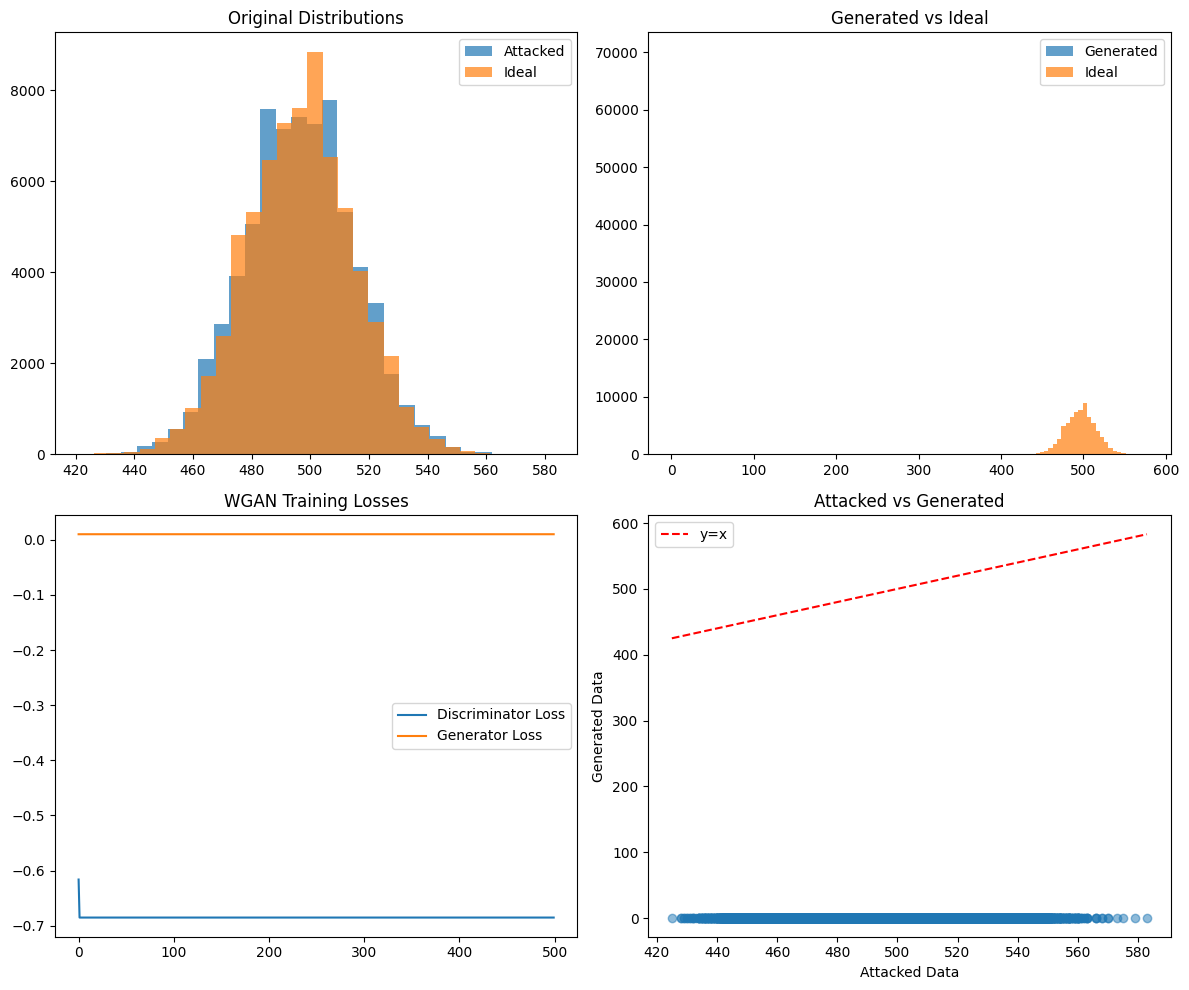

In [ ]:
print("Plotting results...")
plot_results(attacked_data, ideal_data, results['generated_data'], d_losses, g_losses)